# Points
* Do x ones out validation on the NN.
* Point out biases between SSPP and ASPCAP.
* Split less and more than 6500 Å into different polynomials.
* Do euclidian distance in all parameters to search for outliers.
* Use scatter instead of RMSE, where you remove the bias first.

* How to deal with uneven label distribution?

In [1]:
# # Google Colab prerequisits
# ! pip install corner
# ! pip install astroquery
# from google.colab import drive
# drive.mount('/content/gdrive')
# colab_path = '/content/gdrive/My Drive/Colab Notebooks/'

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import corner
import scipy.interpolate
import astropy
import seaborn as sns
# import mpld3
#mpld3.enable_notebook()
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from astroquery.sdss import SDSS
from tqdm import trange
from astropy.io import fits
from os import listdir
from os.path import isfile, join
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 9
mpl.rcParams['legend.fontsize'] = 'Large'
mpl.rcParams['figure.titlesize'] = 'Small'

np.random.seed(1942)

Using TensorFlow backend.


# Extracting APOGEE ra/dec, IDs, and labels

Some Teff labels have -9999. error, but defined Teff values..???

__Temp solution__: Remove them:

In [3]:
filename = "allStar-l31c.2.fits"
with fits.open(filename) as infile:
    data = infile[1].data
    N = len(infile[1].data)
    dec_allAPOGEE = np.zeros(N)
    ra_allAPOGEE = np.zeros(N)
    Teff_allAPOGEE = np.zeros(N)
    Teff_err_allAPOGEE = np.zeros(N)
    logg_allAPOGEE = np.zeros(N)
    logg_err_allAPOGEE = np.zeros(N)
    FeH_allAPOGEE = np.zeros(N)
    FeH_err_allAPOGEE = np.zeros(N)
    target_id = []
    for i in trange(N):
        dec_allAPOGEE[i] = data['DEC'][i]
        ra_allAPOGEE[i] = data['RA'][i]
        target_id.append(data['TARGET_ID'][i])
        Teff_allAPOGEE[i] = data['TEFF'][i]
        Teff_err_allAPOGEE[i] = data['TEFF_ERR'][i]
        logg_allAPOGEE[i] = data['LOGG'][i]
        logg_err_allAPOGEE[i] = data['LOGG_ERR'][i]
        FeH_allAPOGEE[i] = data['FE_H'][i]
        FeH_err_allAPOGEE[i] = data['FE_H_ERR'][i]
target_id = np.array(target_id)

cut_idx = (Teff_allAPOGEE != -9999.) & (logg_allAPOGEE != -9999.) & (FeH_err_allAPOGEE != -9999.)
Teff_allAPOGEE = Teff_allAPOGEE[cut_idx]; Teff_err_allAPOGEE = Teff_err_allAPOGEE[cut_idx];
logg_allAPOGEE = logg_allAPOGEE[cut_idx]; logg_err_allAPOGEE = logg_err_allAPOGEE[cut_idx];
FeH_allAPOGEE = FeH_allAPOGEE[cut_idx]; FeH_err_allAPOGEE = FeH_err_allAPOGEE[cut_idx];
ra_allAPOGEE = ra_allAPOGEE[cut_idx]; dec_allAPOGEE = dec_allAPOGEE[cut_idx]; target_id = target_id[cut_idx];
N = len(Teff_allAPOGEE)

100%|██████████| 277371/277371 [00:56<00:00, 4928.53it/s]


# Loading spectrum data

# Loading spectrum data attempt 2

In [4]:
match_idxs = np.load("match_idxs.npy")
nr_stars = len(match_idxs)

ra = ra_allAPOGEE[match_idxs]; dec = dec_allAPOGEE[match_idxs]
Teff = Teff_allAPOGEE[match_idxs]; Teff_err = Teff_err_allAPOGEE[match_idxs];
logg = logg_allAPOGEE[match_idxs]; logg_err = logg_err_allAPOGEE[match_idxs];
FeH = FeH_allAPOGEE[match_idxs]; FeH_err = FeH_err_allAPOGEE[match_idxs];
target_id = target_id[match_idxs];

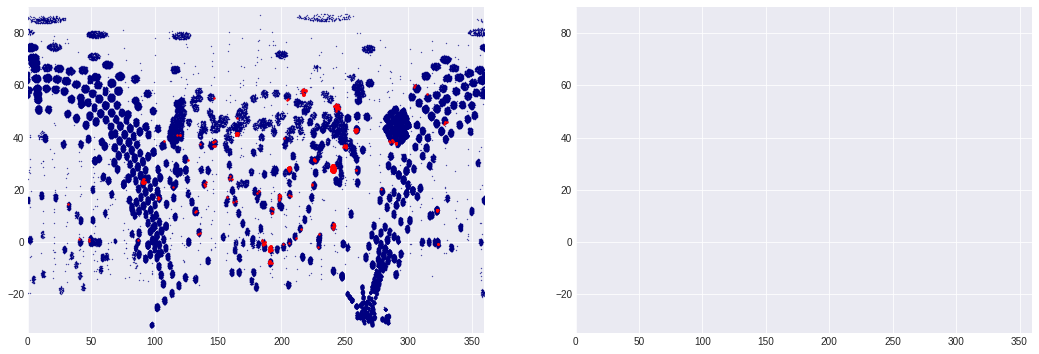

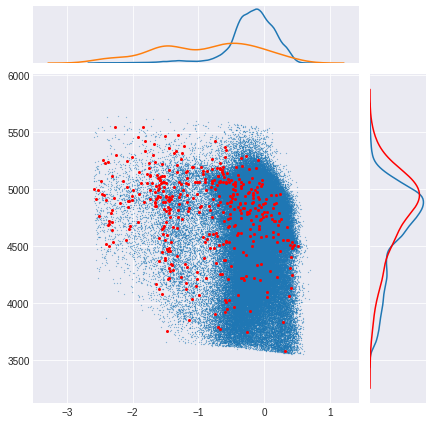

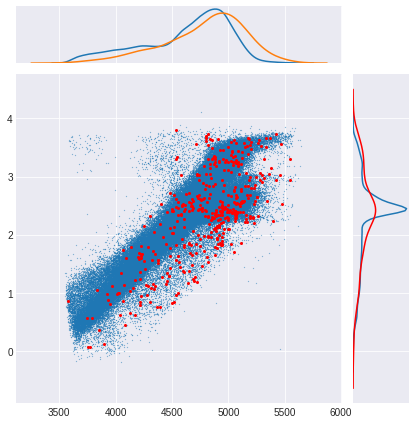

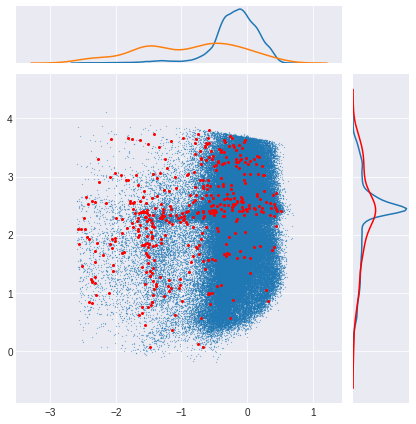

In [5]:
# plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(1, 2, figsize=(18,6));
ax[0].scatter(ra_allAPOGEE, dec_allAPOGEE, s=0.1, c="navy")
ax[0].scatter(ra, dec, s=2, c="red")
ax[0].set_xlim(0, 360); ax[0].set_ylim(-35, 90); ax[1].set_xlim(0, 360); ax[1].set_ylim(-35, 90);

# fig, ax = plt.subplots(1, 2, figsize=(18,8));
# ax[0].scatter(logg_allAPOGEE, Teff_allAPOGEE, s=0.1, c="navy")
# ax[0].scatter(logg, Teff, s=5, c="red");
# ax[0].set_xlim(-0.3, 4); ax[0].set_ylim(3500, 5700); ax[1].set_xlim(-0.3, 4); ax[1].set_ylim(3500, 5700);

# fig, ax = plt.subplots(1, 2, figsize=(18,8));
# ax[0].scatter(FeH_allAPOGEE, Teff_allAPOGEE, s=0.1, c="navy")
# ax[0].scatter(FeH, Teff, s=5, c="red");
# ax[0].set_xlim(-3, 1); ax[0].set_ylim(3500, 5700); ax[1].set_xlim(-3, 1); ax[1].set_ylim(3500, 5700);


g = sns.JointGrid(FeH, Teff)
sns.kdeplot(FeH_allAPOGEE, ax=g.ax_marg_x)
sns.kdeplot(Teff_allAPOGEE, ax=g.ax_marg_y, vertical=True)
sns.kdeplot(FeH, ax=g.ax_marg_x)
sns.kdeplot(Teff, ax=g.ax_marg_y, vertical=True, c="red")
g.ax_joint.plot(FeH_allAPOGEE, Teff_allAPOGEE, "o", ms=0.2)
g.ax_joint.plot(FeH, Teff, "o", ms=2, c="red")

g = sns.JointGrid(Teff, logg)
sns.kdeplot(Teff_allAPOGEE, ax=g.ax_marg_x)
sns.kdeplot(logg_allAPOGEE, ax=g.ax_marg_y, vertical=True)
sns.kdeplot(Teff, ax=g.ax_marg_x)
sns.kdeplot(logg, ax=g.ax_marg_y, vertical=True, c="red")
g.ax_joint.plot(Teff_allAPOGEE, logg_allAPOGEE, "o", ms=0.2)
g.ax_joint.plot(Teff, logg, "o", ms=2, c="red")

g = sns.JointGrid(FeH, logg)
sns.kdeplot(FeH_allAPOGEE, ax=g.ax_marg_x)
sns.kdeplot(logg_allAPOGEE, ax=g.ax_marg_y, vertical=True)
sns.kdeplot(FeH, ax=g.ax_marg_x)
sns.kdeplot(logg, ax=g.ax_marg_y, vertical=True, c="red")
g.ax_joint.plot(FeH_allAPOGEE, logg_allAPOGEE, "o", ms=0.2)
g.ax_joint.plot(FeH, logg, "o", ms=2, c="red")

In [6]:
specs = []
coords = astropy.coordinates.SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')
for i in trange(nr_stars):
    specs.append(SDSS.get_spectra(coords[i]))

100%|██████████| 425/425 [00:02<00:00, 146.42it/s]


In [7]:
wls = []
mags = []
mags_err = []
specids = []
nr_bad_pix = []
cut_idx = np.zeros(nr_stars, dtype=bool)

for i in trange(nr_stars):
    wl = []
    mag = []
    model = []
    mag_err = []
    spec = specs[i][0][1].data
    for j in range(len(spec)):
        mag.append(spec[j][0])
        mag_err.append(spec[j][2])
        wl.append(10**(spec[j][1]))
    if (np.array(mag) != 0).any():  # Some stars have zero magnitude all over. Ignore those.
        wls.append(np.array(wl))
        mags.append(np.array(mag))
        mags_err.append(np.array(mag_err))
        specids.append(specs[i][0][0].header['SPEC_ID'])
        nr_bad_pix.append(specs[i][0][0].header['FBADPIX'])
        cut_idx[i] = True

nr_stars = len(wls)
Teff = Teff[cut_idx]; Teff_err = Teff_err[cut_idx]; logg = logg[cut_idx]; logg_err = logg_err[cut_idx];
FeH = FeH[cut_idx]; FeH_err = FeH_err[cut_idx]; ra = ra[cut_idx]; dec = dec[cut_idx]; target_id = target_id[cut_idx];
print(f"Retrieved {nr_stars} spectrums from APOGEE.")

100%|██████████| 425/425 [03:12<00:00,  2.22it/s]

Retrieved 422 spectrums from APOGEE.


# Cutting the optical SDSS spectra
As it happens, the SDSS spectra are aligned in their spectra, but some expand further than others in each direction. We will cut all of them to the shortest spectra.

In [8]:
wl_min, wl_max = 1e10, 0
for i in range(nr_stars):
    if wls[i].min() < wl_min:
        wl_min = wls[i].min()
    if wls[i].max() > wl_max:
        wl_max = wls[i].max()

wl_start, wl_stop = 0, 1e10
for i in range(nr_stars):
    if wls[i][-1].min() < wl_stop:
        wl_stop = wls[i][-1].min()
    if wls[i][0].max() > wl_start:
        wl_start = wls[i][0].max()
    
print(f"The shortest and longest found wavelengths were {wl_min:.1f} and {wl_max:.1f}, respectively.")
print(f"The chosen start and end points for our spectra are {wl_start:.1f} and {wl_stop:.1f}, respectively.")

The shortest and longest found wavelengths were 3788.8 and 9240.6, respectively.
The chosen start and end points for our spectra are 3944.6 and 8990.8, respectively.


In [9]:
for i in range(nr_stars):
    cut_idx2 = np.argwhere( (wl_start < wls[i]) & ( wls[i] < wl_stop))[:,0]
    if len(cut_idx2) != 3577:
        print("yolo")
    wls[i] = wls[i][cut_idx2]
    mags[i] = mags[i][cut_idx2]
    mags_err[i] = mags_err[i][cut_idx2]

wl = np.array(wls[-1]); mags = np.array(mags); mags_err = np.array(mags_err)
del wls;  # all wavelengths are the same now, no need to keep them seperate.
mags_RMSE = np.linalg.norm(mags_err, axis=1)
nr_pixels = len(wl)
print(f"After aligning all spectra, we are left with {nr_pixels} pixels.")

After aligning all spectra, we are left with 3577 pixels.


# More Stuff

In [10]:
# N = nr_stars//4+1
# fig, ax = plt.subplots(N, 4, figsize=(18,N*4))
# for i in range(nr_stars):
#     j, k = i//4, i%4
#     idx = i#np.random.randint(0, nr_stars)
#     ax[j,k].set_title(target_id[idx])
#     ax[j,k].plot(wl, mags[idx], c="navy", lw=1);
#     ax2 = ax[j,k].twinx()
#     ax2.plot(wl, mags_err[idx], c="crimson", lw=0.5);
# plt.tight_layout();

In [11]:
# specs[0][0][0].header

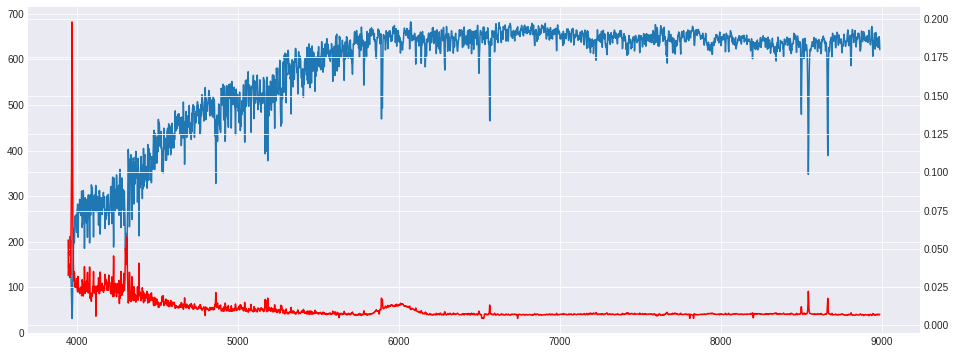

In [12]:
j = 16
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(wl, mags[j]);
ax2 = ax1.twinx()
ax2.plot(wl, mags_err[j], c = "r");

# Reading SSPPOUT file to compare ASPCAP labels to SDSS labels



In [13]:
Teff_SDSS = np.zeros(nr_stars)
Teff_err_SDSS = np.zeros(nr_stars)
logg_SDSS = np.zeros(nr_stars)
logg_err_SDSS = np.zeros(nr_stars)
FeH_SDSS = np.zeros(nr_stars)
FeH_err_SDSS = np.zeros(nr_stars)
Vband = np.zeros(nr_stars)
Gband = np.zeros(nr_stars)
BV_color = np.zeros(nr_stars)

ra_SDSS = np.zeros(nr_stars)
dec_SDSS = np.zeros(nr_stars)

filename = "ssppOut-dr12.fits"
with fits.open(filename) as infile:
    data = infile[1].data
    for i in trange(nr_stars):
        idx = np.argwhere(specids[i] == data['SPECOBJID'])[0]
        Teff_SDSS[i] = data['TEFF_ADOP'][idx]
        Teff_err_SDSS[i] = data['TEFF_ADOP_UNC'][idx]
        logg_SDSS[i] = data['LOGG_ADOP'][idx]
        logg_err_SDSS[i] = data['LOGG_ADOP_UNC'][idx]
        FeH_SDSS[i] = data['FEH_ADOP'][idx]
        FeH_err_SDSS[i] = data['FEH_ADOP_UNC'][idx]
        Vband[i] = data['V_MAG'][idx]
        Gband[i] = data['G_MAG'][idx]
        BV_color[i] = data['BV'][idx]
        ra_SDSS[i] = data['RA'][idx]
        dec_SDSS[i] = data['DEC'][idx]
    
Teff_SDSS[Teff_SDSS == -9999.] = np.nan
logg_SDSS[logg_SDSS == -9999.] = np.nan
FeH_SDSS[FeH_SDSS == -9999.] = np.nan

labels_SDSS = np.array([Teff_SDSS, logg_SDSS, FeH_SDSS]).T
labels = np.array([Teff, logg, FeH]).T
label_names = ["Teff", "Log(g)", "FeH"]

print(f"The SSPP labeled SDSS files contains {np.sum(np.isnan(Teff_SDSS))} nans.");

100%|██████████| 422/422 [00:18<00:00, 22.53it/s]

The SSPP labeled SDSS files contains 55 nans.


166.8, 171.7, 0.065, 0.387, -0.012, 0.184


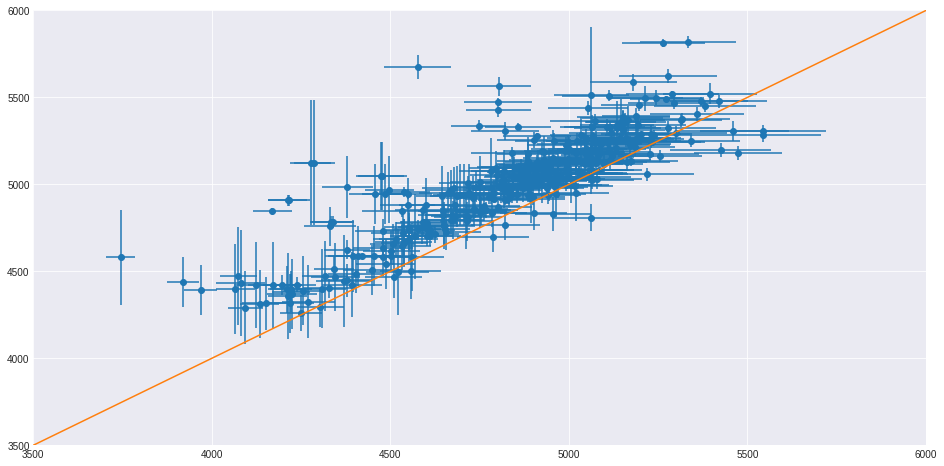

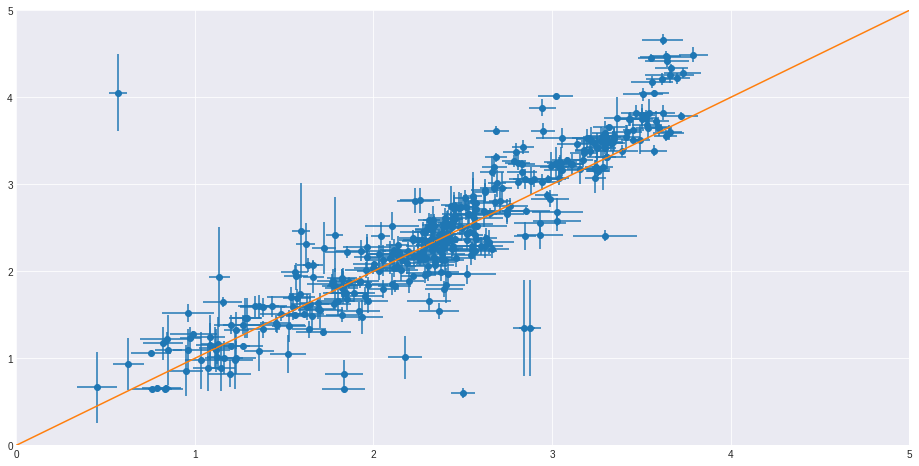

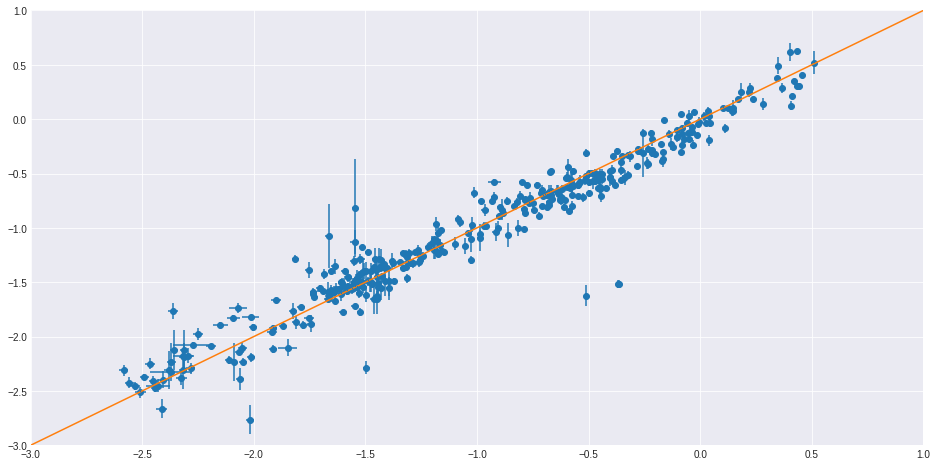

In [14]:
label_xlims = [[3800, 5700], [0.4, 3.8], [-2.6, 0.6]]

plt.figure(figsize=(16,8))
plt.scatter(Teff, Teff_SDSS)
plt.errorbar(Teff, Teff_SDSS, xerr=Teff_err, yerr=Teff_err_SDSS, fmt=",")
plt.xlim(3500,6000)
plt.ylim(3500,6000)
plt.plot([0,10000], [0,10000])

plt.figure(figsize=(16,8))
plt.scatter(logg, logg_SDSS)
plt.errorbar(logg, logg_SDSS, xerr=logg_err, yerr=logg_err_SDSS, fmt=",")
plt.xlim(0,5)
plt.ylim(0,5)
plt.plot([0,10],[0,10])

plt.figure(figsize=(16,8))
plt.scatter(FeH, FeH_SDSS)
plt.errorbar(FeH, FeH_SDSS, xerr=FeH_err, yerr=FeH_err_SDSS, fmt=",")
plt.xlim(-3, 1)
plt.ylim(-3, 1)
plt.plot([-5,5],[-5,5]);

bias_Teff = np.mean(Teff_SDSS[~np.isnan(Teff_SDSS)] - Teff[~np.isnan(Teff_SDSS)])
scatter_Teff = np.sqrt(mean_squared_error(Teff_SDSS[~np.isnan(Teff_SDSS)]-bias_Teff, Teff[~np.isnan(Teff_SDSS)]))
bias_logg = np.mean(logg_SDSS[~np.isnan(logg_SDSS)] - logg[~np.isnan(logg_SDSS)])
scatter_logg = np.sqrt(mean_squared_error(logg_SDSS[~np.isnan(logg_SDSS)]-bias_logg, logg[~np.isnan(logg_SDSS)]))
bias_FeH = np.mean(FeH_SDSS[~np.isnan(FeH_SDSS)] - FeH[~np.isnan(FeH_SDSS)])
scatter_FeH = np.sqrt(mean_squared_error(FeH_SDSS[~np.isnan(FeH_SDSS)]-bias_FeH, FeH[~np.isnan(FeH_SDSS)]))

print(f"{bias_Teff:.1f}, {scatter_Teff:.1f}, {bias_logg:.3f}, {scatter_logg:.3f}, {bias_FeH:.3f}, {scatter_FeH:.3f}")

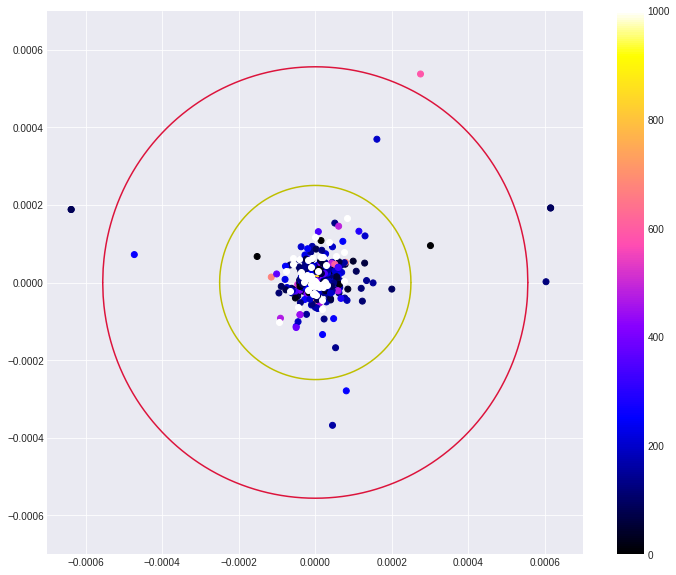

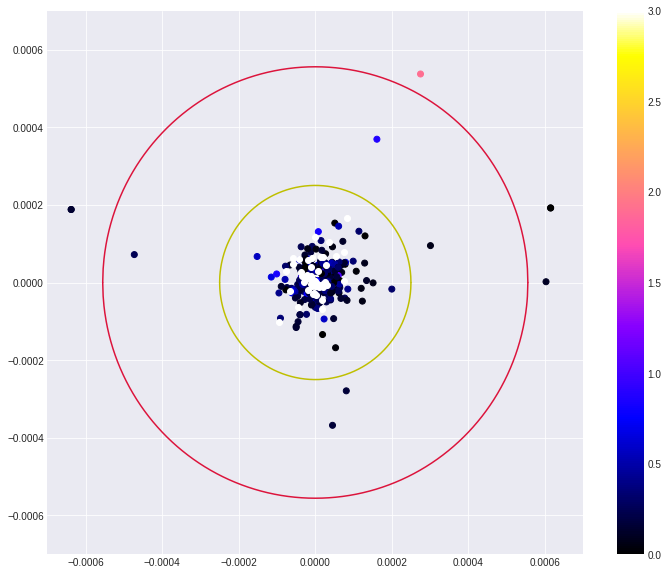

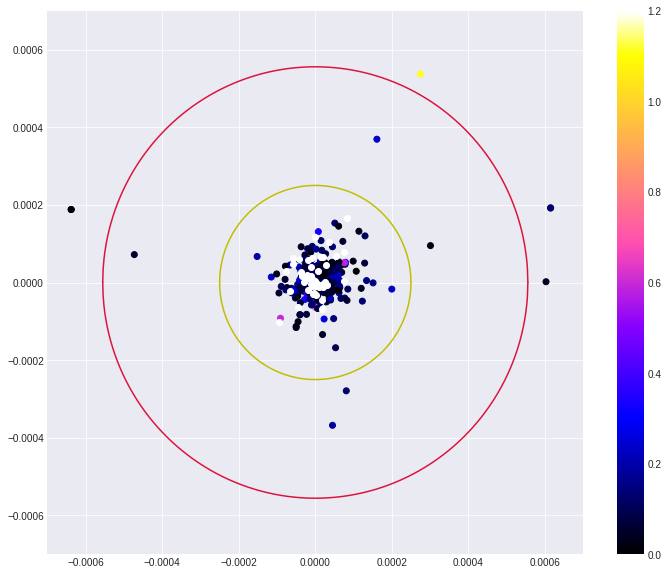

In [15]:
plt.figure(figsize=(12,10))
sc = plt.scatter(ra-ra_SDSS, dec-dec_SDSS, c=np.abs(Teff_SDSS - Teff), cmap='gnuplot2', vmin=0, vmax=1000)
cut_idx = np.isnan(Teff_SDSS)
plt.scatter(ra[cut_idx]-ra_SDSS[cut_idx], dec[cut_idx]-dec_SDSS[cut_idx], c='white')
plt.xlim(-0.0007, 0.0007)
plt.ylim(-0.0007, 0.0007)
x = np.linspace(-(2/3600), (2/3600), 1001)
plt.plot(x, np.sqrt((2/3600)**2 - x**2), c="crimson")
plt.plot(x, -np.sqrt((2/3600)**2 - x**2), c="crimson")

x = np.linspace(-0.00025, 0.00025, 1001)
plt.plot(x, np.sqrt(0.00025**2 - x**2), c="y")
plt.plot(x, -np.sqrt(0.00025**2 - x**2), c="y")
plt.colorbar(sc);

plt.figure(figsize=(12,10))
sc = plt.scatter(ra-ra_SDSS, dec-dec_SDSS, c=np.abs(logg_SDSS - logg), cmap='gnuplot2', vmin=0, vmax=3)
cut_idx = np.isnan(logg_SDSS)
plt.scatter(ra[cut_idx]-ra_SDSS[cut_idx], dec[cut_idx]-dec_SDSS[cut_idx], c='white')
plt.xlim(-0.0007, 0.0007)
plt.ylim(-0.0007, 0.0007)
x = np.linspace(-(2/3600), (2/3600), 1001)
plt.plot(x, np.sqrt((2/3600)**2 - x**2), c="crimson")
plt.plot(x, -np.sqrt((2/3600)**2 - x**2), c="crimson")

x = np.linspace(-0.00025, 0.00025, 1001)
plt.plot(x, np.sqrt(0.00025**2 - x**2), c="y")
plt.plot(x, -np.sqrt(0.00025**2 - x**2), c="y")
plt.colorbar(sc);


plt.figure(figsize=(12,10))
sc = plt.scatter(ra-ra_SDSS, dec-dec_SDSS, c=np.abs(FeH_SDSS - FeH), cmap='gnuplot2', vmin=0, vmax=1.2)
cut_idx = np.isnan(FeH_SDSS)
plt.scatter(ra[cut_idx]-ra_SDSS[cut_idx], dec[cut_idx]-dec_SDSS[cut_idx], c='white')
plt.xlim(-0.0007, 0.0007)
plt.ylim(-0.0007, 0.0007)
x = np.linspace(-(2/3600), (2/3600), 1001)
plt.plot(x, np.sqrt((2/3600)**2 - x**2), c="crimson")
plt.plot(x, -np.sqrt((2/3600)**2 - x**2), c="crimson")

x = np.linspace(-0.00025, 0.00025, 1001)
plt.plot(x, np.sqrt(0.00025**2 - x**2), c="y")
plt.plot(x, -np.sqrt(0.00025**2 - x**2), c="y")
plt.colorbar(sc);

# Reading SPECOBJ file to compare to ASPCAP labels
Note to self: The SPECOBJ files contains very weird Teff and logg values. While there are no nans (which is just suspicious), the values are weirdly spaced, and fit worse with ASPCAP than the SSPP files do.

# Curve-Smoothing Attempt at Pseudo-Normalization

In [16]:
# def ContinuumFitConvolution(mags, window_len = 1000):
#     fits = np.zeros((mags.shape[0], mags.shape[1]))
#     for i in range(mags.shape[0]):
#         mag = mags[i]
#         window = np.hanning(window_len)
#         s = np.r_[mag[window_len-1:0:-1], mag, mag[-2:-window_len-1:-1]]
#         fits[i] = np.convolve(window/window.sum(), s, mode='valid')[window_len//2 : -window_len//2+1]
#     return fits

# convolution_fit = ContinuumFitConvolution(mags)
# mags_norm_conv0 = mags/convolution_fit

# Pseudo-normalization
[Lee et al. 2018a](https://arxiv.org/abs/0710.5645v1)

In [17]:
def Polynomial(x, p):
    deg = len(p)
    y = np.zeros(x.shape[-1])
    for i in range(deg):
        y += p[deg-1-i]*x**i
    return y

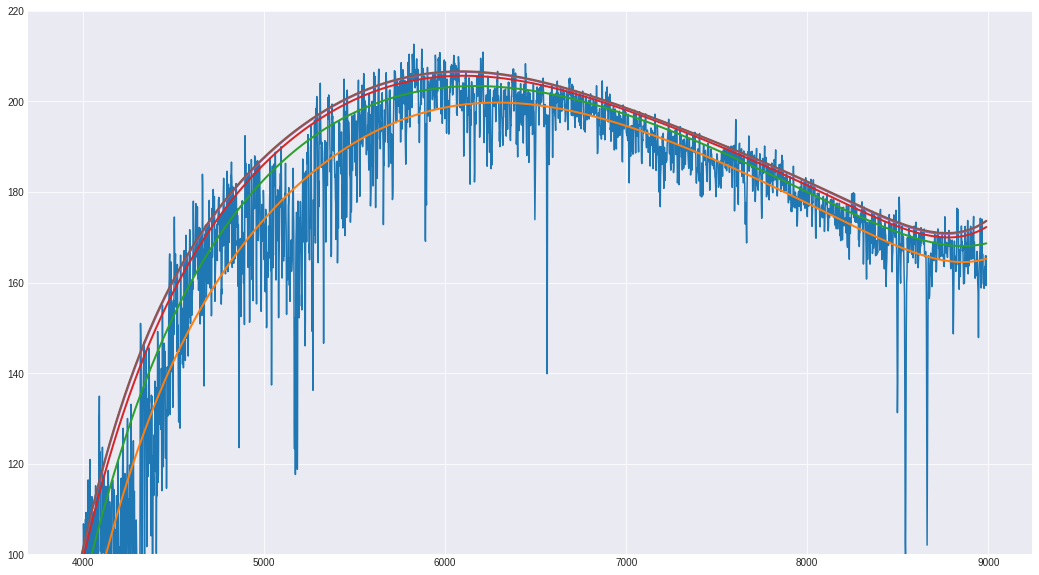

In [18]:
j = 94
deg = 7

plt.figure(figsize=(18,10))
plt.ylim(100, 220)
plt.plot(wl, mags[j])

p = np.polyfit(wl, mags[j], deg)
polyfit = Polynomial(wl, p)
plt.plot(wl, polyfit, lw=2)

for i in range(4):
    w = np.ones(nr_pixels)
    w[mags[j] < polyfit] = 0.15
    p = np.polyfit(wl, mags[j], deg, w=w)
    polyfit = Polynomial(wl, p)

    plt.plot(wl, polyfit, lw=2)

In [19]:
def ContinuumFit(wl, mags):
    polyfits = np.zeros((nr_stars, nr_pixels))
    wl1, wl2 = np.split(wl, [2168])
    for j in trange(nr_stars):
        mag1, mag2 = np.split(mags[j], [2168])
        p1 = np.polyfit(wl1, mag1, deg)
        p2 = np.polyfit(wl2, mag2, deg)
        polyfit1 = Polynomial(wl1, p1)
        polyfit2 = Polynomial(wl2, p2)
        for i in range(4):
            w1 = np.ones(len(wl1))
            w2 = np.ones(len(wl2))
            w1[mag1 < polyfit1] = 0.15
            w2[mag2 < polyfit2] = 0.15
            p1 = np.polyfit(wl1, mag1, deg, w=w1)
            p2 = np.polyfit(wl2, mag2, deg, w=w2)
            polyfit1 = Polynomial(wl1, p1)
            polyfit2 = Polynomial(wl2, p2)
        polyfits[j] = np.concatenate((polyfit1, polyfit2), axis=0)
    return polyfits

polyfits = ContinuumFit(wl, mags)
mags_norm_poly = mags/polyfits
# mags_err_norm = mags_err/polyfits

100%|██████████| 422/422 [00:03<00:00, 111.25it/s]


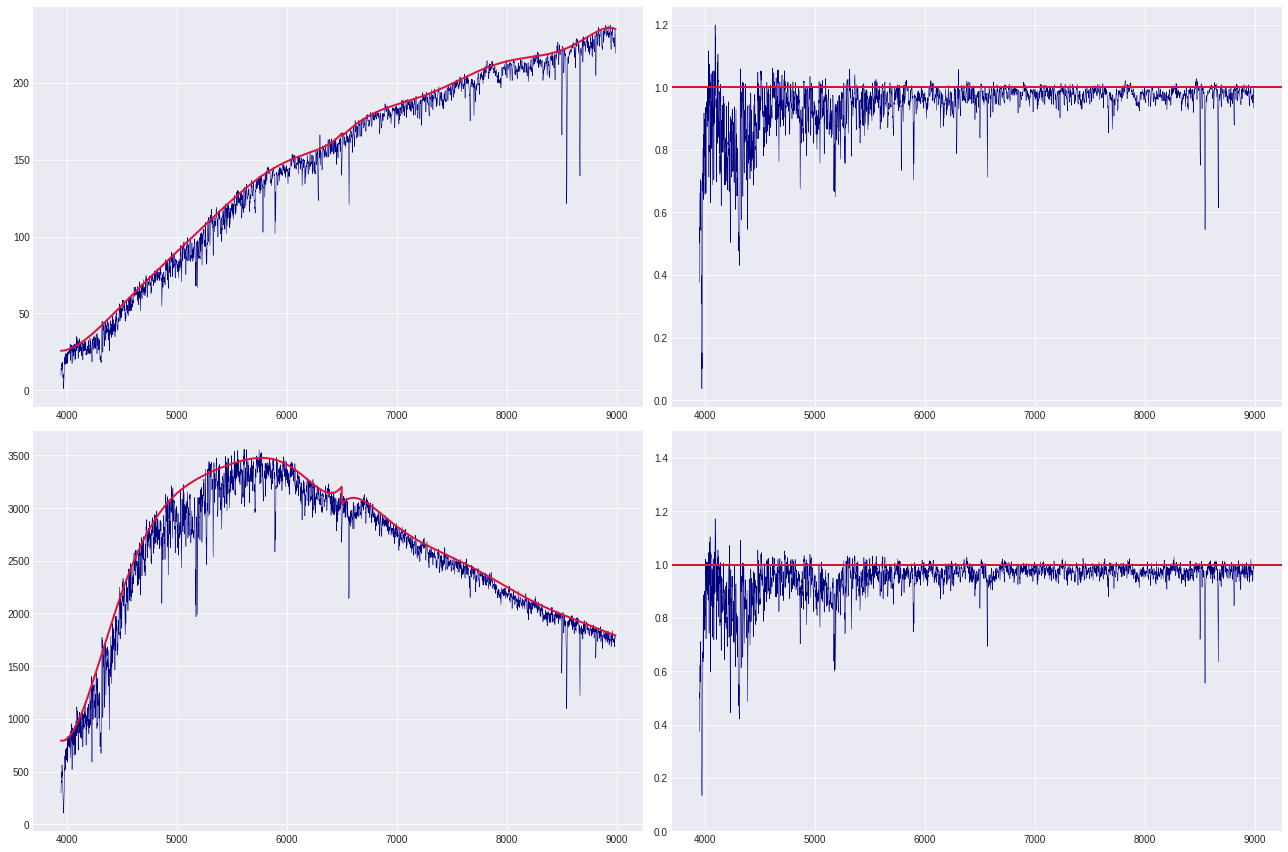

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(18,12)); plt.ylim(0, 1.5)

for i in range(2):
    j = [19,225][i]
    ax[i,0].plot(wl, mags[j], c="navy", lw=0.5)
    ax[i,0].plot(wl, polyfits[j], c="crimson", lw=2)
    ax[i,1].plot(wl, mags_norm_poly[j], c="navy", lw=0.5)
    ax[i,1].axhline(y=1, c="crimson", lw=2)
plt.tight_layout();

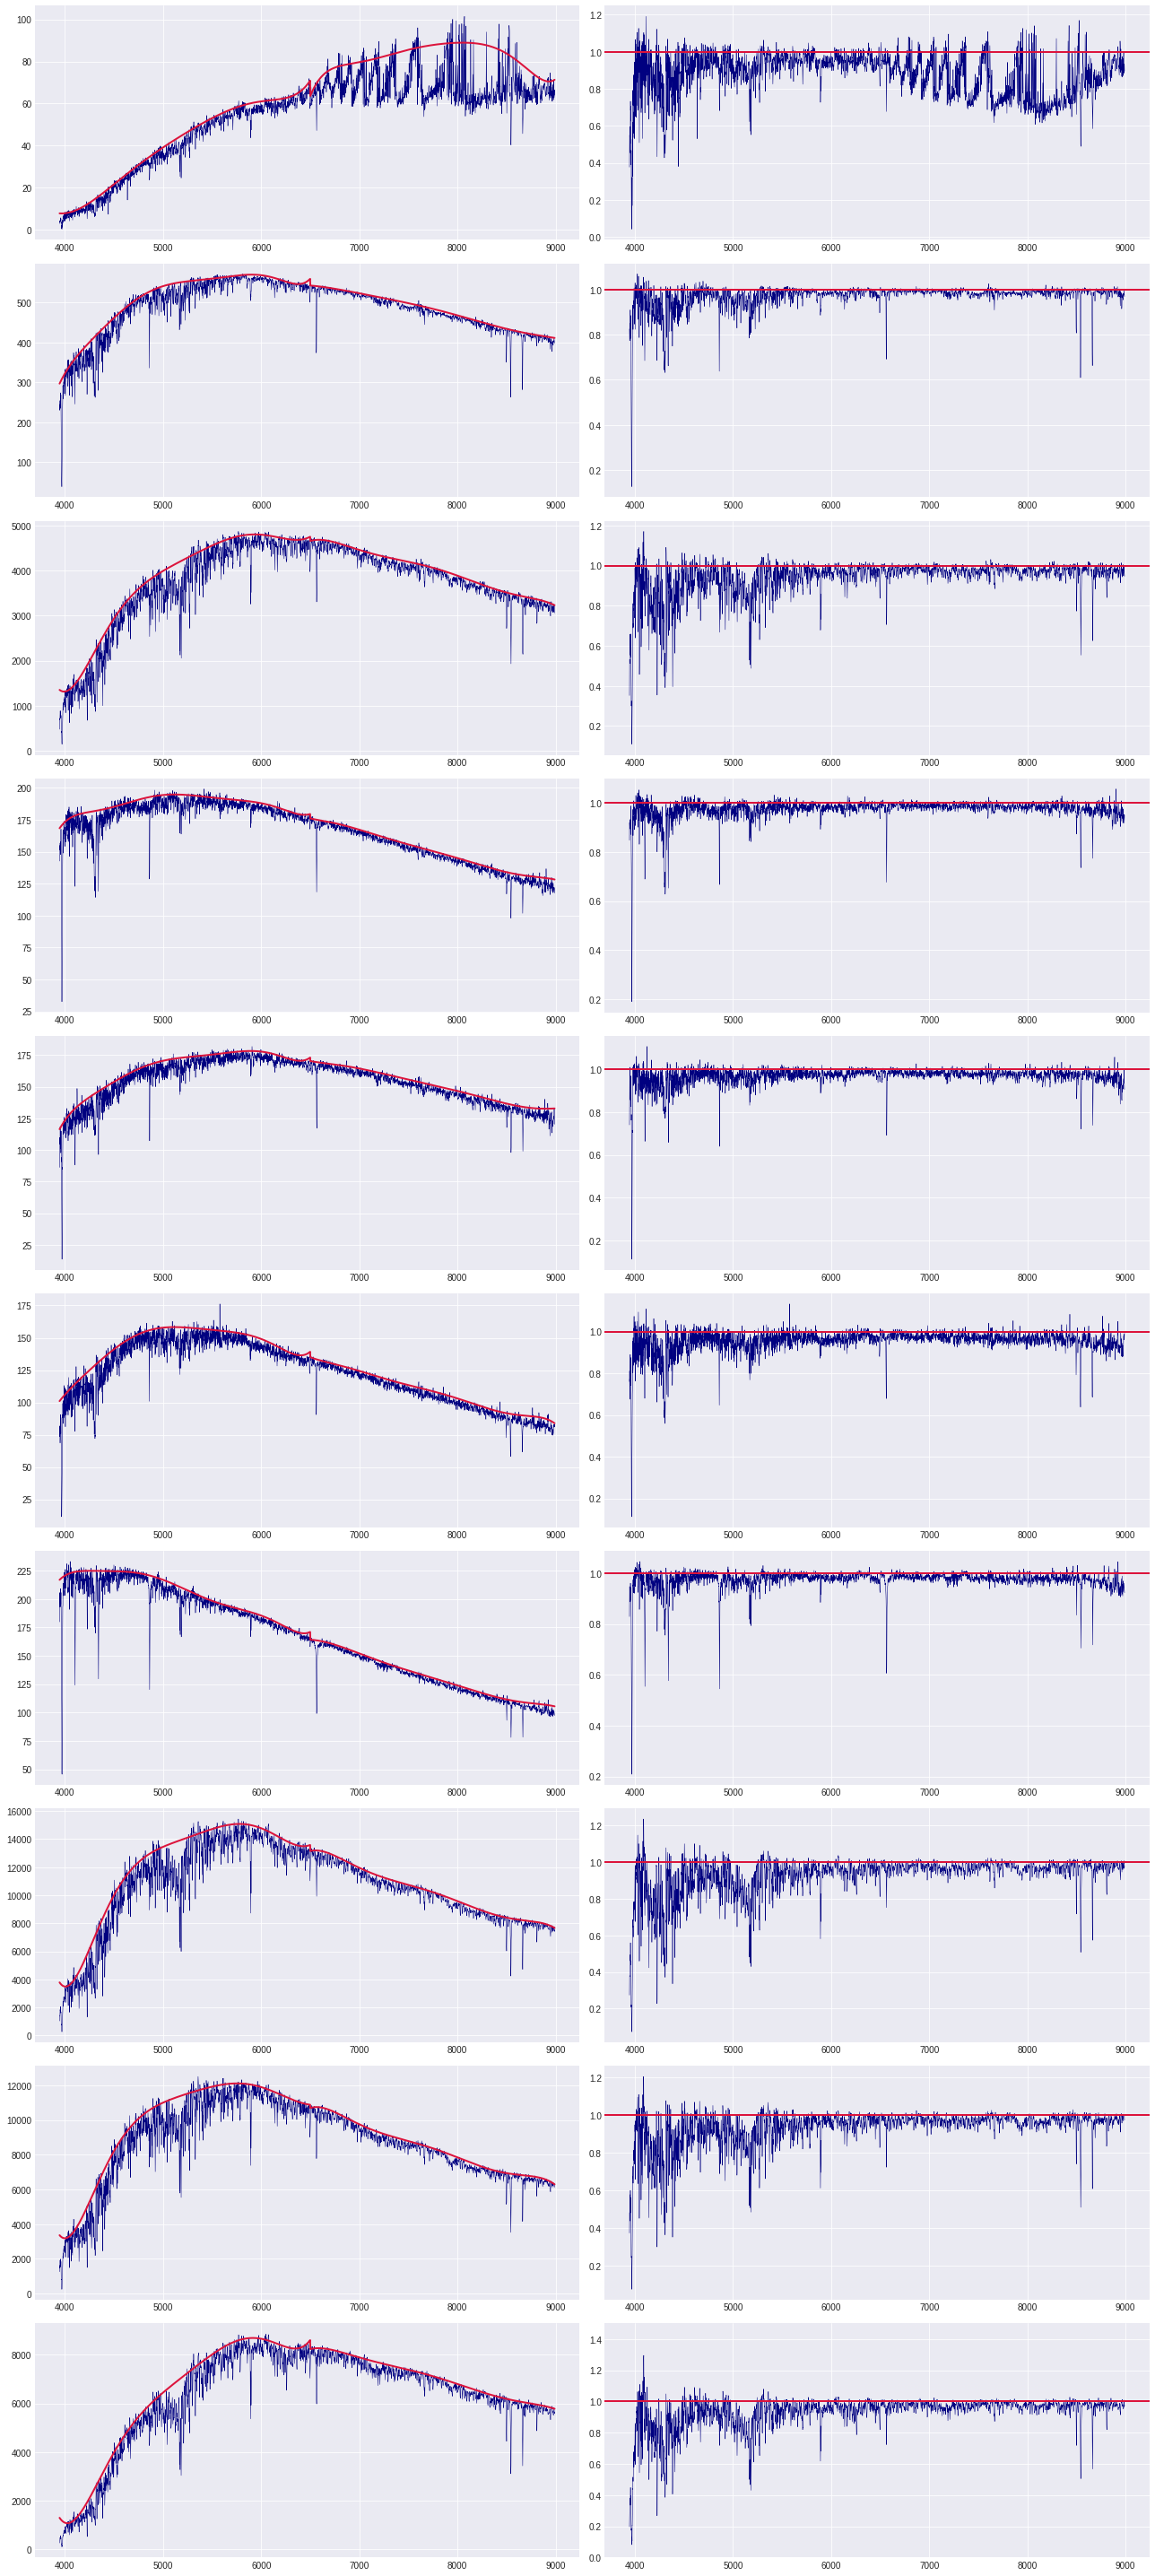

In [21]:
fig, ax = plt.subplots(10, 2, figsize=(18,40)); plt.ylim(0, 1.5)

for i in range(10):
    j = 32*i
    ax[i,0].plot(wl, mags[j], c="navy", lw=0.5)
    ax[i,0].plot(wl, polyfits[j], c="crimson", lw=2)
    ax[i,1].plot(wl, mags_norm_poly[j], c="navy", lw=0.5)
    ax[i,1].axhline(y=1, c="crimson", lw=2)
plt.tight_layout();

# AI Pseudo-Normalizing using an Iterative Blockchain Neural Net which is also doing Deep Learning (and KongFu)

In [22]:
ScalerNN = preprocessing.StandardScaler()
ScalerNN.fit(labels)
input_scaled = ScalerNN.transform(labels)
output = mags_norm_poly.copy()

In [23]:
opti = optimizers.adam(amsgrad=True, lr=0.0003)#, decay=0.01)
def nn_clf():
    model = Sequential()
    model.add(Dense(40, input_shape=(3,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(40,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(40,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(nr_pixels, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_squared_error',  metrics=['mae',"mse"])
    return model
nn_clf().summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_4 (Dense)              (None, 3577)              146657    
Total params: 150,097
Trainable params: 150,097
Non-trainable params: 0
_________________________________________________________________


## Finding best epoch number without overfitting:

In [24]:
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# history = History()
# clf = KerasRegressor(build_fn=nn_clf, batch_size=16, epochs=10000, callbacks=[mcp_save, history], validation_split=0.30)
# history = clf.fit(input_scaled, output)

In [25]:
# plt.figure(figsize=(18,12))
# MSE = np.array(history.history['mean_squared_error'])
# val_MSE = np.array(history.history['val_mean_squared_error'])
# plt.ylim(0, 0.004)
# asdf = np.argsort(val_MSE)[:10]
# plt.axhline(y=val_MSE[asdf[0]], c="crimson", ls="--")
# plt.plot(MSE, c="b")
# plt.plot(val_MSE, c="g")
# plt.scatter(asdf, val_MSE[asdf], c="r")

# Running NN for optimal epoch number

In [26]:
clf = KerasRegressor(build_fn=nn_clf, batch_size=16, epochs=4000)
history = clf.fit(input_scaled, output)

Instructions for updating:
Use tf.cast instead.
Epoch 1/4000
422/422 [==============================] - 1s 2ms/step - loss: 0.8875 - mean_absolute_error: 0.9376 - mean_squared_error: 0.8875
Epoch 2/4000
422/422 [==============================] - 0s 147us/step - loss: 0.8633 - mean_absolute_error: 0.9246 - mean_squared_error: 0.8633
Epoch 3/4000
422/422 [==============================] - 0s 148us/step - loss: 0.7984 - mean_absolute_error: 0.8886 - mean_squared_error: 0.7984
Epoch 4/4000
422/422 [==============================] - 0s 153us/step - loss: 0.6186 - mean_absolute_error: 0.7787 - mean_squared_error: 0.6186
Epoch 5/4000
422/422 [==============================] - 0s 139us/step - loss: 0.2830 - mean_absolute_error: 0.5067 - mean_squared_error: 0.2830
Epoch 6/4000
422/422 [==============================] - 0s 155us/step - loss: 0.0464 - mean_absolute_error: 0.1759 - mean_squared_error: 0.0464
Epoch 7/4000
422/422 [==============================] - 0s 148us/step - loss: 0.0168 - mea

422/422 [==============================] - 0s 140us/step - loss: 0.0025 - mean_absolute_error: 0.0268 - mean_squared_error: 0.0025
Epoch 56/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0025 - mean_absolute_error: 0.0265 - mean_squared_error: 0.0025
Epoch 57/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0025 - mean_absolute_error: 0.0262 - mean_squared_error: 0.0025
Epoch 58/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0025 - mean_absolute_error: 0.0260 - mean_squared_error: 0.0025
Epoch 59/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0025 - mean_absolute_error: 0.0261 - mean_squared_error: 0.0025
Epoch 60/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0024 - mean_absolute_error: 0.0259 - mean_squared_error: 0.0024
Epoch 61/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0024 - mean_absolute_error: 0.0260 - mean_squared_error: 0.0024

422/422 [==============================] - 0s 141us/step - loss: 0.0022 - mean_absolute_error: 0.0238 - mean_squared_error: 0.0022
Epoch 112/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0022 - mean_absolute_error: 0.0236 - mean_squared_error: 0.0022
Epoch 113/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0022 - mean_absolute_error: 0.0236 - mean_squared_error: 0.0022
Epoch 114/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0022 - mean_absolute_error: 0.0237 - mean_squared_error: 0.0022
Epoch 115/4000
422/422 [==============================] - 0s 165us/step - loss: 0.0022 - mean_absolute_error: 0.0235 - mean_squared_error: 0.0022
Epoch 116/4000
422/422 [==============================] - 0s 177us/step - loss: 0.0023 - mean_absolute_error: 0.0245 - mean_squared_error: 0.0023
Epoch 117/4000
422/422 [==============================] - 0s 181us/step - loss: 0.0022 - mean_absolute_error: 0.0237 - mean_squared_error: 

422/422 [==============================] - 0s 147us/step - loss: 0.0022 - mean_absolute_error: 0.0234 - mean_squared_error: 0.0022
Epoch 168/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0022 - mean_absolute_error: 0.0233 - mean_squared_error: 0.0022
Epoch 169/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0022 - mean_absolute_error: 0.0232 - mean_squared_error: 0.0022
Epoch 170/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0022 - mean_absolute_error: 0.0232 - mean_squared_error: 0.0022
Epoch 171/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0022 - mean_absolute_error: 0.0234 - mean_squared_error: 0.0022
Epoch 172/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0022 - mean_absolute_error: 0.0233 - mean_squared_error: 0.0022
Epoch 173/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0022 - mean_absolute_error: 0.0233 - mean_squared_error: 

422/422 [==============================] - 0s 136us/step - loss: 0.0021 - mean_absolute_error: 0.0230 - mean_squared_error: 0.0021
Epoch 224/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0021 - mean_absolute_error: 0.0231 - mean_squared_error: 0.0021
Epoch 225/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0021 - mean_absolute_error: 0.0230 - mean_squared_error: 0.0021
Epoch 226/4000
422/422 [==============================] - 0s 132us/step - loss: 0.0021 - mean_absolute_error: 0.0230 - mean_squared_error: 0.0021
Epoch 227/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0021 - mean_absolute_error: 0.0231 - mean_squared_error: 0.0021
Epoch 228/4000
422/422 [==============================] - 0s 150us/step - loss: 0.0021 - mean_absolute_error: 0.0230 - mean_squared_error: 0.0021
Epoch 229/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0021 - mean_absolute_error: 0.0229 - mean_squared_error: 

422/422 [==============================] - 0s 140us/step - loss: 0.0021 - mean_absolute_error: 0.0229 - mean_squared_error: 0.0021
Epoch 280/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0021 - mean_absolute_error: 0.0229 - mean_squared_error: 0.0021
Epoch 281/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0021 - mean_absolute_error: 0.0227 - mean_squared_error: 0.0021
Epoch 282/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0021 - mean_absolute_error: 0.0228 - mean_squared_error: 0.0021
Epoch 283/4000
422/422 [==============================] - 0s 133us/step - loss: 0.0021 - mean_absolute_error: 0.0228 - mean_squared_error: 0.0021
Epoch 284/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0021 - mean_absolute_error: 0.0230 - mean_squared_error: 0.0021
Epoch 285/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0021 - mean_absolute_error: 0.0227 - mean_squared_error: 

422/422 [==============================] - 0s 144us/step - loss: 0.0021 - mean_absolute_error: 0.0226 - mean_squared_error: 0.0021
Epoch 336/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0021 - mean_absolute_error: 0.0227 - mean_squared_error: 0.0021
Epoch 337/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0021 - mean_absolute_error: 0.0226 - mean_squared_error: 0.0021
Epoch 338/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0021 - mean_absolute_error: 0.0227 - mean_squared_error: 0.0021
Epoch 339/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0021 - mean_absolute_error: 0.0226 - mean_squared_error: 0.0021
Epoch 340/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0021 - mean_absolute_error: 0.0227 - mean_squared_error: 0.0021
Epoch 341/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0021 - mean_absolute_error: 0.0227 - mean_squared_error: 

422/422 [==============================] - 0s 144us/step - loss: 0.0020 - mean_absolute_error: 0.0224 - mean_squared_error: 0.0020
Epoch 392/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0020
Epoch 393/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0020 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0020
Epoch 394/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0020 - mean_absolute_error: 0.0224 - mean_squared_error: 0.0020
Epoch 395/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0020 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0020
Epoch 396/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0020 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0020
Epoch 397/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0020 - mean_absolute_error: 0.0223 - mean_squared_error: 

422/422 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0221 - mean_squared_error: 0.0020
Epoch 448/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0020
Epoch 449/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0020 - mean_absolute_error: 0.0221 - mean_squared_error: 0.0020
Epoch 450/4000
422/422 [==============================] - 0s 133us/step - loss: 0.0020 - mean_absolute_error: 0.0221 - mean_squared_error: 0.0020
Epoch 451/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0020 - mean_absolute_error: 0.0221 - mean_squared_error: 0.0020
Epoch 452/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0020 - mean_absolute_error: 0.0221 - mean_squared_error: 0.0020
Epoch 453/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0020 - mean_absolute_error: 0.0221 - mean_squared_error: 

422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 504/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0020
Epoch 505/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 506/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0020
Epoch 507/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0020
Epoch 508/4000
422/422 [==============================] - 0s 128us/step - loss: 0.0020 - mean_absolute_error: 0.0221 - mean_squared_error: 0.0020
Epoch 509/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 

422/422 [==============================] - 0s 144us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 560/4000
422/422 [==============================] - 0s 149us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 561/4000
422/422 [==============================] - 0s 148us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0020
Epoch 562/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 563/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0020
Epoch 564/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0020
Epoch 565/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 

422/422 [==============================] - 0s 139us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 616/4000
422/422 [==============================] - 0s 134us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0020
Epoch 617/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 618/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 619/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 620/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 621/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 

422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 672/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 673/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 674/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 675/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 676/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 677/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 

422/422 [==============================] - 0s 148us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 728/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 729/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 730/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 731/4000
422/422 [==============================] - 0s 134us/step - loss: 0.0020 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0020
Epoch 732/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0020
Epoch 733/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 

422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 784/4000
422/422 [==============================] - 0s 158us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 785/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 786/4000
422/422 [==============================] - 0s 130us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 787/4000
422/422 [==============================] - 0s 148us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 788/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 789/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 

422/422 [==============================] - 0s 145us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 840/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 841/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0020
Epoch 842/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0020 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0020
Epoch 843/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 844/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 845/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 

422/422 [==============================] - 0s 147us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 896/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 897/4000
422/422 [==============================] - 0s 150us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 898/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 899/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 900/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 901/4000
422/422 [==============================] - 0s 133us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 

422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 952/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 953/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 954/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 955/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 956/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 957/4000
422/422 [==============================] - 0s 133us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 

422/422 [==============================] - 0s 144us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 1008/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 1009/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1010/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1011/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1012/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 1013/4000
422/422 [==============================] - 0s 148us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_e

422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1063/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1064/4000
422/422 [==============================] - 0s 150us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1065/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0020
Epoch 1066/4000
422/422 [==============================] - 0s 150us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 1067/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1068/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_e

422/422 [==============================] - 0s 132us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1118/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0020 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0020
Epoch 1119/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 1120/4000
422/422 [==============================] - 0s 147us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 1121/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1122/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1123/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_e

422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0019
Epoch 1173/4000
422/422 [==============================] - 0s 147us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1174/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 1175/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1176/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1177/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0020 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0020
Epoch 1178/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_e

422/422 [==============================] - 0s 142us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 1228/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1229/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1230/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1231/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1232/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1233/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_e

422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1283/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1284/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1285/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1286/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1287/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1288/4000
422/422 [==============================] - 0s 132us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_e

422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1338/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1339/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1340/4000
422/422 [==============================] - 0s 128us/step - loss: 0.0020 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0020
Epoch 1341/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1342/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1343/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_e

422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1393/4000
422/422 [==============================] - 0s 147us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1394/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1395/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1396/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1397/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1398/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_e

422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1448/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1449/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1450/4000
422/422 [==============================] - 0s 129us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1451/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1452/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1453/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_e

422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1503/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1504/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1505/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1506/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1507/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1508/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_e

422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1558/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1559/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0019
Epoch 1560/4000
422/422 [==============================] - 0s 130us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1561/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1562/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1563/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1613/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1614/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1615/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1616/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1617/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1618/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_e

422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1668/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1669/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1670/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1671/4000
422/422 [==============================] - 0s 132us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1672/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1673/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_e

422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1723/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0019
Epoch 1724/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1725/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1726/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1727/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1728/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 147us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1778/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1779/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1780/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1781/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1782/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1783/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_e

422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1833/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1834/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1835/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1836/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1837/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1838/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_e

422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1888/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 1889/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1890/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1891/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1892/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1893/4000
422/422 [==============================] - 0s 127us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_e

422/422 [==============================] - 0s 153us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1943/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1944/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1945/4000
422/422 [==============================] - 0s 134us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1946/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1947/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 1948/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 1998/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 1999/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2000/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2001/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2002/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2003/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2053/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2054/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2055/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2056/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2057/4000
422/422 [==============================] - 0s 128us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2058/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2108/4000
422/422 [==============================] - 0s 133us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2109/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2110/4000
422/422 [==============================] - 0s 127us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019  
Epoch 2111/4000
422/422 [==============================] - 0s 133us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2112/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2113/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared

422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2163/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2164/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0217 - mean_squared_error: 0.0019
Epoch 2165/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2166/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2167/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2168/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2218/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2219/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2220/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2221/4000
422/422 [==============================] - 0s 133us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2222/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2223/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2273/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0019
Epoch 2274/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 2275/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2276/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2277/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2278/4000
422/422 [==============================] - 0s 153us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_e

422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2328/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2329/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2330/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2331/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2332/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2333/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2383/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2384/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 2385/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2386/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2387/4000
422/422 [==============================] - 0s 134us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2388/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2438/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2439/4000
422/422 [==============================] - 0s 148us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2440/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2441/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2442/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2443/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2493/4000
422/422 [==============================] - 0s 149us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2494/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2495/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2496/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2497/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2498/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_e

422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2548/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2549/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2550/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2551/4000
422/422 [==============================] - 0s 150us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2552/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2553/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2603/4000
422/422 [==============================] - 0s 149us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2604/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2605/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2606/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2607/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2608/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2658/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2659/4000
422/422 [==============================] - 0s 149us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2660/4000
422/422 [==============================] - 0s 131us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2661/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2662/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2663/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2713/4000
422/422 [==============================] - 0s 147us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2714/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2715/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2716/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2717/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0216 - mean_squared_error: 0.0019
Epoch 2718/4000
422/422 [==============================] - 0s 147us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2768/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2769/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2770/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2771/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2772/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2773/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 134us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2823/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2824/4000
422/422 [==============================] - 0s 148us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2825/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2826/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2827/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0220 - mean_squared_error: 0.0019
Epoch 2828/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2878/4000
422/422 [==============================] - 0s 147us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2879/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2880/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2881/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2882/4000
422/422 [==============================] - 0s 134us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2883/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 134us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2933/4000
422/422 [==============================] - 0s 152us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 2934/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2935/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2936/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2937/4000
422/422 [==============================] - 0s 154us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2938/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2988/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 2989/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2990/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2991/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2992/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 2993/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3043/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3044/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3045/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 3046/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3047/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3048/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3098/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3099/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3100/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3101/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3102/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3103/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3153/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3154/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3155/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3156/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3157/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3158/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_e

422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3208/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3209/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3210/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3211/4000
422/422 [==============================] - 0s 134us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3212/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3213/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3263/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3264/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3265/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3266/4000
422/422 [==============================] - 0s 133us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3267/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3268/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3318/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3319/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3320/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3321/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3322/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3323/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3373/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3374/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3375/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3376/4000
422/422 [==============================] - 0s 127us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 3377/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3378/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3428/4000
422/422 [==============================] - 0s 149us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3429/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3430/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3431/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3432/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3433/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3483/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3484/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3485/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3486/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3487/4000
422/422 [==============================] - 0s 152us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3488/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 3538/4000
422/422 [==============================] - 0s 149us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3539/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3540/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0215 - mean_squared_error: 0.0019
Epoch 3541/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3542/4000
422/422 [==============================] - 0s 132us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3543/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_e

422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3593/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3594/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3595/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3596/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3597/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3598/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_e

422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3648/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3649/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0019
Epoch 3650/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3651/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3652/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3653/4000
422/422 [==============================] - 0s 137us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_e

422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3703/4000
422/422 [==============================] - 0s 150us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3704/4000
422/422 [==============================] - 0s 144us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3705/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3706/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3707/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3708/4000
422/422 [==============================] - 0s 152us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_e

422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3758/4000
422/422 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3759/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3760/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3761/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3762/4000
422/422 [==============================] - 0s 140us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3763/4000
422/422 [==============================] - 0s 147us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_e

422/422 [==============================] - 0s 154us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3813/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3814/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3815/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3816/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3817/4000
422/422 [==============================] - 0s 158us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3818/4000
422/422 [==============================] - 0s 150us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

422/422 [==============================] - 0s 148us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3868/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3869/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3870/4000
422/422 [==============================] - 0s 148us/step - loss: 0.0019 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0019
Epoch 3871/4000
422/422 [==============================] - 0s 146us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3872/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3873/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_e

422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0211 - mean_squared_error: 0.0019
Epoch 3923/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0218 - mean_squared_error: 0.0019
Epoch 3924/4000
422/422 [==============================] - 0s 136us/step - loss: 0.0019 - mean_absolute_error: 0.0214 - mean_squared_error: 0.0019
Epoch 3925/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3926/4000
422/422 [==============================] - 0s 142us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3927/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3928/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_e

422/422 [==============================] - 0s 148us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3978/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3979/4000
422/422 [==============================] - 0s 145us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_error: 0.0019
Epoch 3980/4000
422/422 [==============================] - 0s 139us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3981/4000
422/422 [==============================] - 0s 143us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3982/4000
422/422 [==============================] - 0s 141us/step - loss: 0.0019 - mean_absolute_error: 0.0212 - mean_squared_error: 0.0019
Epoch 3983/4000
422/422 [==============================] - 0s 138us/step - loss: 0.0019 - mean_absolute_error: 0.0213 - mean_squared_e

## Setting up a label-span to estimate least volatile points

In [27]:
label_list = [[T, L, F] for T in np.linspace(4200, 5300, 10) for L in np.linspace(0.7, 3.6, 10) for F in np.linspace(-2.4, 0.4, 10)]
label_list = np.array(label_list)
label_list_scaled = ScalerNN.transform(label_list)

predicted_spectra = clf.predict(label_list_scaled)

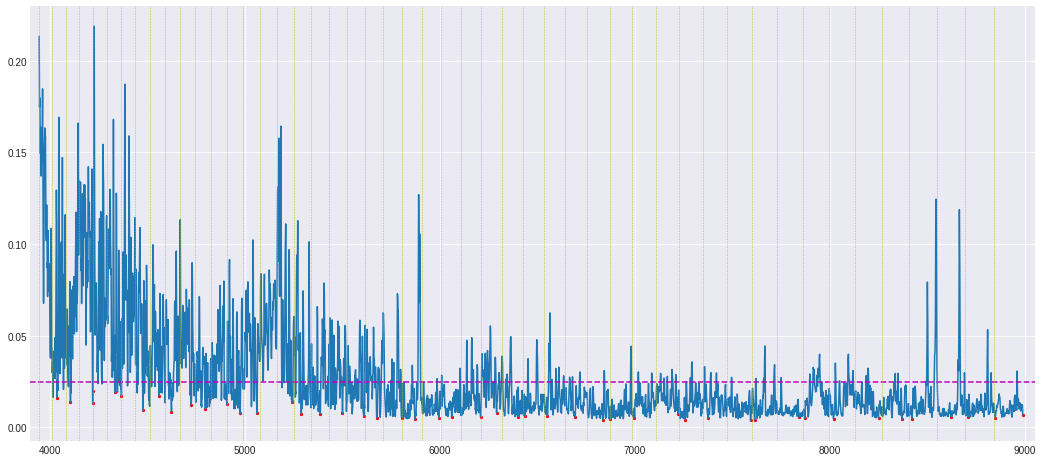

In [43]:
predicted_spectra_std = np.std(predicted_spectra, axis=0)
plt.figure(figsize=(18,8)); plt.xlim(3900, 9050)
plt.plot(wl, predicted_spectra_std)
plt.axhline(y=0.025, ls="--", c="m")
factor = 3577//49
continuum_idxs = []
for i in range(49):
    minargs = np.argsort(predicted_spectra_std[i*factor:(i+1)*factor])[:1] + i*factor
    minargs = minargs[predicted_spectra_std[minargs] < 0.025]
    plt.axvline(x=wl[((i)*factor)], ls="--", c="y", lw=0.5)
    continuum_idxs.extend(minargs)
continuum_idxs.extend( np.argsort(predicted_spectra_std[-15:])[:1] + 49*factor - 15)
continuum_idxs = np.array(continuum_idxs)
plt.scatter(wl[continuum_idxs], predicted_spectra_std[continuum_idxs], c="r", s=5)

# Pseudo-Normalization, Round 2!!

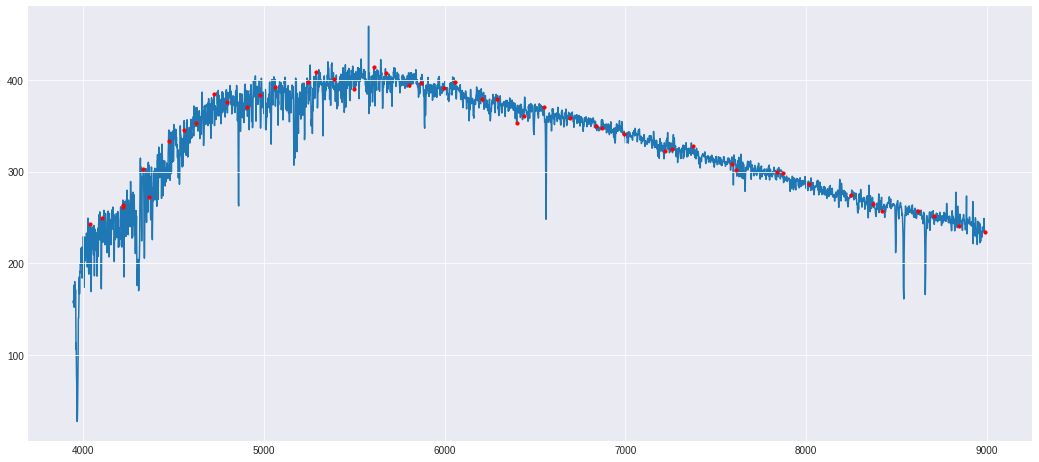

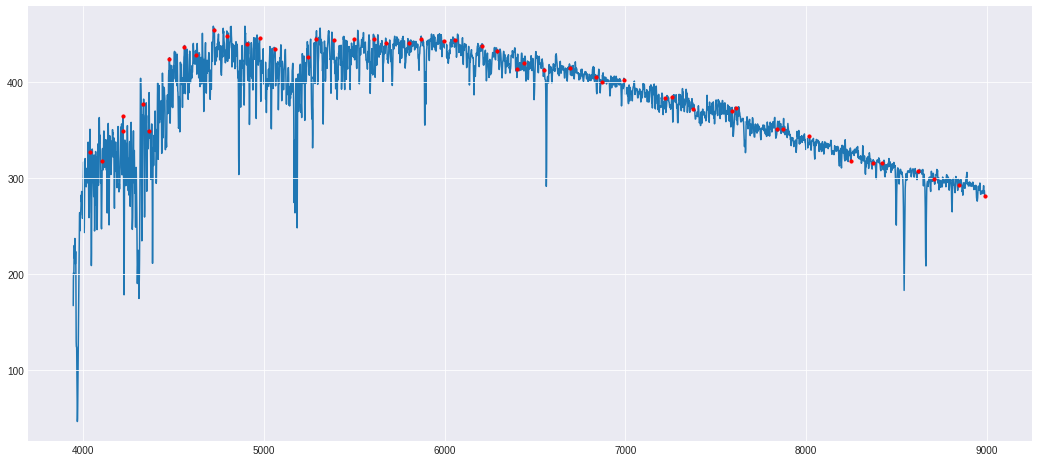

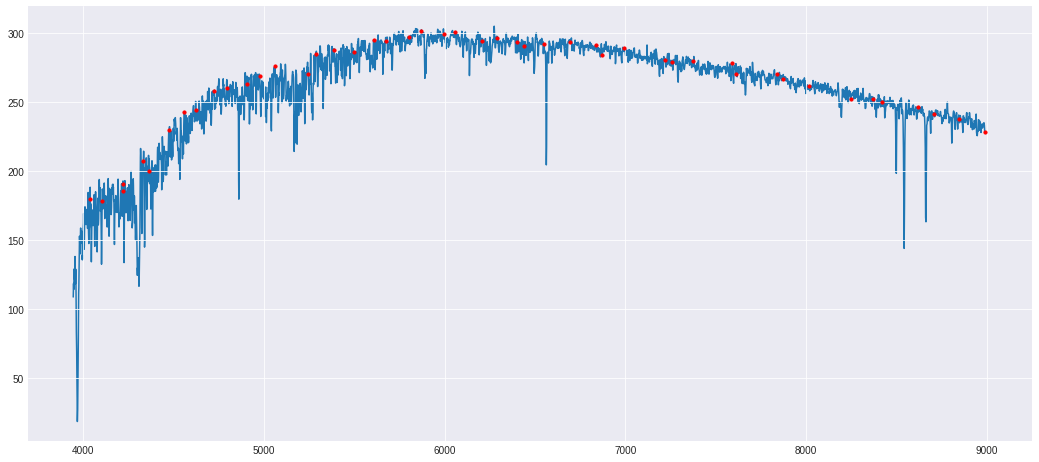

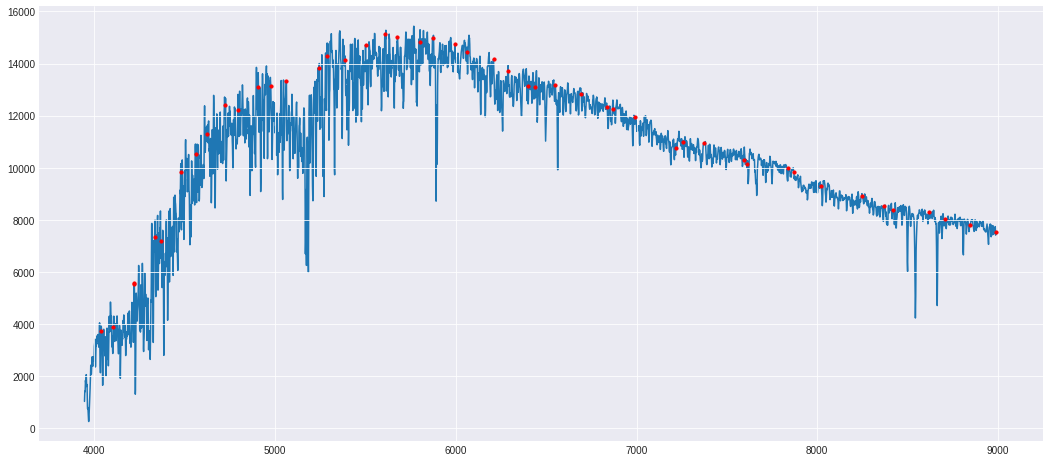

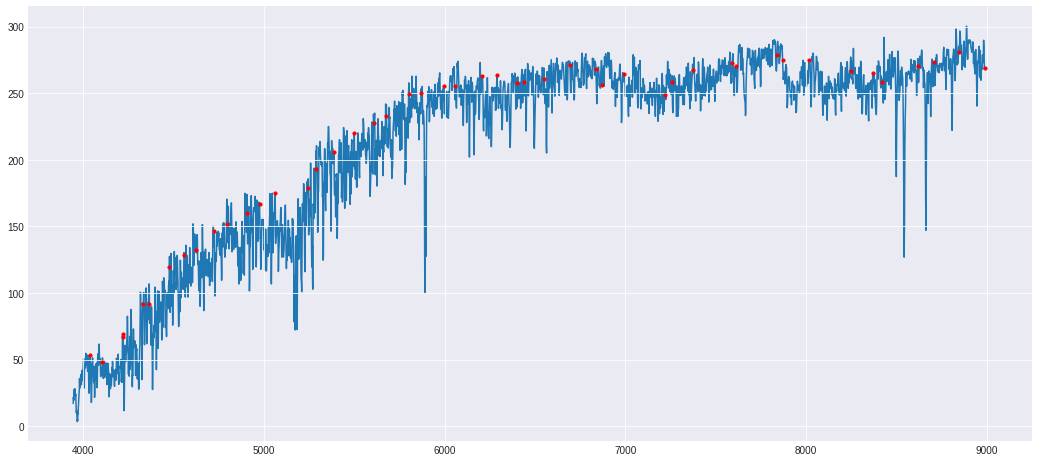

In [44]:
for i in range(5):
    plt.figure(figsize=(18,8))
    j = np.random.randint(0, nr_stars)
    plt.plot(wl, mags[j], zorder=0)
    plt.scatter(wl[continuum_idxs], mags[j][continuum_idxs], c="r", s=10, zorder=1)

In [45]:
# convolution_fit2 = ContinuumFitConvolution(mags[:,continuum_idxs], window_len=10)
# from scipy.interpolate import interp1d
# convolution_fit2 = interp1d(wl[continuum_idxs], convolution_fit2, fill_value="extrapolate")(wl)
# mags_norm_conv1 = mags/convolution_fit2

In [46]:
def ContinuumFit2(wl, mags, continuum_idxs):
    wl_cont = wl.copy()[continuum_idxs]
    mags_cont = mags.copy()[continuum_idxs]
    nr_cont_pixels = continuum_idxs.shape[0]
    split_idx = np.argmin(np.abs(wl[continuum_idxs] - 6500))
    polyfits = np.zeros((nr_stars, nr_cont_pixels))
    wl1, wl2 = np.split(wl, [2168])
    wl1_cont, wl2_cont = np.split(wl_cont, [split_idx])
    for j in trange(nr_stars):
        mag1, mag2 = np.split(mags_cont[j], [split_idx])
        p1 = np.polyfit(wl1_cont, mag1_cont, deg)
        p2 = np.polyfit(wl2_cont, mag2_cont, deg)
        polyfit1 = Polynomial(wl1, p1)
        polyfit2 = Polynomial(wl2, p2)
        for i in range(4):
            w1 = np.ones(len(wl1))
            w2 = np.ones(len(wl2))
            w1[mag1 < polyfit1] = 0.15
            w2[mag2 < polyfit2] = 0.15
            p1 = np.polyfit(wl1_cont, mag1, deg, w=w1)
            p2 = np.polyfit(wl2_cont, mag2, deg, w=w2)
            polyfit1 = Polynomial(wl1, p1)
            polyfit2 = Polynomial(wl2, p2)
        polyfits[j] = np.concatenate((polyfit1, polyfit2), axis=0)
    return polyfits

polyfits2 = ContinuumFit(wl, mags)
mags_norm_poly2 = mags/polyfits
# mags_err_norm2 = mags_err/polyfits

100%|██████████| 422/422 [00:04<00:00, 104.24it/s]


# Neural Net
https://arxiv.org/abs/1609.04836

In [33]:
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
# input_train, input_test, output_train, output_test = train_test_split(mags_norm_poly2, labels, test_size=0.15, random_state=42, shuffle=True)
# nr_train, nr_test = input_train.shape[0], input_test.shape[0]
# print(f"Divided data into training set of {nr_train} objects, and testing set of {nr_test} objects.")
ScalerNN = preprocessing.StandardScaler()
output_train_scaled = ScalerNN.fit_transform(labels)
input_train = mags_norm_poly2.copy()

Divided data into training set of 358 objects, and testing set of 64 objects.


In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(18,8))
for i in range(3):
    ax[0,i].hist(output_train[:,i], bins=40)
    ax[1,i].hist(output_train_scaled[:,i], bins=40)

In [57]:
opti = optimizers.adam(amsgrad=True, lr=0.0001)#, decay=0.01)
def nn_clf():
    model = Sequential()
    model.add(Dense(32, input_shape=(nr_pixels,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(32,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(3, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_absolute_error',  metrics=['mae',"mse"])
    return model
nn_clf().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 32)                114496    
_________________________________________________________________
dense_83 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_84 (Dense)             (None, 3)                 99        
Total params: 115,651
Trainable params: 115,651
Non-trainable params: 0
_________________________________________________________________


# Looking for optimal number of Epochs:

In [59]:
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history = History()
clf = KerasRegressor(build_fn=nn_clf, batch_size=16, epochs=10000, callbacks=[mcp_save, history], validation_split=0.30)
history = clf.fit(input_train, output_train_scaled)

Train on 235 samples, validate on 101 samples
Epoch 1/10000
235/235 [==============================] - 1s 4ms/step - loss: 0.8087 - mean_absolute_error: 0.8087 - mean_squared_error: 1.0034 - val_loss: 0.7979 - val_mean_absolute_error: 0.7979 - val_mean_squared_error: 0.9989
Epoch 2/10000
235/235 [==============================] - 0s 182us/step - loss: 0.8040 - mean_absolute_error: 0.8040 - mean_squared_error: 1.0209 - val_loss: 0.7890 - val_mean_absolute_error: 0.7890 - val_mean_squared_error: 1.0020
Epoch 3/10000
235/235 [==============================] - 0s 201us/step - loss: 0.8016 - mean_absolute_error: 0.8016 - mean_squared_error: 1.0180 - val_loss: 0.7941 - val_mean_absolute_error: 0.7941 - val_mean_squared_error: 0.9977
Epoch 4/10000
235/235 [==============================] - 0s 184us/step - loss: 0.8013 - mean_absolute_error: 0.8013 - mean_squared_error: 1.0156 - val_loss: 0.7867 - val_mean_absolute_error: 0.7867 - val_mean_squared_error: 0.9912
Epoch 5/10000
235/235 [=========

235/235 [==============================] - 0s 217us/step - loss: 0.6527 - mean_absolute_error: 0.6527 - mean_squared_error: 0.7388 - val_loss: 0.5575 - val_mean_absolute_error: 0.5575 - val_mean_squared_error: 0.5379
Epoch 37/10000
235/235 [==============================] - 0s 196us/step - loss: 0.6487 - mean_absolute_error: 0.6487 - mean_squared_error: 0.7360 - val_loss: 0.5435 - val_mean_absolute_error: 0.5435 - val_mean_squared_error: 0.5246
Epoch 38/10000
235/235 [==============================] - 0s 185us/step - loss: 0.6450 - mean_absolute_error: 0.6450 - mean_squared_error: 0.7301 - val_loss: 0.5440 - val_mean_absolute_error: 0.5440 - val_mean_squared_error: 0.5198
Epoch 39/10000
235/235 [==============================] - 0s 200us/step - loss: 0.6407 - mean_absolute_error: 0.6407 - mean_squared_error: 0.7263 - val_loss: 0.5713 - val_mean_absolute_error: 0.5713 - val_mean_squared_error: 0.5489
Epoch 40/10000
235/235 [==============================] - 0s 177us/step - loss: 0.6566 

235/235 [==============================] - 0s 187us/step - loss: 0.6288 - mean_absolute_error: 0.6288 - mean_squared_error: 0.7129 - val_loss: 0.5156 - val_mean_absolute_error: 0.5156 - val_mean_squared_error: 0.4906
Epoch 72/10000
235/235 [==============================] - 0s 193us/step - loss: 0.6278 - mean_absolute_error: 0.6278 - mean_squared_error: 0.7072 - val_loss: 0.5422 - val_mean_absolute_error: 0.5422 - val_mean_squared_error: 0.5075
Epoch 73/10000
235/235 [==============================] - 0s 202us/step - loss: 0.6304 - mean_absolute_error: 0.6304 - mean_squared_error: 0.7057 - val_loss: 0.5266 - val_mean_absolute_error: 0.5266 - val_mean_squared_error: 0.4936
Epoch 74/10000
235/235 [==============================] - 0s 180us/step - loss: 0.6281 - mean_absolute_error: 0.6281 - mean_squared_error: 0.7097 - val_loss: 0.5374 - val_mean_absolute_error: 0.5374 - val_mean_squared_error: 0.5033
Epoch 75/10000
235/235 [==============================] - 0s 179us/step - loss: 0.6274 

235/235 [==============================] - 0s 187us/step - loss: 0.6322 - mean_absolute_error: 0.6322 - mean_squared_error: 0.7074 - val_loss: 0.5155 - val_mean_absolute_error: 0.5155 - val_mean_squared_error: 0.4943
Epoch 107/10000
235/235 [==============================] - 0s 186us/step - loss: 0.6295 - mean_absolute_error: 0.6295 - mean_squared_error: 0.7092 - val_loss: 0.5181 - val_mean_absolute_error: 0.5181 - val_mean_squared_error: 0.4828
Epoch 108/10000
235/235 [==============================] - 0s 184us/step - loss: 0.6260 - mean_absolute_error: 0.6260 - mean_squared_error: 0.7018 - val_loss: 0.5373 - val_mean_absolute_error: 0.5373 - val_mean_squared_error: 0.4976
Epoch 109/10000
235/235 [==============================] - 0s 190us/step - loss: 0.6191 - mean_absolute_error: 0.6191 - mean_squared_error: 0.6933 - val_loss: 0.5122 - val_mean_absolute_error: 0.5122 - val_mean_squared_error: 0.4825
Epoch 110/10000
235/235 [==============================] - 0s 188us/step - loss: 0.6

235/235 [==============================] - 0s 192us/step - loss: 0.6091 - mean_absolute_error: 0.6091 - mean_squared_error: 0.6774 - val_loss: 0.5034 - val_mean_absolute_error: 0.5034 - val_mean_squared_error: 0.4723
Epoch 142/10000
235/235 [==============================] - 0s 190us/step - loss: 0.6172 - mean_absolute_error: 0.6172 - mean_squared_error: 0.6911 - val_loss: 0.5348 - val_mean_absolute_error: 0.5348 - val_mean_squared_error: 0.4898
Epoch 143/10000
235/235 [==============================] - 0s 188us/step - loss: 0.6129 - mean_absolute_error: 0.6129 - mean_squared_error: 0.6860 - val_loss: 0.5414 - val_mean_absolute_error: 0.5414 - val_mean_squared_error: 0.4929
Epoch 144/10000
235/235 [==============================] - 0s 180us/step - loss: 0.6162 - mean_absolute_error: 0.6162 - mean_squared_error: 0.6733 - val_loss: 0.5142 - val_mean_absolute_error: 0.5142 - val_mean_squared_error: 0.4712
Epoch 145/10000
235/235 [==============================] - 0s 176us/step - loss: 0.6

235/235 [==============================] - 0s 177us/step - loss: 0.6001 - mean_absolute_error: 0.6001 - mean_squared_error: 0.6612 - val_loss: 0.5038 - val_mean_absolute_error: 0.5038 - val_mean_squared_error: 0.4526
Epoch 177/10000
235/235 [==============================] - 0s 185us/step - loss: 0.6013 - mean_absolute_error: 0.6013 - mean_squared_error: 0.6670 - val_loss: 0.5133 - val_mean_absolute_error: 0.5133 - val_mean_squared_error: 0.4582
Epoch 178/10000
235/235 [==============================] - 0s 209us/step - loss: 0.6009 - mean_absolute_error: 0.6009 - mean_squared_error: 0.6562 - val_loss: 0.5104 - val_mean_absolute_error: 0.5104 - val_mean_squared_error: 0.4560
Epoch 179/10000
235/235 [==============================] - 0s 192us/step - loss: 0.6034 - mean_absolute_error: 0.6034 - mean_squared_error: 0.6605 - val_loss: 0.4939 - val_mean_absolute_error: 0.4939 - val_mean_squared_error: 0.4501
Epoch 180/10000
235/235 [==============================] - 0s 190us/step - loss: 0.5

235/235 [==============================] - 0s 196us/step - loss: 0.5847 - mean_absolute_error: 0.5847 - mean_squared_error: 0.6320 - val_loss: 0.5015 - val_mean_absolute_error: 0.5015 - val_mean_squared_error: 0.4319
Epoch 212/10000
235/235 [==============================] - 0s 194us/step - loss: 0.5775 - mean_absolute_error: 0.5775 - mean_squared_error: 0.6146 - val_loss: 0.5192 - val_mean_absolute_error: 0.5192 - val_mean_squared_error: 0.4436
Epoch 213/10000
235/235 [==============================] - 0s 182us/step - loss: 0.5734 - mean_absolute_error: 0.5734 - mean_squared_error: 0.6036 - val_loss: 0.4880 - val_mean_absolute_error: 0.4880 - val_mean_squared_error: 0.4208
Epoch 214/10000
235/235 [==============================] - 0s 189us/step - loss: 0.5758 - mean_absolute_error: 0.5758 - mean_squared_error: 0.6112 - val_loss: 0.4861 - val_mean_absolute_error: 0.4861 - val_mean_squared_error: 0.4212
Epoch 215/10000
235/235 [==============================] - 0s 188us/step - loss: 0.5

235/235 [==============================] - 0s 182us/step - loss: 0.5582 - mean_absolute_error: 0.5582 - mean_squared_error: 0.5620 - val_loss: 0.5090 - val_mean_absolute_error: 0.5090 - val_mean_squared_error: 0.4184
Epoch 247/10000
235/235 [==============================] - 0s 191us/step - loss: 0.5433 - mean_absolute_error: 0.5433 - mean_squared_error: 0.5339 - val_loss: 0.4950 - val_mean_absolute_error: 0.4950 - val_mean_squared_error: 0.3964
Epoch 248/10000
235/235 [==============================] - 0s 202us/step - loss: 0.5402 - mean_absolute_error: 0.5402 - mean_squared_error: 0.5312 - val_loss: 0.4665 - val_mean_absolute_error: 0.4665 - val_mean_squared_error: 0.3747
Epoch 249/10000
235/235 [==============================] - 0s 181us/step - loss: 0.5382 - mean_absolute_error: 0.5382 - mean_squared_error: 0.5234 - val_loss: 0.4878 - val_mean_absolute_error: 0.4878 - val_mean_squared_error: 0.4017
Epoch 250/10000
235/235 [==============================] - 0s 188us/step - loss: 0.5

235/235 [==============================] - 0s 178us/step - loss: 0.4950 - mean_absolute_error: 0.4950 - mean_squared_error: 0.4395 - val_loss: 0.4213 - val_mean_absolute_error: 0.4213 - val_mean_squared_error: 0.3128
Epoch 282/10000
235/235 [==============================] - 0s 191us/step - loss: 0.5099 - mean_absolute_error: 0.5099 - mean_squared_error: 0.4500 - val_loss: 0.4932 - val_mean_absolute_error: 0.4932 - val_mean_squared_error: 0.3758
Epoch 283/10000
235/235 [==============================] - 0s 177us/step - loss: 0.5113 - mean_absolute_error: 0.5113 - mean_squared_error: 0.4486 - val_loss: 0.5362 - val_mean_absolute_error: 0.5362 - val_mean_squared_error: 0.4210
Epoch 284/10000
235/235 [==============================] - 0s 184us/step - loss: 0.5052 - mean_absolute_error: 0.5052 - mean_squared_error: 0.4486 - val_loss: 0.4846 - val_mean_absolute_error: 0.4846 - val_mean_squared_error: 0.3598
Epoch 285/10000
235/235 [==============================] - 0s 174us/step - loss: 0.5

235/235 [==============================] - 0s 182us/step - loss: 0.4482 - mean_absolute_error: 0.4482 - mean_squared_error: 0.3542 - val_loss: 0.4499 - val_mean_absolute_error: 0.4499 - val_mean_squared_error: 0.3148
Epoch 317/10000
235/235 [==============================] - 0s 188us/step - loss: 0.4430 - mean_absolute_error: 0.4430 - mean_squared_error: 0.3458 - val_loss: 0.4116 - val_mean_absolute_error: 0.4116 - val_mean_squared_error: 0.2785
Epoch 318/10000
235/235 [==============================] - 0s 190us/step - loss: 0.4408 - mean_absolute_error: 0.4408 - mean_squared_error: 0.3531 - val_loss: 0.4212 - val_mean_absolute_error: 0.4212 - val_mean_squared_error: 0.2866
Epoch 319/10000
235/235 [==============================] - 0s 208us/step - loss: 0.4262 - mean_absolute_error: 0.4262 - mean_squared_error: 0.3334 - val_loss: 0.4045 - val_mean_absolute_error: 0.4045 - val_mean_squared_error: 0.2706
Epoch 320/10000
235/235 [==============================] - 0s 175us/step - loss: 0.4

235/235 [==============================] - 0s 191us/step - loss: 0.4123 - mean_absolute_error: 0.4123 - mean_squared_error: 0.3102 - val_loss: 0.4684 - val_mean_absolute_error: 0.4684 - val_mean_squared_error: 0.3365
Epoch 352/10000
235/235 [==============================] - 0s 189us/step - loss: 0.4192 - mean_absolute_error: 0.4192 - mean_squared_error: 0.3196 - val_loss: 0.4134 - val_mean_absolute_error: 0.4134 - val_mean_squared_error: 0.2729
Epoch 353/10000
235/235 [==============================] - 0s 181us/step - loss: 0.4084 - mean_absolute_error: 0.4084 - mean_squared_error: 0.3034 - val_loss: 0.4061 - val_mean_absolute_error: 0.4061 - val_mean_squared_error: 0.2664
Epoch 354/10000
235/235 [==============================] - 0s 190us/step - loss: 0.3988 - mean_absolute_error: 0.3988 - mean_squared_error: 0.3009 - val_loss: 0.4284 - val_mean_absolute_error: 0.4284 - val_mean_squared_error: 0.2913
Epoch 355/10000
235/235 [==============================] - 0s 191us/step - loss: 0.4

235/235 [==============================] - 0s 190us/step - loss: 0.3874 - mean_absolute_error: 0.3874 - mean_squared_error: 0.2794 - val_loss: 0.3972 - val_mean_absolute_error: 0.3972 - val_mean_squared_error: 0.2550
Epoch 387/10000
235/235 [==============================] - 0s 192us/step - loss: 0.3835 - mean_absolute_error: 0.3835 - mean_squared_error: 0.2750 - val_loss: 0.4023 - val_mean_absolute_error: 0.4023 - val_mean_squared_error: 0.2592
Epoch 388/10000
235/235 [==============================] - 0s 190us/step - loss: 0.3816 - mean_absolute_error: 0.3816 - mean_squared_error: 0.2721 - val_loss: 0.4158 - val_mean_absolute_error: 0.4158 - val_mean_squared_error: 0.2732
Epoch 389/10000
235/235 [==============================] - 0s 188us/step - loss: 0.3939 - mean_absolute_error: 0.3939 - mean_squared_error: 0.2850 - val_loss: 0.3980 - val_mean_absolute_error: 0.3980 - val_mean_squared_error: 0.2546
Epoch 390/10000
235/235 [==============================] - 0s 186us/step - loss: 0.3

235/235 [==============================] - 0s 172us/step - loss: 0.3728 - mean_absolute_error: 0.3728 - mean_squared_error: 0.2627 - val_loss: 0.4249 - val_mean_absolute_error: 0.4249 - val_mean_squared_error: 0.2792
Epoch 422/10000
235/235 [==============================] - 0s 191us/step - loss: 0.3730 - mean_absolute_error: 0.3730 - mean_squared_error: 0.2561 - val_loss: 0.4034 - val_mean_absolute_error: 0.4034 - val_mean_squared_error: 0.2601
Epoch 423/10000
235/235 [==============================] - 0s 179us/step - loss: 0.3696 - mean_absolute_error: 0.3696 - mean_squared_error: 0.2536 - val_loss: 0.4450 - val_mean_absolute_error: 0.4450 - val_mean_squared_error: 0.3132
Epoch 424/10000
235/235 [==============================] - 0s 169us/step - loss: 0.3926 - mean_absolute_error: 0.3926 - mean_squared_error: 0.2809 - val_loss: 0.3954 - val_mean_absolute_error: 0.3954 - val_mean_squared_error: 0.2461
Epoch 425/10000
235/235 [==============================] - 0s 195us/step - loss: 0.3

235/235 [==============================] - 0s 176us/step - loss: 0.3559 - mean_absolute_error: 0.3559 - mean_squared_error: 0.2378 - val_loss: 0.4009 - val_mean_absolute_error: 0.4009 - val_mean_squared_error: 0.2530
Epoch 457/10000
235/235 [==============================] - 0s 183us/step - loss: 0.3579 - mean_absolute_error: 0.3579 - mean_squared_error: 0.2399 - val_loss: 0.3949 - val_mean_absolute_error: 0.3949 - val_mean_squared_error: 0.2444
Epoch 458/10000
235/235 [==============================] - 0s 194us/step - loss: 0.3550 - mean_absolute_error: 0.3550 - mean_squared_error: 0.2385 - val_loss: 0.3910 - val_mean_absolute_error: 0.3910 - val_mean_squared_error: 0.2397
Epoch 459/10000
235/235 [==============================] - 0s 179us/step - loss: 0.3603 - mean_absolute_error: 0.3603 - mean_squared_error: 0.2444 - val_loss: 0.3978 - val_mean_absolute_error: 0.3978 - val_mean_squared_error: 0.2498
Epoch 460/10000
235/235 [==============================] - 0s 184us/step - loss: 0.3

235/235 [==============================] - 0s 182us/step - loss: 0.3860 - mean_absolute_error: 0.3860 - mean_squared_error: 0.2697 - val_loss: 0.4438 - val_mean_absolute_error: 0.4438 - val_mean_squared_error: 0.3097
Epoch 492/10000
235/235 [==============================] - 0s 187us/step - loss: 0.3717 - mean_absolute_error: 0.3717 - mean_squared_error: 0.2506 - val_loss: 0.3914 - val_mean_absolute_error: 0.3914 - val_mean_squared_error: 0.2442
Epoch 493/10000
235/235 [==============================] - 0s 185us/step - loss: 0.3500 - mean_absolute_error: 0.3500 - mean_squared_error: 0.2347 - val_loss: 0.3895 - val_mean_absolute_error: 0.3895 - val_mean_squared_error: 0.2397
Epoch 494/10000
235/235 [==============================] - 0s 194us/step - loss: 0.3503 - mean_absolute_error: 0.3503 - mean_squared_error: 0.2291 - val_loss: 0.3902 - val_mean_absolute_error: 0.3902 - val_mean_squared_error: 0.2381
Epoch 495/10000
235/235 [==============================] - 0s 177us/step - loss: 0.3

235/235 [==============================] - 0s 179us/step - loss: 0.3486 - mean_absolute_error: 0.3486 - mean_squared_error: 0.2323 - val_loss: 0.3876 - val_mean_absolute_error: 0.3876 - val_mean_squared_error: 0.2289
Epoch 527/10000
235/235 [==============================] - 0s 193us/step - loss: 0.3451 - mean_absolute_error: 0.3451 - mean_squared_error: 0.2186 - val_loss: 0.3874 - val_mean_absolute_error: 0.3874 - val_mean_squared_error: 0.2350
Epoch 528/10000
235/235 [==============================] - 0s 195us/step - loss: 0.3405 - mean_absolute_error: 0.3405 - mean_squared_error: 0.2172 - val_loss: 0.3831 - val_mean_absolute_error: 0.3831 - val_mean_squared_error: 0.2273
Epoch 529/10000
235/235 [==============================] - 0s 180us/step - loss: 0.3331 - mean_absolute_error: 0.3331 - mean_squared_error: 0.2155 - val_loss: 0.3822 - val_mean_absolute_error: 0.3822 - val_mean_squared_error: 0.2272
Epoch 530/10000
235/235 [==============================] - 0s 194us/step - loss: 0.3

235/235 [==============================] - 0s 192us/step - loss: 0.3351 - mean_absolute_error: 0.3351 - mean_squared_error: 0.2137 - val_loss: 0.3821 - val_mean_absolute_error: 0.3821 - val_mean_squared_error: 0.2240
Epoch 562/10000
235/235 [==============================] - 0s 200us/step - loss: 0.3392 - mean_absolute_error: 0.3392 - mean_squared_error: 0.2107 - val_loss: 0.3735 - val_mean_absolute_error: 0.3735 - val_mean_squared_error: 0.2176
Epoch 563/10000
235/235 [==============================] - 0s 184us/step - loss: 0.3308 - mean_absolute_error: 0.3308 - mean_squared_error: 0.2087 - val_loss: 0.3996 - val_mean_absolute_error: 0.3996 - val_mean_squared_error: 0.2544
Epoch 564/10000
235/235 [==============================] - 0s 181us/step - loss: 0.3272 - mean_absolute_error: 0.3272 - mean_squared_error: 0.2077 - val_loss: 0.3673 - val_mean_absolute_error: 0.3673 - val_mean_squared_error: 0.2125
Epoch 565/10000
235/235 [==============================] - 0s 196us/step - loss: 0.3

235/235 [==============================] - 0s 184us/step - loss: 0.3192 - mean_absolute_error: 0.3192 - mean_squared_error: 0.1960 - val_loss: 0.3613 - val_mean_absolute_error: 0.3613 - val_mean_squared_error: 0.2057
Epoch 597/10000
235/235 [==============================] - 0s 181us/step - loss: 0.3255 - mean_absolute_error: 0.3255 - mean_squared_error: 0.2032 - val_loss: 0.3998 - val_mean_absolute_error: 0.3998 - val_mean_squared_error: 0.2539
Epoch 598/10000
235/235 [==============================] - 0s 182us/step - loss: 0.3140 - mean_absolute_error: 0.3140 - mean_squared_error: 0.1922 - val_loss: 0.3905 - val_mean_absolute_error: 0.3905 - val_mean_squared_error: 0.2408
Epoch 599/10000
235/235 [==============================] - 0s 197us/step - loss: 0.3238 - mean_absolute_error: 0.3238 - mean_squared_error: 0.1998 - val_loss: 0.3613 - val_mean_absolute_error: 0.3613 - val_mean_squared_error: 0.2051
Epoch 600/10000
235/235 [==============================] - 0s 191us/step - loss: 0.3

235/235 [==============================] - 0s 181us/step - loss: 0.3020 - mean_absolute_error: 0.3020 - mean_squared_error: 0.1806 - val_loss: 0.3519 - val_mean_absolute_error: 0.3519 - val_mean_squared_error: 0.1977
Epoch 632/10000
235/235 [==============================] - 0s 192us/step - loss: 0.3092 - mean_absolute_error: 0.3092 - mean_squared_error: 0.1849 - val_loss: 0.3515 - val_mean_absolute_error: 0.3515 - val_mean_squared_error: 0.1975
Epoch 633/10000
235/235 [==============================] - 0s 186us/step - loss: 0.3126 - mean_absolute_error: 0.3126 - mean_squared_error: 0.1898 - val_loss: 0.3688 - val_mean_absolute_error: 0.3688 - val_mean_squared_error: 0.2138
Epoch 634/10000
235/235 [==============================] - 0s 185us/step - loss: 0.3075 - mean_absolute_error: 0.3075 - mean_squared_error: 0.1851 - val_loss: 0.3581 - val_mean_absolute_error: 0.3581 - val_mean_squared_error: 0.2050
Epoch 635/10000
235/235 [==============================] - 0s 185us/step - loss: 0.3

235/235 [==============================] - 0s 188us/step - loss: 0.3515 - mean_absolute_error: 0.3515 - mean_squared_error: 0.2214 - val_loss: 0.3945 - val_mean_absolute_error: 0.3945 - val_mean_squared_error: 0.2467
Epoch 667/10000
235/235 [==============================] - 0s 200us/step - loss: 0.3380 - mean_absolute_error: 0.3380 - mean_squared_error: 0.2089 - val_loss: 0.3654 - val_mean_absolute_error: 0.3654 - val_mean_squared_error: 0.2106
Epoch 668/10000
235/235 [==============================] - 0s 187us/step - loss: 0.3228 - mean_absolute_error: 0.3228 - mean_squared_error: 0.1980 - val_loss: 0.3557 - val_mean_absolute_error: 0.3557 - val_mean_squared_error: 0.2018
Epoch 669/10000
235/235 [==============================] - 0s 184us/step - loss: 0.3111 - mean_absolute_error: 0.3111 - mean_squared_error: 0.1817 - val_loss: 0.3387 - val_mean_absolute_error: 0.3387 - val_mean_squared_error: 0.1829
Epoch 670/10000
235/235 [==============================] - 0s 184us/step - loss: 0.3

235/235 [==============================] - 0s 194us/step - loss: 0.2881 - mean_absolute_error: 0.2881 - mean_squared_error: 0.1671 - val_loss: 0.3319 - val_mean_absolute_error: 0.3319 - val_mean_squared_error: 0.1767
Epoch 702/10000
235/235 [==============================] - 0s 181us/step - loss: 0.2890 - mean_absolute_error: 0.2890 - mean_squared_error: 0.1641 - val_loss: 0.3327 - val_mean_absolute_error: 0.3327 - val_mean_squared_error: 0.1779
Epoch 703/10000
235/235 [==============================] - 0s 222us/step - loss: 0.2878 - mean_absolute_error: 0.2878 - mean_squared_error: 0.1698 - val_loss: 0.3315 - val_mean_absolute_error: 0.3315 - val_mean_squared_error: 0.1745
Epoch 704/10000
235/235 [==============================] - 0s 237us/step - loss: 0.2907 - mean_absolute_error: 0.2907 - mean_squared_error: 0.1691 - val_loss: 0.3444 - val_mean_absolute_error: 0.3444 - val_mean_squared_error: 0.1908
Epoch 705/10000
235/235 [==============================] - 0s 211us/step - loss: 0.3

235/235 [==============================] - 0s 194us/step - loss: 0.2969 - mean_absolute_error: 0.2969 - mean_squared_error: 0.1757 - val_loss: 0.3322 - val_mean_absolute_error: 0.3322 - val_mean_squared_error: 0.1776
Epoch 737/10000
235/235 [==============================] - 0s 209us/step - loss: 0.3072 - mean_absolute_error: 0.3072 - mean_squared_error: 0.1795 - val_loss: 0.3210 - val_mean_absolute_error: 0.3210 - val_mean_squared_error: 0.1680
Epoch 738/10000
235/235 [==============================] - 0s 193us/step - loss: 0.2906 - mean_absolute_error: 0.2906 - mean_squared_error: 0.1664 - val_loss: 0.3268 - val_mean_absolute_error: 0.3268 - val_mean_squared_error: 0.1702
Epoch 739/10000
235/235 [==============================] - 0s 199us/step - loss: 0.2934 - mean_absolute_error: 0.2934 - mean_squared_error: 0.1763 - val_loss: 0.3238 - val_mean_absolute_error: 0.3238 - val_mean_squared_error: 0.1683
Epoch 740/10000
235/235 [==============================] - 0s 178us/step - loss: 0.2

235/235 [==============================] - 0s 191us/step - loss: 0.2991 - mean_absolute_error: 0.2991 - mean_squared_error: 0.1785 - val_loss: 0.3349 - val_mean_absolute_error: 0.3349 - val_mean_squared_error: 0.1793
Epoch 772/10000
235/235 [==============================] - 0s 199us/step - loss: 0.3183 - mean_absolute_error: 0.3183 - mean_squared_error: 0.1878 - val_loss: 0.3761 - val_mean_absolute_error: 0.3761 - val_mean_squared_error: 0.2244
Epoch 773/10000
235/235 [==============================] - 0s 200us/step - loss: 0.3022 - mean_absolute_error: 0.3022 - mean_squared_error: 0.1767 - val_loss: 0.3291 - val_mean_absolute_error: 0.3291 - val_mean_squared_error: 0.1780
Epoch 774/10000
235/235 [==============================] - 0s 198us/step - loss: 0.3129 - mean_absolute_error: 0.3129 - mean_squared_error: 0.1873 - val_loss: 0.3950 - val_mean_absolute_error: 0.3950 - val_mean_squared_error: 0.2416
Epoch 775/10000
235/235 [==============================] - 0s 205us/step - loss: 0.3

235/235 [==============================] - 0s 194us/step - loss: 0.2774 - mean_absolute_error: 0.2774 - mean_squared_error: 0.1561 - val_loss: 0.3097 - val_mean_absolute_error: 0.3097 - val_mean_squared_error: 0.1560
Epoch 807/10000
235/235 [==============================] - 0s 217us/step - loss: 0.2779 - mean_absolute_error: 0.2779 - mean_squared_error: 0.1602 - val_loss: 0.3557 - val_mean_absolute_error: 0.3557 - val_mean_squared_error: 0.1984
Epoch 808/10000
235/235 [==============================] - 0s 192us/step - loss: 0.3015 - mean_absolute_error: 0.3015 - mean_squared_error: 0.1762 - val_loss: 0.3490 - val_mean_absolute_error: 0.3490 - val_mean_squared_error: 0.1925
Epoch 809/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2806 - mean_absolute_error: 0.2806 - mean_squared_error: 0.1615 - val_loss: 0.3293 - val_mean_absolute_error: 0.3293 - val_mean_squared_error: 0.1744
Epoch 810/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2

235/235 [==============================] - 0s 213us/step - loss: 0.2716 - mean_absolute_error: 0.2716 - mean_squared_error: 0.1530 - val_loss: 0.3098 - val_mean_absolute_error: 0.3098 - val_mean_squared_error: 0.1600
Epoch 842/10000
235/235 [==============================] - 0s 193us/step - loss: 0.2838 - mean_absolute_error: 0.2838 - mean_squared_error: 0.1624 - val_loss: 0.3055 - val_mean_absolute_error: 0.3055 - val_mean_squared_error: 0.1515
Epoch 843/10000
235/235 [==============================] - 0s 202us/step - loss: 0.2738 - mean_absolute_error: 0.2738 - mean_squared_error: 0.1536 - val_loss: 0.3273 - val_mean_absolute_error: 0.3273 - val_mean_squared_error: 0.1749
Epoch 844/10000
235/235 [==============================] - 0s 242us/step - loss: 0.2812 - mean_absolute_error: 0.2812 - mean_squared_error: 0.1576 - val_loss: 0.3062 - val_mean_absolute_error: 0.3062 - val_mean_squared_error: 0.1525
Epoch 845/10000
235/235 [==============================] - 0s 225us/step - loss: 0.2

235/235 [==============================] - 0s 205us/step - loss: 0.2751 - mean_absolute_error: 0.2751 - mean_squared_error: 0.1523 - val_loss: 0.3016 - val_mean_absolute_error: 0.3016 - val_mean_squared_error: 0.1505
Epoch 877/10000
235/235 [==============================] - 0s 212us/step - loss: 0.2700 - mean_absolute_error: 0.2700 - mean_squared_error: 0.1483 - val_loss: 0.3079 - val_mean_absolute_error: 0.3079 - val_mean_squared_error: 0.1544
Epoch 878/10000
235/235 [==============================] - 0s 208us/step - loss: 0.2769 - mean_absolute_error: 0.2769 - mean_squared_error: 0.1570 - val_loss: 0.3893 - val_mean_absolute_error: 0.3893 - val_mean_squared_error: 0.2298
Epoch 879/10000
235/235 [==============================] - 0s 225us/step - loss: 0.2998 - mean_absolute_error: 0.2998 - mean_squared_error: 0.1723 - val_loss: 0.3363 - val_mean_absolute_error: 0.3363 - val_mean_squared_error: 0.1798
Epoch 880/10000
235/235 [==============================] - 0s 228us/step - loss: 0.2

235/235 [==============================] - 0s 230us/step - loss: 0.2684 - mean_absolute_error: 0.2684 - mean_squared_error: 0.1475 - val_loss: 0.2960 - val_mean_absolute_error: 0.2960 - val_mean_squared_error: 0.1451
Epoch 912/10000
235/235 [==============================] - 0s 228us/step - loss: 0.2672 - mean_absolute_error: 0.2672 - mean_squared_error: 0.1481 - val_loss: 0.3934 - val_mean_absolute_error: 0.3934 - val_mean_squared_error: 0.2436
Epoch 913/10000
235/235 [==============================] - 0s 214us/step - loss: 0.3188 - mean_absolute_error: 0.3188 - mean_squared_error: 0.1894 - val_loss: 0.3020 - val_mean_absolute_error: 0.3020 - val_mean_squared_error: 0.1490
Epoch 914/10000
235/235 [==============================] - 0s 182us/step - loss: 0.2837 - mean_absolute_error: 0.2837 - mean_squared_error: 0.1576 - val_loss: 0.3092 - val_mean_absolute_error: 0.3092 - val_mean_squared_error: 0.1598
Epoch 915/10000
235/235 [==============================] - 0s 206us/step - loss: 0.2

235/235 [==============================] - 0s 185us/step - loss: 0.2753 - mean_absolute_error: 0.2753 - mean_squared_error: 0.1541 - val_loss: 0.2942 - val_mean_absolute_error: 0.2942 - val_mean_squared_error: 0.1461
Epoch 947/10000
235/235 [==============================] - 0s 186us/step - loss: 0.2618 - mean_absolute_error: 0.2618 - mean_squared_error: 0.1464 - val_loss: 0.2890 - val_mean_absolute_error: 0.2890 - val_mean_squared_error: 0.1400
Epoch 948/10000
235/235 [==============================] - 0s 178us/step - loss: 0.2627 - mean_absolute_error: 0.2627 - mean_squared_error: 0.1467 - val_loss: 0.3010 - val_mean_absolute_error: 0.3010 - val_mean_squared_error: 0.1480
Epoch 949/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2841 - mean_absolute_error: 0.2841 - mean_squared_error: 0.1594 - val_loss: 0.3240 - val_mean_absolute_error: 0.3240 - val_mean_squared_error: 0.1666
Epoch 950/10000
235/235 [==============================] - 0s 186us/step - loss: 0.2

235/235 [==============================] - 0s 229us/step - loss: 0.3036 - mean_absolute_error: 0.3036 - mean_squared_error: 0.1704 - val_loss: 0.3082 - val_mean_absolute_error: 0.3082 - val_mean_squared_error: 0.1537
Epoch 982/10000
235/235 [==============================] - 0s 209us/step - loss: 0.2928 - mean_absolute_error: 0.2928 - mean_squared_error: 0.1652 - val_loss: 0.2921 - val_mean_absolute_error: 0.2921 - val_mean_squared_error: 0.1408
Epoch 983/10000
235/235 [==============================] - 0s 189us/step - loss: 0.2607 - mean_absolute_error: 0.2607 - mean_squared_error: 0.1439 - val_loss: 0.3199 - val_mean_absolute_error: 0.3199 - val_mean_squared_error: 0.1640
Epoch 984/10000
235/235 [==============================] - 0s 181us/step - loss: 0.2592 - mean_absolute_error: 0.2592 - mean_squared_error: 0.1384 - val_loss: 0.3114 - val_mean_absolute_error: 0.3114 - val_mean_squared_error: 0.1571
Epoch 985/10000
235/235 [==============================] - 0s 191us/step - loss: 0.2

235/235 [==============================] - 0s 200us/step - loss: 0.2577 - mean_absolute_error: 0.2577 - mean_squared_error: 0.1396 - val_loss: 0.3000 - val_mean_absolute_error: 0.3000 - val_mean_squared_error: 0.1487
Epoch 1017/10000
235/235 [==============================] - 0s 213us/step - loss: 0.2571 - mean_absolute_error: 0.2571 - mean_squared_error: 0.1414 - val_loss: 0.2858 - val_mean_absolute_error: 0.2858 - val_mean_squared_error: 0.1350
Epoch 1018/10000
235/235 [==============================] - 0s 208us/step - loss: 0.2667 - mean_absolute_error: 0.2667 - mean_squared_error: 0.1496 - val_loss: 0.3002 - val_mean_absolute_error: 0.3002 - val_mean_squared_error: 0.1477
Epoch 1019/10000
235/235 [==============================] - 0s 213us/step - loss: 0.2681 - mean_absolute_error: 0.2681 - mean_squared_error: 0.1473 - val_loss: 0.2975 - val_mean_absolute_error: 0.2975 - val_mean_squared_error: 0.1457
Epoch 1020/10000
235/235 [==============================] - 0s 215us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.2735 - mean_absolute_error: 0.2735 - mean_squared_error: 0.1478 - val_loss: 0.2832 - val_mean_absolute_error: 0.2832 - val_mean_squared_error: 0.1313
Epoch 1052/10000
235/235 [==============================] - 0s 182us/step - loss: 0.2599 - mean_absolute_error: 0.2599 - mean_squared_error: 0.1398 - val_loss: 0.3128 - val_mean_absolute_error: 0.3128 - val_mean_squared_error: 0.1538
Epoch 1053/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2664 - mean_absolute_error: 0.2664 - mean_squared_error: 0.1497 - val_loss: 0.2913 - val_mean_absolute_error: 0.2913 - val_mean_squared_error: 0.1370
Epoch 1054/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2692 - mean_absolute_error: 0.2692 - mean_squared_error: 0.1482 - val_loss: 0.2879 - val_mean_absolute_error: 0.2879 - val_mean_squared_error: 0.1368
Epoch 1055/10000
235/235 [==============================] - 0s 175us/step - loss:

235/235 [==============================] - 0s 183us/step - loss: 0.2618 - mean_absolute_error: 0.2618 - mean_squared_error: 0.1411 - val_loss: 0.3285 - val_mean_absolute_error: 0.3285 - val_mean_squared_error: 0.1684
Epoch 1087/10000
235/235 [==============================] - 0s 185us/step - loss: 0.2716 - mean_absolute_error: 0.2716 - mean_squared_error: 0.1472 - val_loss: 0.2829 - val_mean_absolute_error: 0.2829 - val_mean_squared_error: 0.1333
Epoch 1088/10000
235/235 [==============================] - 0s 186us/step - loss: 0.2605 - mean_absolute_error: 0.2605 - mean_squared_error: 0.1410 - val_loss: 0.2800 - val_mean_absolute_error: 0.2800 - val_mean_squared_error: 0.1280
Epoch 1089/10000
235/235 [==============================] - 0s 177us/step - loss: 0.2737 - mean_absolute_error: 0.2737 - mean_squared_error: 0.1531 - val_loss: 0.3185 - val_mean_absolute_error: 0.3185 - val_mean_squared_error: 0.1551
Epoch 1090/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 189us/step - loss: 0.2719 - mean_absolute_error: 0.2719 - mean_squared_error: 0.1475 - val_loss: 0.2982 - val_mean_absolute_error: 0.2982 - val_mean_squared_error: 0.1463
Epoch 1122/10000
235/235 [==============================] - 0s 192us/step - loss: 0.2633 - mean_absolute_error: 0.2633 - mean_squared_error: 0.1415 - val_loss: 0.2939 - val_mean_absolute_error: 0.2939 - val_mean_squared_error: 0.1389
Epoch 1123/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2506 - mean_absolute_error: 0.2506 - mean_squared_error: 0.1328 - val_loss: 0.3000 - val_mean_absolute_error: 0.3000 - val_mean_squared_error: 0.1441
Epoch 1124/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2490 - mean_absolute_error: 0.2490 - mean_squared_error: 0.1326 - val_loss: 0.2772 - val_mean_absolute_error: 0.2772 - val_mean_squared_error: 0.1294
Epoch 1125/10000
235/235 [==============================] - 0s 195us/step - loss:

235/235 [==============================] - 0s 179us/step - loss: 0.2706 - mean_absolute_error: 0.2706 - mean_squared_error: 0.1474 - val_loss: 0.2760 - val_mean_absolute_error: 0.2760 - val_mean_squared_error: 0.1251
Epoch 1157/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2609 - mean_absolute_error: 0.2609 - mean_squared_error: 0.1402 - val_loss: 0.2749 - val_mean_absolute_error: 0.2749 - val_mean_squared_error: 0.1248
Epoch 1158/10000
235/235 [==============================] - 0s 180us/step - loss: 0.2574 - mean_absolute_error: 0.2574 - mean_squared_error: 0.1411 - val_loss: 0.2981 - val_mean_absolute_error: 0.2981 - val_mean_squared_error: 0.1460
Epoch 1159/10000
235/235 [==============================] - 0s 173us/step - loss: 0.2653 - mean_absolute_error: 0.2653 - mean_squared_error: 0.1441 - val_loss: 0.3021 - val_mean_absolute_error: 0.3021 - val_mean_squared_error: 0.1499
Epoch 1160/10000
235/235 [==============================] - 0s 195us/step - loss:

235/235 [==============================] - 0s 213us/step - loss: 0.2559 - mean_absolute_error: 0.2559 - mean_squared_error: 0.1361 - val_loss: 0.2748 - val_mean_absolute_error: 0.2748 - val_mean_squared_error: 0.1278
Epoch 1192/10000
235/235 [==============================] - 0s 209us/step - loss: 0.2455 - mean_absolute_error: 0.2455 - mean_squared_error: 0.1293 - val_loss: 0.2778 - val_mean_absolute_error: 0.2778 - val_mean_squared_error: 0.1296
Epoch 1193/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2595 - mean_absolute_error: 0.2595 - mean_squared_error: 0.1419 - val_loss: 0.2909 - val_mean_absolute_error: 0.2909 - val_mean_squared_error: 0.1358
Epoch 1194/10000
235/235 [==============================] - 0s 191us/step - loss: 0.2709 - mean_absolute_error: 0.2709 - mean_squared_error: 0.1441 - val_loss: 0.2964 - val_mean_absolute_error: 0.2964 - val_mean_squared_error: 0.1402
Epoch 1195/10000
235/235 [==============================] - 0s 183us/step - loss:

235/235 [==============================] - 0s 222us/step - loss: 0.2774 - mean_absolute_error: 0.2774 - mean_squared_error: 0.1537 - val_loss: 0.2866 - val_mean_absolute_error: 0.2866 - val_mean_squared_error: 0.1345
Epoch 1227/10000
235/235 [==============================] - 0s 208us/step - loss: 0.2473 - mean_absolute_error: 0.2473 - mean_squared_error: 0.1280 - val_loss: 0.2707 - val_mean_absolute_error: 0.2707 - val_mean_squared_error: 0.1231
Epoch 1228/10000
235/235 [==============================] - 0s 218us/step - loss: 0.2595 - mean_absolute_error: 0.2595 - mean_squared_error: 0.1406 - val_loss: 0.2753 - val_mean_absolute_error: 0.2753 - val_mean_squared_error: 0.1266
Epoch 1229/10000
235/235 [==============================] - 0s 227us/step - loss: 0.2519 - mean_absolute_error: 0.2519 - mean_squared_error: 0.1357 - val_loss: 0.2834 - val_mean_absolute_error: 0.2834 - val_mean_squared_error: 0.1314
Epoch 1230/10000
235/235 [==============================] - 0s 199us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.2439 - mean_absolute_error: 0.2439 - mean_squared_error: 0.1247 - val_loss: 0.2753 - val_mean_absolute_error: 0.2753 - val_mean_squared_error: 0.1276
Epoch 1262/10000
235/235 [==============================] - 0s 192us/step - loss: 0.2384 - mean_absolute_error: 0.2384 - mean_squared_error: 0.1238 - val_loss: 0.2708 - val_mean_absolute_error: 0.2708 - val_mean_squared_error: 0.1238
Epoch 1263/10000
235/235 [==============================] - 0s 198us/step - loss: 0.2558 - mean_absolute_error: 0.2558 - mean_squared_error: 0.1314 - val_loss: 0.3246 - val_mean_absolute_error: 0.3246 - val_mean_squared_error: 0.1701
Epoch 1264/10000
235/235 [==============================] - 0s 200us/step - loss: 0.2904 - mean_absolute_error: 0.2904 - mean_squared_error: 0.1568 - val_loss: 0.2886 - val_mean_absolute_error: 0.2886 - val_mean_squared_error: 0.1398
Epoch 1265/10000
235/235 [==============================] - 0s 190us/step - loss:

235/235 [==============================] - 0s 205us/step - loss: 0.2410 - mean_absolute_error: 0.2410 - mean_squared_error: 0.1275 - val_loss: 0.2716 - val_mean_absolute_error: 0.2716 - val_mean_squared_error: 0.1210
Epoch 1297/10000
235/235 [==============================] - 0s 208us/step - loss: 0.2370 - mean_absolute_error: 0.2370 - mean_squared_error: 0.1240 - val_loss: 0.2717 - val_mean_absolute_error: 0.2717 - val_mean_squared_error: 0.1216
Epoch 1298/10000
235/235 [==============================] - 0s 196us/step - loss: 0.2380 - mean_absolute_error: 0.2380 - mean_squared_error: 0.1253 - val_loss: 0.2687 - val_mean_absolute_error: 0.2687 - val_mean_squared_error: 0.1203
Epoch 1299/10000
235/235 [==============================] - 0s 198us/step - loss: 0.2428 - mean_absolute_error: 0.2428 - mean_squared_error: 0.1274 - val_loss: 0.2846 - val_mean_absolute_error: 0.2846 - val_mean_squared_error: 0.1288
Epoch 1300/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 181us/step - loss: 0.2362 - mean_absolute_error: 0.2362 - mean_squared_error: 0.1223 - val_loss: 0.2655 - val_mean_absolute_error: 0.2655 - val_mean_squared_error: 0.1173
Epoch 1332/10000
235/235 [==============================] - 0s 197us/step - loss: 0.2358 - mean_absolute_error: 0.2358 - mean_squared_error: 0.1221 - val_loss: 0.2784 - val_mean_absolute_error: 0.2784 - val_mean_squared_error: 0.1304
Epoch 1333/10000
235/235 [==============================] - 0s 189us/step - loss: 0.2533 - mean_absolute_error: 0.2533 - mean_squared_error: 0.1340 - val_loss: 0.2654 - val_mean_absolute_error: 0.2654 - val_mean_squared_error: 0.1179
Epoch 1334/10000
235/235 [==============================] - 0s 181us/step - loss: 0.2435 - mean_absolute_error: 0.2435 - mean_squared_error: 0.1262 - val_loss: 0.2700 - val_mean_absolute_error: 0.2700 - val_mean_squared_error: 0.1198
Epoch 1335/10000
235/235 [==============================] - 0s 188us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.2809 - mean_absolute_error: 0.2809 - mean_squared_error: 0.1528 - val_loss: 0.3282 - val_mean_absolute_error: 0.3282 - val_mean_squared_error: 0.1649
Epoch 1367/10000
235/235 [==============================] - 0s 202us/step - loss: 0.2612 - mean_absolute_error: 0.2612 - mean_squared_error: 0.1380 - val_loss: 0.3031 - val_mean_absolute_error: 0.3031 - val_mean_squared_error: 0.1430
Epoch 1368/10000
235/235 [==============================] - 0s 201us/step - loss: 0.2574 - mean_absolute_error: 0.2574 - mean_squared_error: 0.1311 - val_loss: 0.3269 - val_mean_absolute_error: 0.3269 - val_mean_squared_error: 0.1603
Epoch 1369/10000
235/235 [==============================] - 0s 183us/step - loss: 0.2712 - mean_absolute_error: 0.2712 - mean_squared_error: 0.1437 - val_loss: 0.3097 - val_mean_absolute_error: 0.3097 - val_mean_squared_error: 0.1492
Epoch 1370/10000
235/235 [==============================] - 0s 192us/step - loss:

235/235 [==============================] - 0s 214us/step - loss: 0.2396 - mean_absolute_error: 0.2396 - mean_squared_error: 0.1243 - val_loss: 0.2732 - val_mean_absolute_error: 0.2732 - val_mean_squared_error: 0.1225
Epoch 1402/10000
235/235 [==============================] - 0s 207us/step - loss: 0.2330 - mean_absolute_error: 0.2330 - mean_squared_error: 0.1196 - val_loss: 0.2652 - val_mean_absolute_error: 0.2652 - val_mean_squared_error: 0.1184
Epoch 1403/10000
235/235 [==============================] - 0s 194us/step - loss: 0.2314 - mean_absolute_error: 0.2314 - mean_squared_error: 0.1189 - val_loss: 0.2832 - val_mean_absolute_error: 0.2832 - val_mean_squared_error: 0.1345
Epoch 1404/10000
235/235 [==============================] - 0s 182us/step - loss: 0.2384 - mean_absolute_error: 0.2384 - mean_squared_error: 0.1238 - val_loss: 0.2663 - val_mean_absolute_error: 0.2663 - val_mean_squared_error: 0.1188
Epoch 1405/10000
235/235 [==============================] - 0s 167us/step - loss:

235/235 [==============================] - 0s 197us/step - loss: 0.2548 - mean_absolute_error: 0.2548 - mean_squared_error: 0.1306 - val_loss: 0.2640 - val_mean_absolute_error: 0.2640 - val_mean_squared_error: 0.1171
Epoch 1437/10000
235/235 [==============================] - 0s 185us/step - loss: 0.2419 - mean_absolute_error: 0.2419 - mean_squared_error: 0.1221 - val_loss: 0.2717 - val_mean_absolute_error: 0.2717 - val_mean_squared_error: 0.1233
Epoch 1438/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2378 - mean_absolute_error: 0.2378 - mean_squared_error: 0.1240 - val_loss: 0.2671 - val_mean_absolute_error: 0.2671 - val_mean_squared_error: 0.1183
Epoch 1439/10000
235/235 [==============================] - 0s 202us/step - loss: 0.2461 - mean_absolute_error: 0.2461 - mean_squared_error: 0.1295 - val_loss: 0.2765 - val_mean_absolute_error: 0.2765 - val_mean_squared_error: 0.1281
Epoch 1440/10000
235/235 [==============================] - 0s 181us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.2366 - mean_absolute_error: 0.2366 - mean_squared_error: 0.1217 - val_loss: 0.2612 - val_mean_absolute_error: 0.2612 - val_mean_squared_error: 0.1152
Epoch 1472/10000
235/235 [==============================] - 0s 198us/step - loss: 0.2373 - mean_absolute_error: 0.2373 - mean_squared_error: 0.1195 - val_loss: 0.2653 - val_mean_absolute_error: 0.2653 - val_mean_squared_error: 0.1159
Epoch 1473/10000
235/235 [==============================] - 0s 220us/step - loss: 0.2640 - mean_absolute_error: 0.2640 - mean_squared_error: 0.1391 - val_loss: 0.2947 - val_mean_absolute_error: 0.2947 - val_mean_squared_error: 0.1450
Epoch 1474/10000
235/235 [==============================] - 0s 189us/step - loss: 0.2708 - mean_absolute_error: 0.2708 - mean_squared_error: 0.1438 - val_loss: 0.2662 - val_mean_absolute_error: 0.2662 - val_mean_squared_error: 0.1185
Epoch 1475/10000
235/235 [==============================] - 0s 195us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.2463 - mean_absolute_error: 0.2463 - mean_squared_error: 0.1249 - val_loss: 0.2632 - val_mean_absolute_error: 0.2632 - val_mean_squared_error: 0.1166
Epoch 1507/10000
235/235 [==============================] - 0s 186us/step - loss: 0.2358 - mean_absolute_error: 0.2358 - mean_squared_error: 0.1202 - val_loss: 0.2639 - val_mean_absolute_error: 0.2639 - val_mean_squared_error: 0.1166
Epoch 1508/10000
235/235 [==============================] - 0s 202us/step - loss: 0.2517 - mean_absolute_error: 0.2517 - mean_squared_error: 0.1295 - val_loss: 0.2785 - val_mean_absolute_error: 0.2785 - val_mean_squared_error: 0.1300
Epoch 1509/10000
235/235 [==============================] - 0s 185us/step - loss: 0.2336 - mean_absolute_error: 0.2336 - mean_squared_error: 0.1201 - val_loss: 0.2661 - val_mean_absolute_error: 0.2661 - val_mean_squared_error: 0.1197
Epoch 1510/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 199us/step - loss: 0.2494 - mean_absolute_error: 0.2494 - mean_squared_error: 0.1323 - val_loss: 0.2662 - val_mean_absolute_error: 0.2662 - val_mean_squared_error: 0.1196
Epoch 1542/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2423 - mean_absolute_error: 0.2423 - mean_squared_error: 0.1210 - val_loss: 0.2607 - val_mean_absolute_error: 0.2607 - val_mean_squared_error: 0.1142
Epoch 1543/10000
235/235 [==============================] - 0s 192us/step - loss: 0.2335 - mean_absolute_error: 0.2335 - mean_squared_error: 0.1170 - val_loss: 0.2616 - val_mean_absolute_error: 0.2616 - val_mean_squared_error: 0.1154
Epoch 1544/10000
235/235 [==============================] - 0s 181us/step - loss: 0.2365 - mean_absolute_error: 0.2365 - mean_squared_error: 0.1219 - val_loss: 0.2775 - val_mean_absolute_error: 0.2775 - val_mean_squared_error: 0.1209
Epoch 1545/10000
235/235 [==============================] - 0s 180us/step - loss:

235/235 [==============================] - 0s 192us/step - loss: 0.2274 - mean_absolute_error: 0.2274 - mean_squared_error: 0.1136 - val_loss: 0.2814 - val_mean_absolute_error: 0.2814 - val_mean_squared_error: 0.1241
Epoch 1577/10000
235/235 [==============================] - 0s 192us/step - loss: 0.2506 - mean_absolute_error: 0.2506 - mean_squared_error: 0.1309 - val_loss: 0.2641 - val_mean_absolute_error: 0.2641 - val_mean_squared_error: 0.1145
Epoch 1578/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2540 - mean_absolute_error: 0.2540 - mean_squared_error: 0.1309 - val_loss: 0.2610 - val_mean_absolute_error: 0.2610 - val_mean_squared_error: 0.1150
Epoch 1579/10000
235/235 [==============================] - 0s 194us/step - loss: 0.2330 - mean_absolute_error: 0.2330 - mean_squared_error: 0.1198 - val_loss: 0.2629 - val_mean_absolute_error: 0.2629 - val_mean_squared_error: 0.1157
Epoch 1580/10000
235/235 [==============================] - 0s 204us/step - loss:

235/235 [==============================] - 0s 183us/step - loss: 0.2352 - mean_absolute_error: 0.2352 - mean_squared_error: 0.1211 - val_loss: 0.2671 - val_mean_absolute_error: 0.2671 - val_mean_squared_error: 0.1181
Epoch 1612/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2387 - mean_absolute_error: 0.2387 - mean_squared_error: 0.1182 - val_loss: 0.2655 - val_mean_absolute_error: 0.2655 - val_mean_squared_error: 0.1157
Epoch 1613/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2703 - mean_absolute_error: 0.2703 - mean_squared_error: 0.1409 - val_loss: 0.3484 - val_mean_absolute_error: 0.3484 - val_mean_squared_error: 0.1836
Epoch 1614/10000
235/235 [==============================] - 0s 193us/step - loss: 0.2478 - mean_absolute_error: 0.2478 - mean_squared_error: 0.1320 - val_loss: 0.2594 - val_mean_absolute_error: 0.2594 - val_mean_squared_error: 0.1128
Epoch 1615/10000
235/235 [==============================] - 0s 193us/step - loss:

235/235 [==============================] - 0s 180us/step - loss: 0.2526 - mean_absolute_error: 0.2526 - mean_squared_error: 0.1375 - val_loss: 0.2979 - val_mean_absolute_error: 0.2979 - val_mean_squared_error: 0.1440
Epoch 1647/10000
235/235 [==============================] - 0s 183us/step - loss: 0.2537 - mean_absolute_error: 0.2537 - mean_squared_error: 0.1310 - val_loss: 0.2607 - val_mean_absolute_error: 0.2607 - val_mean_squared_error: 0.1138
Epoch 1648/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2374 - mean_absolute_error: 0.2374 - mean_squared_error: 0.1195 - val_loss: 0.2639 - val_mean_absolute_error: 0.2639 - val_mean_squared_error: 0.1158
Epoch 1649/10000
235/235 [==============================] - 0s 207us/step - loss: 0.2410 - mean_absolute_error: 0.2410 - mean_squared_error: 0.1207 - val_loss: 0.2824 - val_mean_absolute_error: 0.2824 - val_mean_squared_error: 0.1272
Epoch 1650/10000
235/235 [==============================] - 0s 188us/step - loss:

235/235 [==============================] - 0s 182us/step - loss: 0.2485 - mean_absolute_error: 0.2485 - mean_squared_error: 0.1277 - val_loss: 0.2647 - val_mean_absolute_error: 0.2647 - val_mean_squared_error: 0.1165
Epoch 1682/10000
235/235 [==============================] - 0s 177us/step - loss: 0.2457 - mean_absolute_error: 0.2457 - mean_squared_error: 0.1186 - val_loss: 0.2628 - val_mean_absolute_error: 0.2628 - val_mean_squared_error: 0.1153
Epoch 1683/10000
235/235 [==============================] - 0s 191us/step - loss: 0.2525 - mean_absolute_error: 0.2525 - mean_squared_error: 0.1261 - val_loss: 0.2579 - val_mean_absolute_error: 0.2579 - val_mean_squared_error: 0.1131
Epoch 1684/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2258 - mean_absolute_error: 0.2258 - mean_squared_error: 0.1152 - val_loss: 0.2652 - val_mean_absolute_error: 0.2652 - val_mean_squared_error: 0.1156
Epoch 1685/10000
235/235 [==============================] - 0s 176us/step - loss:

235/235 [==============================] - 0s 201us/step - loss: 0.3190 - mean_absolute_error: 0.3190 - mean_squared_error: 0.1839 - val_loss: 0.3454 - val_mean_absolute_error: 0.3454 - val_mean_squared_error: 0.1872
Epoch 1717/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2850 - mean_absolute_error: 0.2850 - mean_squared_error: 0.1505 - val_loss: 0.2800 - val_mean_absolute_error: 0.2800 - val_mean_squared_error: 0.1303
Epoch 1718/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2552 - mean_absolute_error: 0.2552 - mean_squared_error: 0.1315 - val_loss: 0.2595 - val_mean_absolute_error: 0.2595 - val_mean_squared_error: 0.1146
Epoch 1719/10000
235/235 [==============================] - 0s 191us/step - loss: 0.2239 - mean_absolute_error: 0.2239 - mean_squared_error: 0.1106 - val_loss: 0.2601 - val_mean_absolute_error: 0.2601 - val_mean_squared_error: 0.1141
Epoch 1720/10000
235/235 [==============================] - 0s 180us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.2229 - mean_absolute_error: 0.2229 - mean_squared_error: 0.1114 - val_loss: 0.2691 - val_mean_absolute_error: 0.2691 - val_mean_squared_error: 0.1220
Epoch 1752/10000
235/235 [==============================] - 0s 185us/step - loss: 0.2315 - mean_absolute_error: 0.2315 - mean_squared_error: 0.1177 - val_loss: 0.2708 - val_mean_absolute_error: 0.2708 - val_mean_squared_error: 0.1229
Epoch 1753/10000
235/235 [==============================] - 0s 193us/step - loss: 0.2249 - mean_absolute_error: 0.2249 - mean_squared_error: 0.1146 - val_loss: 0.2668 - val_mean_absolute_error: 0.2668 - val_mean_squared_error: 0.1157
Epoch 1754/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2259 - mean_absolute_error: 0.2259 - mean_squared_error: 0.1105 - val_loss: 0.2628 - val_mean_absolute_error: 0.2628 - val_mean_squared_error: 0.1165
Epoch 1755/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 184us/step - loss: 0.2370 - mean_absolute_error: 0.2370 - mean_squared_error: 0.1191 - val_loss: 0.2679 - val_mean_absolute_error: 0.2679 - val_mean_squared_error: 0.1169
Epoch 1787/10000
235/235 [==============================] - 0s 194us/step - loss: 0.2359 - mean_absolute_error: 0.2359 - mean_squared_error: 0.1167 - val_loss: 0.2757 - val_mean_absolute_error: 0.2757 - val_mean_squared_error: 0.1225
Epoch 1788/10000
235/235 [==============================] - 0s 202us/step - loss: 0.2360 - mean_absolute_error: 0.2360 - mean_squared_error: 0.1172 - val_loss: 0.2928 - val_mean_absolute_error: 0.2928 - val_mean_squared_error: 0.1347
Epoch 1789/10000
235/235 [==============================] - 0s 189us/step - loss: 0.2407 - mean_absolute_error: 0.2407 - mean_squared_error: 0.1179 - val_loss: 0.2609 - val_mean_absolute_error: 0.2609 - val_mean_squared_error: 0.1130
Epoch 1790/10000
235/235 [==============================] - 0s 193us/step - loss:

235/235 [==============================] - 0s 184us/step - loss: 0.2167 - mean_absolute_error: 0.2167 - mean_squared_error: 0.1079 - val_loss: 0.2573 - val_mean_absolute_error: 0.2573 - val_mean_squared_error: 0.1117
Epoch 1822/10000
235/235 [==============================] - 0s 183us/step - loss: 0.2161 - mean_absolute_error: 0.2161 - mean_squared_error: 0.1079 - val_loss: 0.2594 - val_mean_absolute_error: 0.2594 - val_mean_squared_error: 0.1111
Epoch 1823/10000
235/235 [==============================] - 0s 172us/step - loss: 0.2198 - mean_absolute_error: 0.2198 - mean_squared_error: 0.1083 - val_loss: 0.2583 - val_mean_absolute_error: 0.2583 - val_mean_squared_error: 0.1107
Epoch 1824/10000
235/235 [==============================] - 0s 189us/step - loss: 0.2363 - mean_absolute_error: 0.2363 - mean_squared_error: 0.1153 - val_loss: 0.2594 - val_mean_absolute_error: 0.2594 - val_mean_squared_error: 0.1128
Epoch 1825/10000
235/235 [==============================] - 0s 191us/step - loss:

235/235 [==============================] - 0s 198us/step - loss: 0.2321 - mean_absolute_error: 0.2321 - mean_squared_error: 0.1147 - val_loss: 0.2720 - val_mean_absolute_error: 0.2720 - val_mean_squared_error: 0.1183
Epoch 1857/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2287 - mean_absolute_error: 0.2287 - mean_squared_error: 0.1128 - val_loss: 0.2581 - val_mean_absolute_error: 0.2581 - val_mean_squared_error: 0.1106
Epoch 1858/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2174 - mean_absolute_error: 0.2174 - mean_squared_error: 0.1058 - val_loss: 0.2589 - val_mean_absolute_error: 0.2589 - val_mean_squared_error: 0.1116
Epoch 1859/10000
235/235 [==============================] - 0s 185us/step - loss: 0.2140 - mean_absolute_error: 0.2140 - mean_squared_error: 0.1050 - val_loss: 0.2610 - val_mean_absolute_error: 0.2610 - val_mean_squared_error: 0.1146
Epoch 1860/10000
235/235 [==============================] - 0s 179us/step - loss:

235/235 [==============================] - 0s 178us/step - loss: 0.2154 - mean_absolute_error: 0.2154 - mean_squared_error: 0.1059 - val_loss: 0.2580 - val_mean_absolute_error: 0.2580 - val_mean_squared_error: 0.1120
Epoch 1892/10000
235/235 [==============================] - 0s 182us/step - loss: 0.2163 - mean_absolute_error: 0.2163 - mean_squared_error: 0.1064 - val_loss: 0.2558 - val_mean_absolute_error: 0.2558 - val_mean_squared_error: 0.1103
Epoch 1893/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2229 - mean_absolute_error: 0.2229 - mean_squared_error: 0.1113 - val_loss: 0.2557 - val_mean_absolute_error: 0.2557 - val_mean_squared_error: 0.1104
Epoch 1894/10000
235/235 [==============================] - 0s 195us/step - loss: 0.2289 - mean_absolute_error: 0.2289 - mean_squared_error: 0.1109 - val_loss: 0.2574 - val_mean_absolute_error: 0.2574 - val_mean_squared_error: 0.1110
Epoch 1895/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 203us/step - loss: 0.2170 - mean_absolute_error: 0.2170 - mean_squared_error: 0.1066 - val_loss: 0.2618 - val_mean_absolute_error: 0.2618 - val_mean_squared_error: 0.1105
Epoch 1927/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2184 - mean_absolute_error: 0.2184 - mean_squared_error: 0.1072 - val_loss: 0.2597 - val_mean_absolute_error: 0.2597 - val_mean_squared_error: 0.1138
Epoch 1928/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2181 - mean_absolute_error: 0.2181 - mean_squared_error: 0.1044 - val_loss: 0.3005 - val_mean_absolute_error: 0.3005 - val_mean_squared_error: 0.1459
Epoch 1929/10000
235/235 [==============================] - 0s 194us/step - loss: 0.2336 - mean_absolute_error: 0.2336 - mean_squared_error: 0.1136 - val_loss: 0.2807 - val_mean_absolute_error: 0.2807 - val_mean_squared_error: 0.1311
Epoch 1930/10000
235/235 [==============================] - 0s 190us/step - loss:

235/235 [==============================] - 0s 179us/step - loss: 0.2308 - mean_absolute_error: 0.2308 - mean_squared_error: 0.1150 - val_loss: 0.3181 - val_mean_absolute_error: 0.3181 - val_mean_squared_error: 0.1661
Epoch 1962/10000
235/235 [==============================] - 0s 196us/step - loss: 0.2352 - mean_absolute_error: 0.2352 - mean_squared_error: 0.1151 - val_loss: 0.2608 - val_mean_absolute_error: 0.2608 - val_mean_squared_error: 0.1126
Epoch 1963/10000
235/235 [==============================] - 0s 195us/step - loss: 0.2179 - mean_absolute_error: 0.2179 - mean_squared_error: 0.1038 - val_loss: 0.2585 - val_mean_absolute_error: 0.2585 - val_mean_squared_error: 0.1100
Epoch 1964/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2240 - mean_absolute_error: 0.2240 - mean_squared_error: 0.1088 - val_loss: 0.2654 - val_mean_absolute_error: 0.2654 - val_mean_squared_error: 0.1128
Epoch 1965/10000
235/235 [==============================] - 0s 187us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.2626 - mean_absolute_error: 0.2626 - mean_squared_error: 0.1335 - val_loss: 0.2709 - val_mean_absolute_error: 0.2709 - val_mean_squared_error: 0.1211
Epoch 1997/10000
235/235 [==============================] - 0s 198us/step - loss: 0.2318 - mean_absolute_error: 0.2318 - mean_squared_error: 0.1127 - val_loss: 0.2589 - val_mean_absolute_error: 0.2589 - val_mean_squared_error: 0.1101
Epoch 1998/10000
235/235 [==============================] - 0s 194us/step - loss: 0.2189 - mean_absolute_error: 0.2189 - mean_squared_error: 0.1093 - val_loss: 0.2629 - val_mean_absolute_error: 0.2629 - val_mean_squared_error: 0.1150
Epoch 1999/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2132 - mean_absolute_error: 0.2132 - mean_squared_error: 0.1030 - val_loss: 0.2549 - val_mean_absolute_error: 0.2549 - val_mean_squared_error: 0.1092
Epoch 2000/10000
235/235 [==============================] - 0s 188us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.2274 - mean_absolute_error: 0.2274 - mean_squared_error: 0.1113 - val_loss: 0.2586 - val_mean_absolute_error: 0.2586 - val_mean_squared_error: 0.1125
Epoch 2032/10000
235/235 [==============================] - 0s 193us/step - loss: 0.2122 - mean_absolute_error: 0.2122 - mean_squared_error: 0.1028 - val_loss: 0.2549 - val_mean_absolute_error: 0.2549 - val_mean_squared_error: 0.1084
Epoch 2033/10000
235/235 [==============================] - 0s 193us/step - loss: 0.2348 - mean_absolute_error: 0.2348 - mean_squared_error: 0.1200 - val_loss: 0.2936 - val_mean_absolute_error: 0.2936 - val_mean_squared_error: 0.1334
Epoch 2034/10000
235/235 [==============================] - 0s 189us/step - loss: 0.2375 - mean_absolute_error: 0.2375 - mean_squared_error: 0.1144 - val_loss: 0.2649 - val_mean_absolute_error: 0.2649 - val_mean_squared_error: 0.1138
Epoch 2035/10000
235/235 [==============================] - 0s 190us/step - loss:

235/235 [==============================] - 0s 193us/step - loss: 0.2340 - mean_absolute_error: 0.2340 - mean_squared_error: 0.1121 - val_loss: 0.2723 - val_mean_absolute_error: 0.2723 - val_mean_squared_error: 0.1229
Epoch 2067/10000
235/235 [==============================] - 0s 220us/step - loss: 0.2190 - mean_absolute_error: 0.2190 - mean_squared_error: 0.1055 - val_loss: 0.2558 - val_mean_absolute_error: 0.2558 - val_mean_squared_error: 0.1082
Epoch 2068/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2129 - mean_absolute_error: 0.2129 - mean_squared_error: 0.1029 - val_loss: 0.2588 - val_mean_absolute_error: 0.2588 - val_mean_squared_error: 0.1124
Epoch 2069/10000
235/235 [==============================] - 0s 196us/step - loss: 0.2241 - mean_absolute_error: 0.2241 - mean_squared_error: 0.1100 - val_loss: 0.2711 - val_mean_absolute_error: 0.2711 - val_mean_squared_error: 0.1218
Epoch 2070/10000
235/235 [==============================] - 0s 191us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.2172 - mean_absolute_error: 0.2172 - mean_squared_error: 0.1044 - val_loss: 0.2577 - val_mean_absolute_error: 0.2577 - val_mean_squared_error: 0.1099
Epoch 2102/10000
235/235 [==============================] - 0s 193us/step - loss: 0.2126 - mean_absolute_error: 0.2126 - mean_squared_error: 0.1028 - val_loss: 0.2559 - val_mean_absolute_error: 0.2559 - val_mean_squared_error: 0.1082
Epoch 2103/10000
235/235 [==============================] - 0s 195us/step - loss: 0.2094 - mean_absolute_error: 0.2094 - mean_squared_error: 0.1008 - val_loss: 0.2598 - val_mean_absolute_error: 0.2598 - val_mean_squared_error: 0.1129
Epoch 2104/10000
235/235 [==============================] - 0s 212us/step - loss: 0.2105 - mean_absolute_error: 0.2105 - mean_squared_error: 0.1021 - val_loss: 0.2678 - val_mean_absolute_error: 0.2678 - val_mean_squared_error: 0.1196
Epoch 2105/10000
235/235 [==============================] - 0s 189us/step - loss:

235/235 [==============================] - 0s 192us/step - loss: 0.2128 - mean_absolute_error: 0.2128 - mean_squared_error: 0.1026 - val_loss: 0.2526 - val_mean_absolute_error: 0.2526 - val_mean_squared_error: 0.1071
Epoch 2137/10000
235/235 [==============================] - 0s 200us/step - loss: 0.2117 - mean_absolute_error: 0.2117 - mean_squared_error: 0.1007 - val_loss: 0.2554 - val_mean_absolute_error: 0.2554 - val_mean_squared_error: 0.1095
Epoch 2138/10000
235/235 [==============================] - 0s 194us/step - loss: 0.2142 - mean_absolute_error: 0.2142 - mean_squared_error: 0.1029 - val_loss: 0.2971 - val_mean_absolute_error: 0.2971 - val_mean_squared_error: 0.1428
Epoch 2139/10000
235/235 [==============================] - 0s 206us/step - loss: 0.2286 - mean_absolute_error: 0.2286 - mean_squared_error: 0.1125 - val_loss: 0.2546 - val_mean_absolute_error: 0.2546 - val_mean_squared_error: 0.1075
Epoch 2140/10000
235/235 [==============================] - 0s 198us/step - loss:

235/235 [==============================] - 0s 203us/step - loss: 0.2112 - mean_absolute_error: 0.2112 - mean_squared_error: 0.1020 - val_loss: 0.2583 - val_mean_absolute_error: 0.2583 - val_mean_squared_error: 0.1113
Epoch 2172/10000
235/235 [==============================] - 0s 209us/step - loss: 0.2399 - mean_absolute_error: 0.2399 - mean_squared_error: 0.1185 - val_loss: 0.2640 - val_mean_absolute_error: 0.2640 - val_mean_squared_error: 0.1153
Epoch 2173/10000
235/235 [==============================] - 0s 198us/step - loss: 0.2096 - mean_absolute_error: 0.2096 - mean_squared_error: 0.1001 - val_loss: 0.2635 - val_mean_absolute_error: 0.2635 - val_mean_squared_error: 0.1155
Epoch 2174/10000
235/235 [==============================] - 0s 177us/step - loss: 0.2162 - mean_absolute_error: 0.2162 - mean_squared_error: 0.1037 - val_loss: 0.2565 - val_mean_absolute_error: 0.2565 - val_mean_squared_error: 0.1093
Epoch 2175/10000
235/235 [==============================] - 0s 206us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.2123 - mean_absolute_error: 0.2123 - mean_squared_error: 0.1016 - val_loss: 0.2525 - val_mean_absolute_error: 0.2525 - val_mean_squared_error: 0.1074
Epoch 2207/10000
235/235 [==============================] - 0s 179us/step - loss: 0.2111 - mean_absolute_error: 0.2111 - mean_squared_error: 0.1016 - val_loss: 0.2884 - val_mean_absolute_error: 0.2884 - val_mean_squared_error: 0.1308
Epoch 2208/10000
235/235 [==============================] - 0s 189us/step - loss: 0.2253 - mean_absolute_error: 0.2253 - mean_squared_error: 0.1061 - val_loss: 0.2564 - val_mean_absolute_error: 0.2564 - val_mean_squared_error: 0.1076
Epoch 2209/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2513 - mean_absolute_error: 0.2513 - mean_squared_error: 0.1230 - val_loss: 0.2932 - val_mean_absolute_error: 0.2932 - val_mean_squared_error: 0.1406
Epoch 2210/10000
235/235 [==============================] - 0s 179us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.2109 - mean_absolute_error: 0.2109 - mean_squared_error: 0.1020 - val_loss: 0.2555 - val_mean_absolute_error: 0.2555 - val_mean_squared_error: 0.1082
Epoch 2242/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2086 - mean_absolute_error: 0.2086 - mean_squared_error: 0.0993 - val_loss: 0.2595 - val_mean_absolute_error: 0.2595 - val_mean_squared_error: 0.1125
Epoch 2243/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2167 - mean_absolute_error: 0.2167 - mean_squared_error: 0.1029 - val_loss: 0.2585 - val_mean_absolute_error: 0.2585 - val_mean_squared_error: 0.1116
Epoch 2244/10000
235/235 [==============================] - 0s 178us/step - loss: 0.2162 - mean_absolute_error: 0.2162 - mean_squared_error: 0.1025 - val_loss: 0.3250 - val_mean_absolute_error: 0.3250 - val_mean_squared_error: 0.1631
Epoch 2245/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.2692 - mean_absolute_error: 0.2692 - mean_squared_error: 0.1438 - val_loss: 0.2538 - val_mean_absolute_error: 0.2538 - val_mean_squared_error: 0.1092
Epoch 2277/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2106 - mean_absolute_error: 0.2106 - mean_squared_error: 0.0995 - val_loss: 0.2607 - val_mean_absolute_error: 0.2607 - val_mean_squared_error: 0.1129
Epoch 2278/10000
235/235 [==============================] - 0s 196us/step - loss: 0.2168 - mean_absolute_error: 0.2168 - mean_squared_error: 0.1042 - val_loss: 0.2562 - val_mean_absolute_error: 0.2562 - val_mean_squared_error: 0.1100
Epoch 2279/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2640 - mean_absolute_error: 0.2640 - mean_squared_error: 0.1380 - val_loss: 0.2566 - val_mean_absolute_error: 0.2566 - val_mean_squared_error: 0.1098
Epoch 2280/10000
235/235 [==============================] - 0s 196us/step - loss:

235/235 [==============================] - 0s 178us/step - loss: 0.2199 - mean_absolute_error: 0.2199 - mean_squared_error: 0.1060 - val_loss: 0.2879 - val_mean_absolute_error: 0.2879 - val_mean_squared_error: 0.1322
Epoch 2312/10000
235/235 [==============================] - 0s 185us/step - loss: 0.2198 - mean_absolute_error: 0.2198 - mean_squared_error: 0.1055 - val_loss: 0.2578 - val_mean_absolute_error: 0.2578 - val_mean_squared_error: 0.1107
Epoch 2313/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2067 - mean_absolute_error: 0.2067 - mean_squared_error: 0.1000 - val_loss: 0.2549 - val_mean_absolute_error: 0.2549 - val_mean_squared_error: 0.1084
Epoch 2314/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2091 - mean_absolute_error: 0.2091 - mean_squared_error: 0.0983 - val_loss: 0.2532 - val_mean_absolute_error: 0.2532 - val_mean_squared_error: 0.1076
Epoch 2315/10000
235/235 [==============================] - 0s 186us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.2102 - mean_absolute_error: 0.2102 - mean_squared_error: 0.0979 - val_loss: 0.2710 - val_mean_absolute_error: 0.2710 - val_mean_squared_error: 0.1199
Epoch 2347/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2100 - mean_absolute_error: 0.2100 - mean_squared_error: 0.1012 - val_loss: 0.2798 - val_mean_absolute_error: 0.2798 - val_mean_squared_error: 0.1288
Epoch 2348/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2173 - mean_absolute_error: 0.2173 - mean_squared_error: 0.1024 - val_loss: 0.2657 - val_mean_absolute_error: 0.2657 - val_mean_squared_error: 0.1136
Epoch 2349/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2195 - mean_absolute_error: 0.2195 - mean_squared_error: 0.1058 - val_loss: 0.2575 - val_mean_absolute_error: 0.2575 - val_mean_squared_error: 0.1107
Epoch 2350/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.2261 - mean_absolute_error: 0.2261 - mean_squared_error: 0.1060 - val_loss: 0.2659 - val_mean_absolute_error: 0.2659 - val_mean_squared_error: 0.1159
Epoch 2382/10000
235/235 [==============================] - 0s 197us/step - loss: 0.2068 - mean_absolute_error: 0.2068 - mean_squared_error: 0.0985 - val_loss: 0.2566 - val_mean_absolute_error: 0.2566 - val_mean_squared_error: 0.1079
Epoch 2383/10000
235/235 [==============================] - 0s 194us/step - loss: 0.2034 - mean_absolute_error: 0.2034 - mean_squared_error: 0.0949 - val_loss: 0.2545 - val_mean_absolute_error: 0.2545 - val_mean_squared_error: 0.1091
Epoch 2384/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2242 - mean_absolute_error: 0.2242 - mean_squared_error: 0.1086 - val_loss: 0.2555 - val_mean_absolute_error: 0.2555 - val_mean_squared_error: 0.1087
Epoch 2385/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 213us/step - loss: 0.2196 - mean_absolute_error: 0.2196 - mean_squared_error: 0.1017 - val_loss: 0.2651 - val_mean_absolute_error: 0.2651 - val_mean_squared_error: 0.1149
Epoch 2417/10000
235/235 [==============================] - 0s 213us/step - loss: 0.2026 - mean_absolute_error: 0.2026 - mean_squared_error: 0.0958 - val_loss: 0.2513 - val_mean_absolute_error: 0.2513 - val_mean_squared_error: 0.1058
Epoch 2418/10000
235/235 [==============================] - 0s 195us/step - loss: 0.2019 - mean_absolute_error: 0.2019 - mean_squared_error: 0.0967 - val_loss: 0.2605 - val_mean_absolute_error: 0.2605 - val_mean_squared_error: 0.1129
Epoch 2419/10000
235/235 [==============================] - 0s 174us/step - loss: 0.2031 - mean_absolute_error: 0.2031 - mean_squared_error: 0.0950 - val_loss: 0.2542 - val_mean_absolute_error: 0.2542 - val_mean_squared_error: 0.1082
Epoch 2420/10000
235/235 [==============================] - 0s 172us/step - loss:

235/235 [==============================] - 0s 173us/step - loss: 0.2271 - mean_absolute_error: 0.2271 - mean_squared_error: 0.1063 - val_loss: 0.2618 - val_mean_absolute_error: 0.2618 - val_mean_squared_error: 0.1128
Epoch 2452/10000
235/235 [==============================] - 0s 189us/step - loss: 0.2304 - mean_absolute_error: 0.2304 - mean_squared_error: 0.1052 - val_loss: 0.2785 - val_mean_absolute_error: 0.2785 - val_mean_squared_error: 0.1242
Epoch 2453/10000
235/235 [==============================] - 0s 177us/step - loss: 0.2273 - mean_absolute_error: 0.2273 - mean_squared_error: 0.1140 - val_loss: 0.2540 - val_mean_absolute_error: 0.2540 - val_mean_squared_error: 0.1074
Epoch 2454/10000
235/235 [==============================] - 0s 187us/step - loss: 0.2020 - mean_absolute_error: 0.2020 - mean_squared_error: 0.0935 - val_loss: 0.2607 - val_mean_absolute_error: 0.2607 - val_mean_squared_error: 0.1124
Epoch 2455/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 216us/step - loss: 0.2053 - mean_absolute_error: 0.2053 - mean_squared_error: 0.0969 - val_loss: 0.2866 - val_mean_absolute_error: 0.2866 - val_mean_squared_error: 0.1303
Epoch 2487/10000
235/235 [==============================] - 0s 215us/step - loss: 0.2157 - mean_absolute_error: 0.2157 - mean_squared_error: 0.0995 - val_loss: 0.2783 - val_mean_absolute_error: 0.2783 - val_mean_squared_error: 0.1274
Epoch 2488/10000
235/235 [==============================] - 0s 200us/step - loss: 0.2261 - mean_absolute_error: 0.2261 - mean_squared_error: 0.1075 - val_loss: 0.2804 - val_mean_absolute_error: 0.2804 - val_mean_squared_error: 0.1286
Epoch 2489/10000
235/235 [==============================] - 0s 190us/step - loss: 0.2127 - mean_absolute_error: 0.2127 - mean_squared_error: 0.0995 - val_loss: 0.2746 - val_mean_absolute_error: 0.2746 - val_mean_squared_error: 0.1233
Epoch 2490/10000
235/235 [==============================] - 0s 197us/step - loss:

235/235 [==============================] - 0s 200us/step - loss: 0.2144 - mean_absolute_error: 0.2144 - mean_squared_error: 0.0983 - val_loss: 0.2600 - val_mean_absolute_error: 0.2600 - val_mean_squared_error: 0.1120
Epoch 2522/10000
235/235 [==============================] - 0s 218us/step - loss: 0.2156 - mean_absolute_error: 0.2156 - mean_squared_error: 0.0994 - val_loss: 0.2680 - val_mean_absolute_error: 0.2680 - val_mean_squared_error: 0.1166
Epoch 2523/10000
235/235 [==============================] - 0s 199us/step - loss: 0.2058 - mean_absolute_error: 0.2058 - mean_squared_error: 0.0952 - val_loss: 0.3010 - val_mean_absolute_error: 0.3010 - val_mean_squared_error: 0.1445
Epoch 2524/10000
235/235 [==============================] - 0s 225us/step - loss: 0.2223 - mean_absolute_error: 0.2223 - mean_squared_error: 0.1047 - val_loss: 0.2632 - val_mean_absolute_error: 0.2632 - val_mean_squared_error: 0.1145
Epoch 2525/10000
235/235 [==============================] - 0s 220us/step - loss:

235/235 [==============================] - 0s 205us/step - loss: 0.2086 - mean_absolute_error: 0.2086 - mean_squared_error: 0.0955 - val_loss: 0.2558 - val_mean_absolute_error: 0.2558 - val_mean_squared_error: 0.1060
Epoch 2557/10000
235/235 [==============================] - 0s 208us/step - loss: 0.2261 - mean_absolute_error: 0.2261 - mean_squared_error: 0.1073 - val_loss: 0.2561 - val_mean_absolute_error: 0.2561 - val_mean_squared_error: 0.1078
Epoch 2558/10000
235/235 [==============================] - 0s 220us/step - loss: 0.2082 - mean_absolute_error: 0.2082 - mean_squared_error: 0.0960 - val_loss: 0.2637 - val_mean_absolute_error: 0.2637 - val_mean_squared_error: 0.1144
Epoch 2559/10000
235/235 [==============================] - 0s 225us/step - loss: 0.2202 - mean_absolute_error: 0.2202 - mean_squared_error: 0.1004 - val_loss: 0.3038 - val_mean_absolute_error: 0.3038 - val_mean_squared_error: 0.1460
Epoch 2560/10000
235/235 [==============================] - 0s 200us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.2389 - mean_absolute_error: 0.2389 - mean_squared_error: 0.1172 - val_loss: 0.2966 - val_mean_absolute_error: 0.2966 - val_mean_squared_error: 0.1418
Epoch 2592/10000
235/235 [==============================] - 0s 198us/step - loss: 0.2105 - mean_absolute_error: 0.2105 - mean_squared_error: 0.0976 - val_loss: 0.2560 - val_mean_absolute_error: 0.2560 - val_mean_squared_error: 0.1071
Epoch 2593/10000
235/235 [==============================] - 0s 206us/step - loss: 0.2055 - mean_absolute_error: 0.2055 - mean_squared_error: 0.0952 - val_loss: 0.2519 - val_mean_absolute_error: 0.2519 - val_mean_squared_error: 0.1060
Epoch 2594/10000
235/235 [==============================] - 0s 196us/step - loss: 0.2103 - mean_absolute_error: 0.2103 - mean_squared_error: 0.0985 - val_loss: 0.2731 - val_mean_absolute_error: 0.2731 - val_mean_squared_error: 0.1209
Epoch 2595/10000
235/235 [==============================] - 0s 197us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.2484 - mean_absolute_error: 0.2484 - mean_squared_error: 0.1199 - val_loss: 0.2796 - val_mean_absolute_error: 0.2796 - val_mean_squared_error: 0.1275
Epoch 2627/10000
235/235 [==============================] - 0s 192us/step - loss: 0.2370 - mean_absolute_error: 0.2370 - mean_squared_error: 0.1103 - val_loss: 0.2915 - val_mean_absolute_error: 0.2915 - val_mean_squared_error: 0.1386
Epoch 2628/10000
235/235 [==============================] - 0s 195us/step - loss: 0.2401 - mean_absolute_error: 0.2401 - mean_squared_error: 0.1166 - val_loss: 0.2581 - val_mean_absolute_error: 0.2581 - val_mean_squared_error: 0.1118
Epoch 2629/10000
235/235 [==============================] - 0s 193us/step - loss: 0.2164 - mean_absolute_error: 0.2164 - mean_squared_error: 0.1004 - val_loss: 0.2654 - val_mean_absolute_error: 0.2654 - val_mean_squared_error: 0.1162
Epoch 2630/10000
235/235 [==============================] - 0s 174us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.2085 - mean_absolute_error: 0.2085 - mean_squared_error: 0.0972 - val_loss: 0.2761 - val_mean_absolute_error: 0.2761 - val_mean_squared_error: 0.1241
Epoch 2662/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1968 - mean_absolute_error: 0.1968 - mean_squared_error: 0.0904 - val_loss: 0.2546 - val_mean_absolute_error: 0.2546 - val_mean_squared_error: 0.1080
Epoch 2663/10000
235/235 [==============================] - 0s 196us/step - loss: 0.2035 - mean_absolute_error: 0.2035 - mean_squared_error: 0.0941 - val_loss: 0.2735 - val_mean_absolute_error: 0.2735 - val_mean_squared_error: 0.1207
Epoch 2664/10000
235/235 [==============================] - 0s 192us/step - loss: 0.2189 - mean_absolute_error: 0.2189 - mean_squared_error: 0.1084 - val_loss: 0.2595 - val_mean_absolute_error: 0.2595 - val_mean_squared_error: 0.1112
Epoch 2665/10000
235/235 [==============================] - 0s 208us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.2018 - mean_absolute_error: 0.2018 - mean_squared_error: 0.0926 - val_loss: 0.2587 - val_mean_absolute_error: 0.2587 - val_mean_squared_error: 0.1102
Epoch 2697/10000
235/235 [==============================] - 0s 212us/step - loss: 0.2177 - mean_absolute_error: 0.2177 - mean_squared_error: 0.1024 - val_loss: 0.3129 - val_mean_absolute_error: 0.3129 - val_mean_squared_error: 0.1568
Epoch 2698/10000
235/235 [==============================] - 0s 195us/step - loss: 0.2362 - mean_absolute_error: 0.2362 - mean_squared_error: 0.1143 - val_loss: 0.2728 - val_mean_absolute_error: 0.2728 - val_mean_squared_error: 0.1207
Epoch 2699/10000
235/235 [==============================] - 0s 203us/step - loss: 0.2130 - mean_absolute_error: 0.2130 - mean_squared_error: 0.0992 - val_loss: 0.2969 - val_mean_absolute_error: 0.2969 - val_mean_squared_error: 0.1420
Epoch 2700/10000
235/235 [==============================] - 0s 198us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.2113 - mean_absolute_error: 0.2113 - mean_squared_error: 0.0991 - val_loss: 0.2535 - val_mean_absolute_error: 0.2535 - val_mean_squared_error: 0.1057
Epoch 2732/10000
235/235 [==============================] - 0s 207us/step - loss: 0.2351 - mean_absolute_error: 0.2351 - mean_squared_error: 0.1095 - val_loss: 0.2598 - val_mean_absolute_error: 0.2598 - val_mean_squared_error: 0.1099
Epoch 2733/10000
235/235 [==============================] - 0s 202us/step - loss: 0.2078 - mean_absolute_error: 0.2078 - mean_squared_error: 0.0968 - val_loss: 0.2529 - val_mean_absolute_error: 0.2529 - val_mean_squared_error: 0.1068
Epoch 2734/10000
235/235 [==============================] - 0s 211us/step - loss: 0.2014 - mean_absolute_error: 0.2014 - mean_squared_error: 0.0918 - val_loss: 0.2561 - val_mean_absolute_error: 0.2561 - val_mean_squared_error: 0.1092
Epoch 2735/10000
235/235 [==============================] - 0s 196us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.2085 - mean_absolute_error: 0.2085 - mean_squared_error: 0.0966 - val_loss: 0.2558 - val_mean_absolute_error: 0.2558 - val_mean_squared_error: 0.1079
Epoch 2767/10000
235/235 [==============================] - 0s 184us/step - loss: 0.2043 - mean_absolute_error: 0.2043 - mean_squared_error: 0.0937 - val_loss: 0.2533 - val_mean_absolute_error: 0.2533 - val_mean_squared_error: 0.1059
Epoch 2768/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1977 - mean_absolute_error: 0.1977 - mean_squared_error: 0.0904 - val_loss: 0.2539 - val_mean_absolute_error: 0.2539 - val_mean_squared_error: 0.1055
Epoch 2769/10000
235/235 [==============================] - 0s 210us/step - loss: 0.1971 - mean_absolute_error: 0.1971 - mean_squared_error: 0.0894 - val_loss: 0.2548 - val_mean_absolute_error: 0.2548 - val_mean_squared_error: 0.1067
Epoch 2770/10000
235/235 [==============================] - 0s 213us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.1949 - mean_absolute_error: 0.1949 - mean_squared_error: 0.0899 - val_loss: 0.2560 - val_mean_absolute_error: 0.2560 - val_mean_squared_error: 0.1071
Epoch 2802/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1902 - mean_absolute_error: 0.1902 - mean_squared_error: 0.0868 - val_loss: 0.2532 - val_mean_absolute_error: 0.2532 - val_mean_squared_error: 0.1075
Epoch 2803/10000
235/235 [==============================] - 0s 192us/step - loss: 0.2073 - mean_absolute_error: 0.2073 - mean_squared_error: 0.0920 - val_loss: 0.2547 - val_mean_absolute_error: 0.2547 - val_mean_squared_error: 0.1071
Epoch 2804/10000
235/235 [==============================] - 0s 206us/step - loss: 0.1991 - mean_absolute_error: 0.1991 - mean_squared_error: 0.0907 - val_loss: 0.2534 - val_mean_absolute_error: 0.2534 - val_mean_squared_error: 0.1060
Epoch 2805/10000
235/235 [==============================] - 0s 180us/step - loss:

235/235 [==============================] - 0s 224us/step - loss: 0.2008 - mean_absolute_error: 0.2008 - mean_squared_error: 0.0919 - val_loss: 0.2692 - val_mean_absolute_error: 0.2692 - val_mean_squared_error: 0.1179
Epoch 2837/10000
235/235 [==============================] - 0s 212us/step - loss: 0.2094 - mean_absolute_error: 0.2094 - mean_squared_error: 0.1007 - val_loss: 0.2563 - val_mean_absolute_error: 0.2563 - val_mean_squared_error: 0.1096
Epoch 2838/10000
235/235 [==============================] - 0s 194us/step - loss: 0.2197 - mean_absolute_error: 0.2197 - mean_squared_error: 0.1044 - val_loss: 0.3152 - val_mean_absolute_error: 0.3152 - val_mean_squared_error: 0.1592
Epoch 2839/10000
235/235 [==============================] - 0s 196us/step - loss: 0.2253 - mean_absolute_error: 0.2253 - mean_squared_error: 0.1085 - val_loss: 0.2541 - val_mean_absolute_error: 0.2541 - val_mean_squared_error: 0.1069
Epoch 2840/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 182us/step - loss: 0.2186 - mean_absolute_error: 0.2186 - mean_squared_error: 0.1038 - val_loss: 0.2659 - val_mean_absolute_error: 0.2659 - val_mean_squared_error: 0.1158
Epoch 2872/10000
235/235 [==============================] - 0s 197us/step - loss: 0.2273 - mean_absolute_error: 0.2273 - mean_squared_error: 0.1067 - val_loss: 0.2833 - val_mean_absolute_error: 0.2833 - val_mean_squared_error: 0.1311
Epoch 2873/10000
235/235 [==============================] - 0s 215us/step - loss: 0.2055 - mean_absolute_error: 0.2055 - mean_squared_error: 0.0921 - val_loss: 0.2748 - val_mean_absolute_error: 0.2748 - val_mean_squared_error: 0.1223
Epoch 2874/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1922 - mean_absolute_error: 0.1922 - mean_squared_error: 0.0853 - val_loss: 0.2900 - val_mean_absolute_error: 0.2900 - val_mean_squared_error: 0.1335
Epoch 2875/10000
235/235 [==============================] - 0s 316us/step - loss:

235/235 [==============================] - 0s 194us/step - loss: 0.2051 - mean_absolute_error: 0.2051 - mean_squared_error: 0.0921 - val_loss: 0.2562 - val_mean_absolute_error: 0.2562 - val_mean_squared_error: 0.1074
Epoch 2907/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1942 - mean_absolute_error: 0.1942 - mean_squared_error: 0.0850 - val_loss: 0.2585 - val_mean_absolute_error: 0.2585 - val_mean_squared_error: 0.1097
Epoch 2908/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1975 - mean_absolute_error: 0.1975 - mean_squared_error: 0.0876 - val_loss: 0.2605 - val_mean_absolute_error: 0.2605 - val_mean_squared_error: 0.1093
Epoch 2909/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2401 - mean_absolute_error: 0.2401 - mean_squared_error: 0.1114 - val_loss: 0.2975 - val_mean_absolute_error: 0.2975 - val_mean_squared_error: 0.1442
Epoch 2910/10000
235/235 [==============================] - 0s 191us/step - loss:

235/235 [==============================] - 0s 197us/step - loss: 0.2033 - mean_absolute_error: 0.2033 - mean_squared_error: 0.0913 - val_loss: 0.3170 - val_mean_absolute_error: 0.3170 - val_mean_squared_error: 0.1578
Epoch 2942/10000
235/235 [==============================] - 0s 197us/step - loss: 0.2297 - mean_absolute_error: 0.2297 - mean_squared_error: 0.1069 - val_loss: 0.2662 - val_mean_absolute_error: 0.2662 - val_mean_squared_error: 0.1153
Epoch 2943/10000
235/235 [==============================] - 0s 207us/step - loss: 0.2208 - mean_absolute_error: 0.2208 - mean_squared_error: 0.0977 - val_loss: 0.2542 - val_mean_absolute_error: 0.2542 - val_mean_squared_error: 0.1064
Epoch 2944/10000
235/235 [==============================] - 0s 205us/step - loss: 0.2044 - mean_absolute_error: 0.2044 - mean_squared_error: 0.0930 - val_loss: 0.2588 - val_mean_absolute_error: 0.2588 - val_mean_squared_error: 0.1099
Epoch 2945/10000
235/235 [==============================] - 0s 208us/step - loss:

235/235 [==============================] - 0s 197us/step - loss: 0.2175 - mean_absolute_error: 0.2175 - mean_squared_error: 0.1024 - val_loss: 0.2519 - val_mean_absolute_error: 0.2519 - val_mean_squared_error: 0.1041
Epoch 2977/10000
235/235 [==============================] - 0s 208us/step - loss: 0.1951 - mean_absolute_error: 0.1951 - mean_squared_error: 0.0890 - val_loss: 0.2503 - val_mean_absolute_error: 0.2503 - val_mean_squared_error: 0.1042
Epoch 2978/10000
235/235 [==============================] - 0s 217us/step - loss: 0.1935 - mean_absolute_error: 0.1935 - mean_squared_error: 0.0843 - val_loss: 0.2529 - val_mean_absolute_error: 0.2529 - val_mean_squared_error: 0.1059
Epoch 2979/10000
235/235 [==============================] - 0s 186us/step - loss: 0.2003 - mean_absolute_error: 0.2003 - mean_squared_error: 0.0901 - val_loss: 0.2737 - val_mean_absolute_error: 0.2737 - val_mean_squared_error: 0.1195
Epoch 2980/10000
235/235 [==============================] - 0s 192us/step - loss:

235/235 [==============================] - 0s 205us/step - loss: 0.2035 - mean_absolute_error: 0.2035 - mean_squared_error: 0.0912 - val_loss: 0.2513 - val_mean_absolute_error: 0.2513 - val_mean_squared_error: 0.1042
Epoch 3012/10000
235/235 [==============================] - 0s 213us/step - loss: 0.1895 - mean_absolute_error: 0.1895 - mean_squared_error: 0.0850 - val_loss: 0.2505 - val_mean_absolute_error: 0.2505 - val_mean_squared_error: 0.1028
Epoch 3013/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1855 - mean_absolute_error: 0.1855 - mean_squared_error: 0.0844 - val_loss: 0.2503 - val_mean_absolute_error: 0.2503 - val_mean_squared_error: 0.1026
Epoch 3014/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1908 - mean_absolute_error: 0.1908 - mean_squared_error: 0.0860 - val_loss: 0.2625 - val_mean_absolute_error: 0.2625 - val_mean_squared_error: 0.1144
Epoch 3015/10000
235/235 [==============================] - 0s 205us/step - loss:

235/235 [==============================] - 0s 207us/step - loss: 0.1881 - mean_absolute_error: 0.1881 - mean_squared_error: 0.0844 - val_loss: 0.2499 - val_mean_absolute_error: 0.2499 - val_mean_squared_error: 0.1025
Epoch 3047/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1897 - mean_absolute_error: 0.1897 - mean_squared_error: 0.0845 - val_loss: 0.2525 - val_mean_absolute_error: 0.2525 - val_mean_squared_error: 0.1050
Epoch 3048/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1852 - mean_absolute_error: 0.1852 - mean_squared_error: 0.0814 - val_loss: 0.2639 - val_mean_absolute_error: 0.2639 - val_mean_squared_error: 0.1128
Epoch 3049/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1903 - mean_absolute_error: 0.1903 - mean_squared_error: 0.0854 - val_loss: 0.2552 - val_mean_absolute_error: 0.2552 - val_mean_squared_error: 0.1047
Epoch 3050/10000
235/235 [==============================] - 0s 190us/step - loss:

235/235 [==============================] - 0s 194us/step - loss: 0.1907 - mean_absolute_error: 0.1907 - mean_squared_error: 0.0855 - val_loss: 0.2507 - val_mean_absolute_error: 0.2507 - val_mean_squared_error: 0.1024
Epoch 3082/10000
235/235 [==============================] - 0s 200us/step - loss: 0.1923 - mean_absolute_error: 0.1923 - mean_squared_error: 0.0860 - val_loss: 0.2514 - val_mean_absolute_error: 0.2514 - val_mean_squared_error: 0.1038
Epoch 3083/10000
235/235 [==============================] - 0s 191us/step - loss: 0.2049 - mean_absolute_error: 0.2049 - mean_squared_error: 0.0913 - val_loss: 0.2509 - val_mean_absolute_error: 0.2509 - val_mean_squared_error: 0.1042
Epoch 3084/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1872 - mean_absolute_error: 0.1872 - mean_squared_error: 0.0828 - val_loss: 0.2572 - val_mean_absolute_error: 0.2572 - val_mean_squared_error: 0.1075
Epoch 3085/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 198us/step - loss: 0.2480 - mean_absolute_error: 0.2480 - mean_squared_error: 0.1199 - val_loss: 0.3540 - val_mean_absolute_error: 0.3540 - val_mean_squared_error: 0.1967
Epoch 3117/10000
235/235 [==============================] - 0s 191us/step - loss: 0.2143 - mean_absolute_error: 0.2143 - mean_squared_error: 0.1003 - val_loss: 0.2499 - val_mean_absolute_error: 0.2499 - val_mean_squared_error: 0.1059
Epoch 3118/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1938 - mean_absolute_error: 0.1938 - mean_squared_error: 0.0882 - val_loss: 0.2541 - val_mean_absolute_error: 0.2541 - val_mean_squared_error: 0.1051
Epoch 3119/10000
235/235 [==============================] - 0s 207us/step - loss: 0.2454 - mean_absolute_error: 0.2454 - mean_squared_error: 0.1152 - val_loss: 0.2820 - val_mean_absolute_error: 0.2820 - val_mean_squared_error: 0.1249
Epoch 3120/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 216us/step - loss: 0.2027 - mean_absolute_error: 0.2027 - mean_squared_error: 0.0885 - val_loss: 0.2500 - val_mean_absolute_error: 0.2500 - val_mean_squared_error: 0.1023
Epoch 3152/10000
235/235 [==============================] - 0s 211us/step - loss: 0.1928 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0872 - val_loss: 0.2516 - val_mean_absolute_error: 0.2516 - val_mean_squared_error: 0.1055
Epoch 3153/10000
235/235 [==============================] - 0s 205us/step - loss: 0.1842 - mean_absolute_error: 0.1842 - mean_squared_error: 0.0822 - val_loss: 0.3030 - val_mean_absolute_error: 0.3030 - val_mean_squared_error: 0.1445
Epoch 3154/10000
235/235 [==============================] - 0s 199us/step - loss: 0.2125 - mean_absolute_error: 0.2125 - mean_squared_error: 0.0983 - val_loss: 0.2530 - val_mean_absolute_error: 0.2530 - val_mean_squared_error: 0.1042
Epoch 3155/10000
235/235 [==============================] - 0s 195us/step - loss:

235/235 [==============================] - 0s 196us/step - loss: 0.1938 - mean_absolute_error: 0.1938 - mean_squared_error: 0.0871 - val_loss: 0.2579 - val_mean_absolute_error: 0.2579 - val_mean_squared_error: 0.1082
Epoch 3187/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1981 - mean_absolute_error: 0.1981 - mean_squared_error: 0.0898 - val_loss: 0.2927 - val_mean_absolute_error: 0.2927 - val_mean_squared_error: 0.1352
Epoch 3188/10000
235/235 [==============================] - 0s 256us/step - loss: 0.1999 - mean_absolute_error: 0.1999 - mean_squared_error: 0.0872 - val_loss: 0.2512 - val_mean_absolute_error: 0.2512 - val_mean_squared_error: 0.1037
Epoch 3189/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1870 - mean_absolute_error: 0.1870 - mean_squared_error: 0.0838 - val_loss: 0.2693 - val_mean_absolute_error: 0.2693 - val_mean_squared_error: 0.1167
Epoch 3190/10000
235/235 [==============================] - 0s 158us/step - loss:

235/235 [==============================] - 0s 161us/step - loss: 0.2040 - mean_absolute_error: 0.2040 - mean_squared_error: 0.0949 - val_loss: 0.2470 - val_mean_absolute_error: 0.2470 - val_mean_squared_error: 0.1015
Epoch 3222/10000
235/235 [==============================] - 0s 148us/step - loss: 0.1850 - mean_absolute_error: 0.1850 - mean_squared_error: 0.0820 - val_loss: 0.2496 - val_mean_absolute_error: 0.2496 - val_mean_squared_error: 0.1032
Epoch 3223/10000
235/235 [==============================] - 0s 150us/step - loss: 0.1841 - mean_absolute_error: 0.1841 - mean_squared_error: 0.0811 - val_loss: 0.2535 - val_mean_absolute_error: 0.2535 - val_mean_squared_error: 0.1045
Epoch 3224/10000
235/235 [==============================] - 0s 153us/step - loss: 0.1951 - mean_absolute_error: 0.1951 - mean_squared_error: 0.0866 - val_loss: 0.2509 - val_mean_absolute_error: 0.2509 - val_mean_squared_error: 0.1045
Epoch 3225/10000
235/235 [==============================] - 0s 150us/step - loss:

235/235 [==============================] - 0s 147us/step - loss: 0.1878 - mean_absolute_error: 0.1878 - mean_squared_error: 0.0806 - val_loss: 0.2493 - val_mean_absolute_error: 0.2493 - val_mean_squared_error: 0.1033
Epoch 3257/10000
235/235 [==============================] - 0s 159us/step - loss: 0.1776 - mean_absolute_error: 0.1776 - mean_squared_error: 0.0783 - val_loss: 0.2762 - val_mean_absolute_error: 0.2762 - val_mean_squared_error: 0.1223
Epoch 3258/10000
235/235 [==============================] - 0s 147us/step - loss: 0.1826 - mean_absolute_error: 0.1826 - mean_squared_error: 0.0785 - val_loss: 0.2577 - val_mean_absolute_error: 0.2577 - val_mean_squared_error: 0.1079
Epoch 3259/10000
235/235 [==============================] - 0s 151us/step - loss: 0.1839 - mean_absolute_error: 0.1839 - mean_squared_error: 0.0801 - val_loss: 0.2742 - val_mean_absolute_error: 0.2742 - val_mean_squared_error: 0.1204
Epoch 3260/10000
235/235 [==============================] - 0s 151us/step - loss:

235/235 [==============================] - 0s 183us/step - loss: 0.1944 - mean_absolute_error: 0.1944 - mean_squared_error: 0.0875 - val_loss: 0.2536 - val_mean_absolute_error: 0.2536 - val_mean_squared_error: 0.1052
Epoch 3292/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1862 - mean_absolute_error: 0.1862 - mean_squared_error: 0.0822 - val_loss: 0.2780 - val_mean_absolute_error: 0.2780 - val_mean_squared_error: 0.1251
Epoch 3293/10000
235/235 [==============================] - 0s 286us/step - loss: 0.1970 - mean_absolute_error: 0.1970 - mean_squared_error: 0.0896 - val_loss: 0.2526 - val_mean_absolute_error: 0.2526 - val_mean_squared_error: 0.1039
Epoch 3294/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1855 - mean_absolute_error: 0.1855 - mean_squared_error: 0.0787 - val_loss: 0.2551 - val_mean_absolute_error: 0.2551 - val_mean_squared_error: 0.1066
Epoch 3295/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 159us/step - loss: 0.2435 - mean_absolute_error: 0.2435 - mean_squared_error: 0.1130 - val_loss: 0.3822 - val_mean_absolute_error: 0.3822 - val_mean_squared_error: 0.2203
Epoch 3327/10000
235/235 [==============================] - 0s 160us/step - loss: 0.2897 - mean_absolute_error: 0.2897 - mean_squared_error: 0.1478 - val_loss: 0.3048 - val_mean_absolute_error: 0.3048 - val_mean_squared_error: 0.1456
Epoch 3328/10000
235/235 [==============================] - 0s 164us/step - loss: 0.2031 - mean_absolute_error: 0.2031 - mean_squared_error: 0.0877 - val_loss: 0.2526 - val_mean_absolute_error: 0.2526 - val_mean_squared_error: 0.1040
Epoch 3329/10000
235/235 [==============================] - 0s 163us/step - loss: 0.1835 - mean_absolute_error: 0.1835 - mean_squared_error: 0.0803 - val_loss: 0.2624 - val_mean_absolute_error: 0.2624 - val_mean_squared_error: 0.1119
Epoch 3330/10000
235/235 [==============================] - 0s 157us/step - loss:

235/235 [==============================] - 0s 148us/step - loss: 0.1820 - mean_absolute_error: 0.1820 - mean_squared_error: 0.0789 - val_loss: 0.2637 - val_mean_absolute_error: 0.2637 - val_mean_squared_error: 0.1119
Epoch 3362/10000
235/235 [==============================] - 0s 153us/step - loss: 0.1857 - mean_absolute_error: 0.1857 - mean_squared_error: 0.0820 - val_loss: 0.2502 - val_mean_absolute_error: 0.2502 - val_mean_squared_error: 0.1037
Epoch 3363/10000
235/235 [==============================] - 0s 151us/step - loss: 0.2132 - mean_absolute_error: 0.2132 - mean_squared_error: 0.0934 - val_loss: 0.2834 - val_mean_absolute_error: 0.2834 - val_mean_squared_error: 0.1291
Epoch 3364/10000
235/235 [==============================] - 0s 272us/step - loss: 0.1992 - mean_absolute_error: 0.1992 - mean_squared_error: 0.0917 - val_loss: 0.2596 - val_mean_absolute_error: 0.2596 - val_mean_squared_error: 0.1097
Epoch 3365/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 152us/step - loss: 0.1942 - mean_absolute_error: 0.1942 - mean_squared_error: 0.0852 - val_loss: 0.2532 - val_mean_absolute_error: 0.2532 - val_mean_squared_error: 0.1036
Epoch 3397/10000
235/235 [==============================] - 0s 148us/step - loss: 0.2213 - mean_absolute_error: 0.2213 - mean_squared_error: 0.0954 - val_loss: 0.2600 - val_mean_absolute_error: 0.2600 - val_mean_squared_error: 0.1140
Epoch 3398/10000
235/235 [==============================] - 0s 157us/step - loss: 0.1998 - mean_absolute_error: 0.1998 - mean_squared_error: 0.0868 - val_loss: 0.2559 - val_mean_absolute_error: 0.2559 - val_mean_squared_error: 0.1065
Epoch 3399/10000
235/235 [==============================] - 0s 155us/step - loss: 0.1788 - mean_absolute_error: 0.1788 - mean_squared_error: 0.0760 - val_loss: 0.2483 - val_mean_absolute_error: 0.2483 - val_mean_squared_error: 0.1011
Epoch 3400/10000
235/235 [==============================] - 0s 148us/step - loss:

235/235 [==============================] - 0s 148us/step - loss: 0.1748 - mean_absolute_error: 0.1748 - mean_squared_error: 0.0752 - val_loss: 0.2542 - val_mean_absolute_error: 0.2542 - val_mean_squared_error: 0.1064
Epoch 3432/10000
235/235 [==============================] - 0s 152us/step - loss: 0.1846 - mean_absolute_error: 0.1846 - mean_squared_error: 0.0794 - val_loss: 0.2678 - val_mean_absolute_error: 0.2678 - val_mean_squared_error: 0.1170
Epoch 3433/10000
235/235 [==============================] - 0s 151us/step - loss: 0.1789 - mean_absolute_error: 0.1789 - mean_squared_error: 0.0772 - val_loss: 0.2491 - val_mean_absolute_error: 0.2491 - val_mean_squared_error: 0.1013
Epoch 3434/10000
235/235 [==============================] - 0s 150us/step - loss: 0.1761 - mean_absolute_error: 0.1761 - mean_squared_error: 0.0766 - val_loss: 0.2624 - val_mean_absolute_error: 0.2624 - val_mean_squared_error: 0.1109
Epoch 3435/10000
235/235 [==============================] - 0s 155us/step - loss:

235/235 [==============================] - 0s 149us/step - loss: 0.1896 - mean_absolute_error: 0.1896 - mean_squared_error: 0.0828 - val_loss: 0.2524 - val_mean_absolute_error: 0.2524 - val_mean_squared_error: 0.1055
Epoch 3467/10000
235/235 [==============================] - 0s 156us/step - loss: 0.1856 - mean_absolute_error: 0.1856 - mean_squared_error: 0.0828 - val_loss: 0.2584 - val_mean_absolute_error: 0.2584 - val_mean_squared_error: 0.1085
Epoch 3468/10000
235/235 [==============================] - 0s 149us/step - loss: 0.1928 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0810 - val_loss: 0.2879 - val_mean_absolute_error: 0.2879 - val_mean_squared_error: 0.1307
Epoch 3469/10000
235/235 [==============================] - 0s 150us/step - loss: 0.1792 - mean_absolute_error: 0.1792 - mean_squared_error: 0.0766 - val_loss: 0.2495 - val_mean_absolute_error: 0.2495 - val_mean_squared_error: 0.1051
Epoch 3470/10000
235/235 [==============================] - 0s 159us/step - loss:

235/235 [==============================] - 0s 154us/step - loss: 0.1701 - mean_absolute_error: 0.1701 - mean_squared_error: 0.0724 - val_loss: 0.2572 - val_mean_absolute_error: 0.2572 - val_mean_squared_error: 0.1084
Epoch 3502/10000
235/235 [==============================] - 0s 161us/step - loss: 0.1928 - mean_absolute_error: 0.1928 - mean_squared_error: 0.0874 - val_loss: 0.2695 - val_mean_absolute_error: 0.2695 - val_mean_squared_error: 0.1231
Epoch 3503/10000
235/235 [==============================] - 0s 166us/step - loss: 0.2654 - mean_absolute_error: 0.2654 - mean_squared_error: 0.1241 - val_loss: 0.2549 - val_mean_absolute_error: 0.2549 - val_mean_squared_error: 0.1076
Epoch 3504/10000
235/235 [==============================] - 0s 156us/step - loss: 0.2527 - mean_absolute_error: 0.2527 - mean_squared_error: 0.1116 - val_loss: 0.2537 - val_mean_absolute_error: 0.2537 - val_mean_squared_error: 0.1061
Epoch 3505/10000
235/235 [==============================] - 0s 156us/step - loss:

235/235 [==============================] - 0s 199us/step - loss: 0.2119 - mean_absolute_error: 0.2119 - mean_squared_error: 0.0947 - val_loss: 0.2789 - val_mean_absolute_error: 0.2789 - val_mean_squared_error: 0.1223
Epoch 3537/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1848 - mean_absolute_error: 0.1848 - mean_squared_error: 0.0794 - val_loss: 0.2589 - val_mean_absolute_error: 0.2589 - val_mean_squared_error: 0.1083
Epoch 3538/10000
235/235 [==============================] - 0s 165us/step - loss: 0.1782 - mean_absolute_error: 0.1782 - mean_squared_error: 0.0761 - val_loss: 0.2537 - val_mean_absolute_error: 0.2537 - val_mean_squared_error: 0.1044
Epoch 3539/10000
235/235 [==============================] - 0s 170us/step - loss: 0.1719 - mean_absolute_error: 0.1719 - mean_squared_error: 0.0737 - val_loss: 0.2473 - val_mean_absolute_error: 0.2473 - val_mean_squared_error: 0.1014
Epoch 3540/10000
235/235 [==============================] - 0s 163us/step - loss:

235/235 [==============================] - 0s 177us/step - loss: 0.1974 - mean_absolute_error: 0.1974 - mean_squared_error: 0.0831 - val_loss: 0.2975 - val_mean_absolute_error: 0.2975 - val_mean_squared_error: 0.1378
Epoch 3572/10000
235/235 [==============================] - 0s 166us/step - loss: 0.1741 - mean_absolute_error: 0.1741 - mean_squared_error: 0.0728 - val_loss: 0.2484 - val_mean_absolute_error: 0.2484 - val_mean_squared_error: 0.1019
Epoch 3573/10000
235/235 [==============================] - 0s 149us/step - loss: 0.1724 - mean_absolute_error: 0.1724 - mean_squared_error: 0.0721 - val_loss: 0.2511 - val_mean_absolute_error: 0.2511 - val_mean_squared_error: 0.1037
Epoch 3574/10000
235/235 [==============================] - 0s 153us/step - loss: 0.1793 - mean_absolute_error: 0.1793 - mean_squared_error: 0.0753 - val_loss: 0.2549 - val_mean_absolute_error: 0.2549 - val_mean_squared_error: 0.1056
Epoch 3575/10000
235/235 [==============================] - 0s 161us/step - loss:

235/235 [==============================] - 0s 205us/step - loss: 0.1947 - mean_absolute_error: 0.1947 - mean_squared_error: 0.0810 - val_loss: 0.2749 - val_mean_absolute_error: 0.2749 - val_mean_squared_error: 0.1214
Epoch 3607/10000
235/235 [==============================] - 0s 224us/step - loss: 0.1772 - mean_absolute_error: 0.1772 - mean_squared_error: 0.0764 - val_loss: 0.2542 - val_mean_absolute_error: 0.2542 - val_mean_squared_error: 0.1062
Epoch 3608/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1999 - mean_absolute_error: 0.1999 - mean_squared_error: 0.0829 - val_loss: 0.2707 - val_mean_absolute_error: 0.2707 - val_mean_squared_error: 0.1189
Epoch 3609/10000
235/235 [==============================] - 0s 204us/step - loss: 0.1967 - mean_absolute_error: 0.1967 - mean_squared_error: 0.0814 - val_loss: 0.2672 - val_mean_absolute_error: 0.2672 - val_mean_squared_error: 0.1148
Epoch 3610/10000
235/235 [==============================] - 0s 228us/step - loss:

235/235 [==============================] - 0s 158us/step - loss: 0.1997 - mean_absolute_error: 0.1997 - mean_squared_error: 0.0840 - val_loss: 0.2621 - val_mean_absolute_error: 0.2621 - val_mean_squared_error: 0.1124
Epoch 3642/10000
235/235 [==============================] - 0s 167us/step - loss: 0.1800 - mean_absolute_error: 0.1800 - mean_squared_error: 0.0741 - val_loss: 0.3728 - val_mean_absolute_error: 0.3728 - val_mean_squared_error: 0.2157
Epoch 3643/10000
235/235 [==============================] - 0s 160us/step - loss: 0.2154 - mean_absolute_error: 0.2154 - mean_squared_error: 0.0962 - val_loss: 0.2495 - val_mean_absolute_error: 0.2495 - val_mean_squared_error: 0.1013
Epoch 3644/10000
235/235 [==============================] - 0s 197us/step - loss: 0.2367 - mean_absolute_error: 0.2367 - mean_squared_error: 0.1038 - val_loss: 0.2609 - val_mean_absolute_error: 0.2609 - val_mean_squared_error: 0.1071
Epoch 3645/10000
235/235 [==============================] - 0s 181us/step - loss:

235/235 [==============================] - 0s 163us/step - loss: 0.1715 - mean_absolute_error: 0.1715 - mean_squared_error: 0.0720 - val_loss: 0.3056 - val_mean_absolute_error: 0.3056 - val_mean_squared_error: 0.1461
Epoch 3677/10000
235/235 [==============================] - 0s 162us/step - loss: 0.1904 - mean_absolute_error: 0.1904 - mean_squared_error: 0.0787 - val_loss: 0.2457 - val_mean_absolute_error: 0.2457 - val_mean_squared_error: 0.1009
Epoch 3678/10000
235/235 [==============================] - 0s 158us/step - loss: 0.1845 - mean_absolute_error: 0.1845 - mean_squared_error: 0.0784 - val_loss: 0.2874 - val_mean_absolute_error: 0.2874 - val_mean_squared_error: 0.1303
Epoch 3679/10000
235/235 [==============================] - 0s 165us/step - loss: 0.1781 - mean_absolute_error: 0.1781 - mean_squared_error: 0.0743 - val_loss: 0.2462 - val_mean_absolute_error: 0.2462 - val_mean_squared_error: 0.1002
Epoch 3680/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 205us/step - loss: 0.1759 - mean_absolute_error: 0.1759 - mean_squared_error: 0.0729 - val_loss: 0.2499 - val_mean_absolute_error: 0.2499 - val_mean_squared_error: 0.1037
Epoch 3712/10000
235/235 [==============================] - 0s 234us/step - loss: 0.1842 - mean_absolute_error: 0.1842 - mean_squared_error: 0.0763 - val_loss: 0.2545 - val_mean_absolute_error: 0.2545 - val_mean_squared_error: 0.1059
Epoch 3713/10000
235/235 [==============================] - 0s 208us/step - loss: 0.1699 - mean_absolute_error: 0.1699 - mean_squared_error: 0.0718 - val_loss: 0.2545 - val_mean_absolute_error: 0.2545 - val_mean_squared_error: 0.1046
Epoch 3714/10000
235/235 [==============================] - 0s 171us/step - loss: 0.1829 - mean_absolute_error: 0.1829 - mean_squared_error: 0.0762 - val_loss: 0.2484 - val_mean_absolute_error: 0.2484 - val_mean_squared_error: 0.1015
Epoch 3715/10000
235/235 [==============================] - 0s 192us/step - loss:

235/235 [==============================] - 0s 159us/step - loss: 0.1914 - mean_absolute_error: 0.1914 - mean_squared_error: 0.0798 - val_loss: 0.2755 - val_mean_absolute_error: 0.2755 - val_mean_squared_error: 0.1233
Epoch 3747/10000
235/235 [==============================] - 0s 153us/step - loss: 0.1775 - mean_absolute_error: 0.1775 - mean_squared_error: 0.0717 - val_loss: 0.2445 - val_mean_absolute_error: 0.2445 - val_mean_squared_error: 0.0995
Epoch 3748/10000
235/235 [==============================] - 0s 158us/step - loss: 0.1720 - mean_absolute_error: 0.1720 - mean_squared_error: 0.0694 - val_loss: 0.2649 - val_mean_absolute_error: 0.2649 - val_mean_squared_error: 0.1119
Epoch 3749/10000
235/235 [==============================] - 0s 153us/step - loss: 0.1674 - mean_absolute_error: 0.1674 - mean_squared_error: 0.0690 - val_loss: 0.2518 - val_mean_absolute_error: 0.2518 - val_mean_squared_error: 0.1038
Epoch 3750/10000
235/235 [==============================] - 0s 155us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.1620 - mean_absolute_error: 0.1620 - mean_squared_error: 0.0666 - val_loss: 0.2707 - val_mean_absolute_error: 0.2707 - val_mean_squared_error: 0.1173
Epoch 3782/10000
235/235 [==============================] - 0s 165us/step - loss: 0.1669 - mean_absolute_error: 0.1669 - mean_squared_error: 0.0698 - val_loss: 0.2736 - val_mean_absolute_error: 0.2736 - val_mean_squared_error: 0.1193
Epoch 3783/10000
235/235 [==============================] - 0s 172us/step - loss: 0.1684 - mean_absolute_error: 0.1684 - mean_squared_error: 0.0698 - val_loss: 0.2540 - val_mean_absolute_error: 0.2540 - val_mean_squared_error: 0.1041
Epoch 3784/10000
235/235 [==============================] - 0s 167us/step - loss: 0.1865 - mean_absolute_error: 0.1865 - mean_squared_error: 0.0770 - val_loss: 0.3397 - val_mean_absolute_error: 0.3397 - val_mean_squared_error: 0.1788
Epoch 3785/10000
235/235 [==============================] - 0s 168us/step - loss:

235/235 [==============================] - 0s 166us/step - loss: 0.1717 - mean_absolute_error: 0.1717 - mean_squared_error: 0.0726 - val_loss: 0.3019 - val_mean_absolute_error: 0.3019 - val_mean_squared_error: 0.1423
Epoch 3817/10000
235/235 [==============================] - 0s 162us/step - loss: 0.1779 - mean_absolute_error: 0.1779 - mean_squared_error: 0.0771 - val_loss: 0.2483 - val_mean_absolute_error: 0.2483 - val_mean_squared_error: 0.1012
Epoch 3818/10000
235/235 [==============================] - 0s 173us/step - loss: 0.1625 - mean_absolute_error: 0.1625 - mean_squared_error: 0.0679 - val_loss: 0.2468 - val_mean_absolute_error: 0.2468 - val_mean_squared_error: 0.1033
Epoch 3819/10000
235/235 [==============================] - 0s 154us/step - loss: 0.1818 - mean_absolute_error: 0.1818 - mean_squared_error: 0.0763 - val_loss: 0.3233 - val_mean_absolute_error: 0.3233 - val_mean_squared_error: 0.1634
Epoch 3820/10000
235/235 [==============================] - 0s 163us/step - loss:

235/235 [==============================] - 0s 156us/step - loss: 0.1706 - mean_absolute_error: 0.1706 - mean_squared_error: 0.0708 - val_loss: 0.2431 - val_mean_absolute_error: 0.2431 - val_mean_squared_error: 0.0989
Epoch 3852/10000
235/235 [==============================] - 0s 179us/step - loss: 0.1786 - mean_absolute_error: 0.1786 - mean_squared_error: 0.0712 - val_loss: 0.2551 - val_mean_absolute_error: 0.2551 - val_mean_squared_error: 0.1073
Epoch 3853/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1685 - mean_absolute_error: 0.1685 - mean_squared_error: 0.0693 - val_loss: 0.2567 - val_mean_absolute_error: 0.2567 - val_mean_squared_error: 0.1071
Epoch 3854/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1653 - mean_absolute_error: 0.1653 - mean_squared_error: 0.0681 - val_loss: 0.2471 - val_mean_absolute_error: 0.2471 - val_mean_squared_error: 0.1003
Epoch 3855/10000
235/235 [==============================] - 0s 166us/step - loss:

235/235 [==============================] - 0s 163us/step - loss: 0.2030 - mean_absolute_error: 0.2030 - mean_squared_error: 0.0850 - val_loss: 0.2679 - val_mean_absolute_error: 0.2679 - val_mean_squared_error: 0.1163
Epoch 3887/10000
235/235 [==============================] - 0s 166us/step - loss: 0.1660 - mean_absolute_error: 0.1660 - mean_squared_error: 0.0678 - val_loss: 0.2528 - val_mean_absolute_error: 0.2528 - val_mean_squared_error: 0.1045
Epoch 3888/10000
235/235 [==============================] - 0s 171us/step - loss: 0.1821 - mean_absolute_error: 0.1821 - mean_squared_error: 0.0780 - val_loss: 0.3164 - val_mean_absolute_error: 0.3164 - val_mean_squared_error: 0.1531
Epoch 3889/10000
235/235 [==============================] - 0s 151us/step - loss: 0.1729 - mean_absolute_error: 0.1729 - mean_squared_error: 0.0675 - val_loss: 0.2569 - val_mean_absolute_error: 0.2569 - val_mean_squared_error: 0.1069
Epoch 3890/10000
235/235 [==============================] - 0s 162us/step - loss:

235/235 [==============================] - 0s 157us/step - loss: 0.1891 - mean_absolute_error: 0.1891 - mean_squared_error: 0.0809 - val_loss: 0.2637 - val_mean_absolute_error: 0.2637 - val_mean_squared_error: 0.1136
Epoch 3922/10000
235/235 [==============================] - 0s 155us/step - loss: 0.1748 - mean_absolute_error: 0.1748 - mean_squared_error: 0.0699 - val_loss: 0.2493 - val_mean_absolute_error: 0.2493 - val_mean_squared_error: 0.1020
Epoch 3923/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1612 - mean_absolute_error: 0.1612 - mean_squared_error: 0.0681 - val_loss: 0.2704 - val_mean_absolute_error: 0.2704 - val_mean_squared_error: 0.1165
Epoch 3924/10000
235/235 [==============================] - 0s 170us/step - loss: 0.1840 - mean_absolute_error: 0.1840 - mean_squared_error: 0.0739 - val_loss: 0.2558 - val_mean_absolute_error: 0.2558 - val_mean_squared_error: 0.1074
Epoch 3925/10000
235/235 [==============================] - 0s 170us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.1619 - mean_absolute_error: 0.1619 - mean_squared_error: 0.0654 - val_loss: 0.2588 - val_mean_absolute_error: 0.2588 - val_mean_squared_error: 0.1093
Epoch 3957/10000
235/235 [==============================] - 0s 166us/step - loss: 0.1666 - mean_absolute_error: 0.1666 - mean_squared_error: 0.0668 - val_loss: 0.2937 - val_mean_absolute_error: 0.2937 - val_mean_squared_error: 0.1367
Epoch 3958/10000
235/235 [==============================] - 0s 156us/step - loss: 0.1690 - mean_absolute_error: 0.1690 - mean_squared_error: 0.0696 - val_loss: 0.2453 - val_mean_absolute_error: 0.2453 - val_mean_squared_error: 0.1003
Epoch 3959/10000
235/235 [==============================] - 0s 157us/step - loss: 0.2038 - mean_absolute_error: 0.2038 - mean_squared_error: 0.0831 - val_loss: 0.3213 - val_mean_absolute_error: 0.3213 - val_mean_squared_error: 0.1666
Epoch 3960/10000
235/235 [==============================] - 0s 159us/step - loss:

235/235 [==============================] - 0s 167us/step - loss: 0.1819 - mean_absolute_error: 0.1819 - mean_squared_error: 0.0733 - val_loss: 0.2860 - val_mean_absolute_error: 0.2860 - val_mean_squared_error: 0.1316
Epoch 3992/10000
235/235 [==============================] - 0s 164us/step - loss: 0.1791 - mean_absolute_error: 0.1791 - mean_squared_error: 0.0708 - val_loss: 0.2458 - val_mean_absolute_error: 0.2458 - val_mean_squared_error: 0.0994
Epoch 3993/10000
235/235 [==============================] - 0s 153us/step - loss: 0.1751 - mean_absolute_error: 0.1751 - mean_squared_error: 0.0712 - val_loss: 0.2661 - val_mean_absolute_error: 0.2661 - val_mean_squared_error: 0.1139
Epoch 3994/10000
235/235 [==============================] - 0s 161us/step - loss: 0.1739 - mean_absolute_error: 0.1739 - mean_squared_error: 0.0709 - val_loss: 0.2542 - val_mean_absolute_error: 0.2542 - val_mean_squared_error: 0.1061
Epoch 3995/10000
235/235 [==============================] - 0s 153us/step - loss:

235/235 [==============================] - 0s 175us/step - loss: 0.1612 - mean_absolute_error: 0.1612 - mean_squared_error: 0.0643 - val_loss: 0.2455 - val_mean_absolute_error: 0.2455 - val_mean_squared_error: 0.1002
Epoch 4027/10000
235/235 [==============================] - 0s 163us/step - loss: 0.1839 - mean_absolute_error: 0.1839 - mean_squared_error: 0.0733 - val_loss: 0.2832 - val_mean_absolute_error: 0.2832 - val_mean_squared_error: 0.1276
Epoch 4028/10000
235/235 [==============================] - 0s 165us/step - loss: 0.1888 - mean_absolute_error: 0.1888 - mean_squared_error: 0.0760 - val_loss: 0.2522 - val_mean_absolute_error: 0.2522 - val_mean_squared_error: 0.1046
Epoch 4029/10000
235/235 [==============================] - 0s 158us/step - loss: 0.1808 - mean_absolute_error: 0.1808 - mean_squared_error: 0.0761 - val_loss: 0.2484 - val_mean_absolute_error: 0.2484 - val_mean_squared_error: 0.1021
Epoch 4030/10000
235/235 [==============================] - 0s 160us/step - loss:

235/235 [==============================] - 0s 205us/step - loss: 0.1538 - mean_absolute_error: 0.1538 - mean_squared_error: 0.0624 - val_loss: 0.2485 - val_mean_absolute_error: 0.2485 - val_mean_squared_error: 0.1016
Epoch 4062/10000
235/235 [==============================] - 0s 164us/step - loss: 0.1573 - mean_absolute_error: 0.1573 - mean_squared_error: 0.0636 - val_loss: 0.2661 - val_mean_absolute_error: 0.2661 - val_mean_squared_error: 0.1145
Epoch 4063/10000
235/235 [==============================] - 0s 159us/step - loss: 0.1580 - mean_absolute_error: 0.1580 - mean_squared_error: 0.0645 - val_loss: 0.2830 - val_mean_absolute_error: 0.2830 - val_mean_squared_error: 0.1276
Epoch 4064/10000
235/235 [==============================] - 0s 149us/step - loss: 0.1884 - mean_absolute_error: 0.1884 - mean_squared_error: 0.0761 - val_loss: 0.2508 - val_mean_absolute_error: 0.2508 - val_mean_squared_error: 0.1037
Epoch 4065/10000
235/235 [==============================] - 0s 150us/step - loss:

235/235 [==============================] - 0s 162us/step - loss: 0.1914 - mean_absolute_error: 0.1914 - mean_squared_error: 0.0814 - val_loss: 0.2447 - val_mean_absolute_error: 0.2447 - val_mean_squared_error: 0.0993
Epoch 4097/10000
235/235 [==============================] - 0s 210us/step - loss: 0.1670 - mean_absolute_error: 0.1670 - mean_squared_error: 0.0635 - val_loss: 0.2746 - val_mean_absolute_error: 0.2746 - val_mean_squared_error: 0.1206
Epoch 4098/10000
235/235 [==============================] - 0s 238us/step - loss: 0.1681 - mean_absolute_error: 0.1681 - mean_squared_error: 0.0681 - val_loss: 0.2454 - val_mean_absolute_error: 0.2454 - val_mean_squared_error: 0.1002
Epoch 4099/10000
235/235 [==============================] - 0s 205us/step - loss: 0.1606 - mean_absolute_error: 0.1606 - mean_squared_error: 0.0652 - val_loss: 0.2856 - val_mean_absolute_error: 0.2856 - val_mean_squared_error: 0.1285
Epoch 4100/10000
235/235 [==============================] - 0s 205us/step - loss:

235/235 [==============================] - 0s 155us/step - loss: 0.1570 - mean_absolute_error: 0.1570 - mean_squared_error: 0.0632 - val_loss: 0.2435 - val_mean_absolute_error: 0.2435 - val_mean_squared_error: 0.0996
Epoch 4132/10000
235/235 [==============================] - 0s 157us/step - loss: 0.1573 - mean_absolute_error: 0.1573 - mean_squared_error: 0.0634 - val_loss: 0.2451 - val_mean_absolute_error: 0.2451 - val_mean_squared_error: 0.0996
Epoch 4133/10000
235/235 [==============================] - 0s 152us/step - loss: 0.1539 - mean_absolute_error: 0.1539 - mean_squared_error: 0.0625 - val_loss: 0.2496 - val_mean_absolute_error: 0.2496 - val_mean_squared_error: 0.1024
Epoch 4134/10000
235/235 [==============================] - 0s 154us/step - loss: 0.1607 - mean_absolute_error: 0.1607 - mean_squared_error: 0.0627 - val_loss: 0.2453 - val_mean_absolute_error: 0.2453 - val_mean_squared_error: 0.1013
Epoch 4135/10000
235/235 [==============================] - 0s 165us/step - loss:

235/235 [==============================] - 0s 154us/step - loss: 0.1649 - mean_absolute_error: 0.1649 - mean_squared_error: 0.0641 - val_loss: 0.2599 - val_mean_absolute_error: 0.2599 - val_mean_squared_error: 0.1113
Epoch 4167/10000
235/235 [==============================] - 0s 163us/step - loss: 0.1582 - mean_absolute_error: 0.1582 - mean_squared_error: 0.0625 - val_loss: 0.2530 - val_mean_absolute_error: 0.2530 - val_mean_squared_error: 0.1067
Epoch 4168/10000
235/235 [==============================] - 0s 162us/step - loss: 0.1625 - mean_absolute_error: 0.1625 - mean_squared_error: 0.0640 - val_loss: 0.2708 - val_mean_absolute_error: 0.2708 - val_mean_squared_error: 0.1184
Epoch 4169/10000
235/235 [==============================] - 0s 170us/step - loss: 0.1518 - mean_absolute_error: 0.1518 - mean_squared_error: 0.0596 - val_loss: 0.2609 - val_mean_absolute_error: 0.2609 - val_mean_squared_error: 0.1123
Epoch 4170/10000
235/235 [==============================] - 0s 165us/step - loss:

235/235 [==============================] - 0s 156us/step - loss: 0.1576 - mean_absolute_error: 0.1576 - mean_squared_error: 0.0643 - val_loss: 0.2462 - val_mean_absolute_error: 0.2462 - val_mean_squared_error: 0.1004
Epoch 4202/10000
235/235 [==============================] - 0s 149us/step - loss: 0.1547 - mean_absolute_error: 0.1547 - mean_squared_error: 0.0617 - val_loss: 0.2441 - val_mean_absolute_error: 0.2441 - val_mean_squared_error: 0.1006
Epoch 4203/10000
235/235 [==============================] - 0s 156us/step - loss: 0.1564 - mean_absolute_error: 0.1564 - mean_squared_error: 0.0617 - val_loss: 0.2704 - val_mean_absolute_error: 0.2704 - val_mean_squared_error: 0.1184
Epoch 4204/10000
235/235 [==============================] - 0s 156us/step - loss: 0.1622 - mean_absolute_error: 0.1622 - mean_squared_error: 0.0644 - val_loss: 0.2547 - val_mean_absolute_error: 0.2547 - val_mean_squared_error: 0.1102
Epoch 4205/10000
235/235 [==============================] - 0s 155us/step - loss:

235/235 [==============================] - 0s 207us/step - loss: 0.1673 - mean_absolute_error: 0.1673 - mean_squared_error: 0.0657 - val_loss: 0.2745 - val_mean_absolute_error: 0.2745 - val_mean_squared_error: 0.1242
Epoch 4237/10000
235/235 [==============================] - 0s 283us/step - loss: 0.1591 - mean_absolute_error: 0.1591 - mean_squared_error: 0.0630 - val_loss: 0.2683 - val_mean_absolute_error: 0.2683 - val_mean_squared_error: 0.1172
Epoch 4238/10000
235/235 [==============================] - 0s 170us/step - loss: 0.1642 - mean_absolute_error: 0.1642 - mean_squared_error: 0.0655 - val_loss: 0.2586 - val_mean_absolute_error: 0.2586 - val_mean_squared_error: 0.1138
Epoch 4239/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1903 - mean_absolute_error: 0.1903 - mean_squared_error: 0.0737 - val_loss: 0.2550 - val_mean_absolute_error: 0.2550 - val_mean_squared_error: 0.1121
Epoch 4240/10000
235/235 [==============================] - 0s 179us/step - loss:

235/235 [==============================] - 0s 246us/step - loss: 0.1609 - mean_absolute_error: 0.1609 - mean_squared_error: 0.0619 - val_loss: 0.2794 - val_mean_absolute_error: 0.2794 - val_mean_squared_error: 0.1245
Epoch 4272/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1673 - mean_absolute_error: 0.1673 - mean_squared_error: 0.0640 - val_loss: 0.2476 - val_mean_absolute_error: 0.2476 - val_mean_squared_error: 0.1021
Epoch 4273/10000
235/235 [==============================] - 0s 240us/step - loss: 0.1572 - mean_absolute_error: 0.1572 - mean_squared_error: 0.0631 - val_loss: 0.2448 - val_mean_absolute_error: 0.2448 - val_mean_squared_error: 0.1000
Epoch 4274/10000
235/235 [==============================] - 0s 286us/step - loss: 0.1752 - mean_absolute_error: 0.1752 - mean_squared_error: 0.0676 - val_loss: 0.2666 - val_mean_absolute_error: 0.2666 - val_mean_squared_error: 0.1146
Epoch 4275/10000
235/235 [==============================] - 0s 229us/step - loss:

235/235 [==============================] - 0s 191us/step - loss: 0.1750 - mean_absolute_error: 0.1750 - mean_squared_error: 0.0672 - val_loss: 0.2392 - val_mean_absolute_error: 0.2392 - val_mean_squared_error: 0.0976
Epoch 4307/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1512 - mean_absolute_error: 0.1512 - mean_squared_error: 0.0570 - val_loss: 0.2492 - val_mean_absolute_error: 0.2492 - val_mean_squared_error: 0.1074
Epoch 4308/10000
235/235 [==============================] - 0s 188us/step - loss: 0.2004 - mean_absolute_error: 0.2004 - mean_squared_error: 0.0789 - val_loss: 0.2467 - val_mean_absolute_error: 0.2467 - val_mean_squared_error: 0.1011
Epoch 4309/10000
235/235 [==============================] - 0s 203us/step - loss: 0.1855 - mean_absolute_error: 0.1855 - mean_squared_error: 0.0758 - val_loss: 0.2464 - val_mean_absolute_error: 0.2464 - val_mean_squared_error: 0.1014
Epoch 4310/10000
235/235 [==============================] - 0s 180us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.1510 - mean_absolute_error: 0.1510 - mean_squared_error: 0.0587 - val_loss: 0.2418 - val_mean_absolute_error: 0.2418 - val_mean_squared_error: 0.0983
Epoch 4342/10000
235/235 [==============================] - 0s 179us/step - loss: 0.1632 - mean_absolute_error: 0.1632 - mean_squared_error: 0.0637 - val_loss: 0.2649 - val_mean_absolute_error: 0.2649 - val_mean_squared_error: 0.1124
Epoch 4343/10000
235/235 [==============================] - 0s 164us/step - loss: 0.1556 - mean_absolute_error: 0.1556 - mean_squared_error: 0.0613 - val_loss: 0.2566 - val_mean_absolute_error: 0.2566 - val_mean_squared_error: 0.1094
Epoch 4344/10000
235/235 [==============================] - 0s 175us/step - loss: 0.1658 - mean_absolute_error: 0.1658 - mean_squared_error: 0.0662 - val_loss: 0.2404 - val_mean_absolute_error: 0.2404 - val_mean_squared_error: 0.0985
Epoch 4345/10000
235/235 [==============================] - 0s 175us/step - loss:

235/235 [==============================] - 0s 173us/step - loss: 0.1459 - mean_absolute_error: 0.1459 - mean_squared_error: 0.0568 - val_loss: 0.2524 - val_mean_absolute_error: 0.2524 - val_mean_squared_error: 0.1052
Epoch 4377/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1556 - mean_absolute_error: 0.1556 - mean_squared_error: 0.0599 - val_loss: 0.3015 - val_mean_absolute_error: 0.3015 - val_mean_squared_error: 0.1552
Epoch 4378/10000
235/235 [==============================] - 0s 177us/step - loss: 0.2072 - mean_absolute_error: 0.2072 - mean_squared_error: 0.0841 - val_loss: 0.2480 - val_mean_absolute_error: 0.2480 - val_mean_squared_error: 0.1022
Epoch 4379/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1662 - mean_absolute_error: 0.1662 - mean_squared_error: 0.0663 - val_loss: 0.2584 - val_mean_absolute_error: 0.2584 - val_mean_squared_error: 0.1099
Epoch 4380/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.1605 - mean_absolute_error: 0.1605 - mean_squared_error: 0.0631 - val_loss: 0.2434 - val_mean_absolute_error: 0.2434 - val_mean_squared_error: 0.1002
Epoch 4412/10000
235/235 [==============================] - 0s 170us/step - loss: 0.1507 - mean_absolute_error: 0.1507 - mean_squared_error: 0.0603 - val_loss: 0.2582 - val_mean_absolute_error: 0.2582 - val_mean_squared_error: 0.1085
Epoch 4413/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1490 - mean_absolute_error: 0.1490 - mean_squared_error: 0.0583 - val_loss: 0.2415 - val_mean_absolute_error: 0.2415 - val_mean_squared_error: 0.0978
Epoch 4414/10000
235/235 [==============================] - 0s 170us/step - loss: 0.1545 - mean_absolute_error: 0.1545 - mean_squared_error: 0.0613 - val_loss: 0.2417 - val_mean_absolute_error: 0.2417 - val_mean_squared_error: 0.1005
Epoch 4415/10000
235/235 [==============================] - 0s 171us/step - loss:

235/235 [==============================] - 0s 167us/step - loss: 0.1616 - mean_absolute_error: 0.1616 - mean_squared_error: 0.0611 - val_loss: 0.3141 - val_mean_absolute_error: 0.3141 - val_mean_squared_error: 0.1533
Epoch 4447/10000
235/235 [==============================] - 0s 178us/step - loss: 0.1982 - mean_absolute_error: 0.1982 - mean_squared_error: 0.0761 - val_loss: 0.3045 - val_mean_absolute_error: 0.3045 - val_mean_squared_error: 0.1468
Epoch 4448/10000
235/235 [==============================] - 0s 168us/step - loss: 0.1513 - mean_absolute_error: 0.1513 - mean_squared_error: 0.0591 - val_loss: 0.2563 - val_mean_absolute_error: 0.2563 - val_mean_squared_error: 0.1091
Epoch 4449/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1486 - mean_absolute_error: 0.1486 - mean_squared_error: 0.0566 - val_loss: 0.2467 - val_mean_absolute_error: 0.2467 - val_mean_squared_error: 0.1034
Epoch 4450/10000
235/235 [==============================] - 0s 181us/step - loss:

235/235 [==============================] - 0s 166us/step - loss: 0.1514 - mean_absolute_error: 0.1514 - mean_squared_error: 0.0564 - val_loss: 0.2826 - val_mean_absolute_error: 0.2826 - val_mean_squared_error: 0.1263
Epoch 4482/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1523 - mean_absolute_error: 0.1523 - mean_squared_error: 0.0590 - val_loss: 0.2457 - val_mean_absolute_error: 0.2457 - val_mean_squared_error: 0.1013
Epoch 4483/10000
235/235 [==============================] - 0s 164us/step - loss: 0.1452 - mean_absolute_error: 0.1452 - mean_squared_error: 0.0545 - val_loss: 0.2504 - val_mean_absolute_error: 0.2504 - val_mean_squared_error: 0.1036
Epoch 4484/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1463 - mean_absolute_error: 0.1463 - mean_squared_error: 0.0557 - val_loss: 0.2558 - val_mean_absolute_error: 0.2558 - val_mean_squared_error: 0.1072
Epoch 4485/10000
235/235 [==============================] - 0s 170us/step - loss:

235/235 [==============================] - 0s 170us/step - loss: 0.1438 - mean_absolute_error: 0.1438 - mean_squared_error: 0.0532 - val_loss: 0.2796 - val_mean_absolute_error: 0.2796 - val_mean_squared_error: 0.1249
Epoch 4517/10000
235/235 [==============================] - 0s 176us/step - loss: 0.1449 - mean_absolute_error: 0.1449 - mean_squared_error: 0.0553 - val_loss: 0.2639 - val_mean_absolute_error: 0.2639 - val_mean_squared_error: 0.1142
Epoch 4518/10000
235/235 [==============================] - 0s 176us/step - loss: 0.1571 - mean_absolute_error: 0.1571 - mean_squared_error: 0.0608 - val_loss: 0.2719 - val_mean_absolute_error: 0.2719 - val_mean_squared_error: 0.1219
Epoch 4519/10000
235/235 [==============================] - 0s 172us/step - loss: 0.1479 - mean_absolute_error: 0.1479 - mean_squared_error: 0.0584 - val_loss: 0.2465 - val_mean_absolute_error: 0.2465 - val_mean_squared_error: 0.1020
Epoch 4520/10000
235/235 [==============================] - 0s 176us/step - loss:

235/235 [==============================] - 0s 170us/step - loss: 0.1529 - mean_absolute_error: 0.1529 - mean_squared_error: 0.0574 - val_loss: 0.2751 - val_mean_absolute_error: 0.2751 - val_mean_squared_error: 0.1231
Epoch 4552/10000
235/235 [==============================] - 0s 171us/step - loss: 0.1598 - mean_absolute_error: 0.1598 - mean_squared_error: 0.0621 - val_loss: 0.2490 - val_mean_absolute_error: 0.2490 - val_mean_squared_error: 0.1066
Epoch 4553/10000
235/235 [==============================] - 0s 168us/step - loss: 0.1510 - mean_absolute_error: 0.1510 - mean_squared_error: 0.0579 - val_loss: 0.2516 - val_mean_absolute_error: 0.2516 - val_mean_squared_error: 0.1065
Epoch 4554/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1572 - mean_absolute_error: 0.1572 - mean_squared_error: 0.0609 - val_loss: 0.2410 - val_mean_absolute_error: 0.2410 - val_mean_squared_error: 0.1000
Epoch 4555/10000
235/235 [==============================] - 0s 175us/step - loss:

235/235 [==============================] - 0s 167us/step - loss: 0.1459 - mean_absolute_error: 0.1459 - mean_squared_error: 0.0561 - val_loss: 0.2443 - val_mean_absolute_error: 0.2443 - val_mean_squared_error: 0.1008
Epoch 4587/10000
235/235 [==============================] - 0s 171us/step - loss: 0.1553 - mean_absolute_error: 0.1553 - mean_squared_error: 0.0589 - val_loss: 0.2615 - val_mean_absolute_error: 0.2615 - val_mean_squared_error: 0.1129
Epoch 4588/10000
235/235 [==============================] - 0s 177us/step - loss: 0.1570 - mean_absolute_error: 0.1570 - mean_squared_error: 0.0593 - val_loss: 0.2505 - val_mean_absolute_error: 0.2505 - val_mean_squared_error: 0.1049
Epoch 4589/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1453 - mean_absolute_error: 0.1453 - mean_squared_error: 0.0541 - val_loss: 0.2709 - val_mean_absolute_error: 0.2709 - val_mean_squared_error: 0.1193
Epoch 4590/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 175us/step - loss: 0.1885 - mean_absolute_error: 0.1885 - mean_squared_error: 0.0760 - val_loss: 0.2497 - val_mean_absolute_error: 0.2497 - val_mean_squared_error: 0.1047
Epoch 4622/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1681 - mean_absolute_error: 0.1681 - mean_squared_error: 0.0631 - val_loss: 0.2531 - val_mean_absolute_error: 0.2531 - val_mean_squared_error: 0.1073
Epoch 4623/10000
235/235 [==============================] - 0s 169us/step - loss: 0.1819 - mean_absolute_error: 0.1819 - mean_squared_error: 0.0730 - val_loss: 0.2637 - val_mean_absolute_error: 0.2637 - val_mean_squared_error: 0.1118
Epoch 4624/10000
235/235 [==============================] - 0s 162us/step - loss: 0.1612 - mean_absolute_error: 0.1612 - mean_squared_error: 0.0596 - val_loss: 0.2956 - val_mean_absolute_error: 0.2956 - val_mean_squared_error: 0.1366
Epoch 4625/10000
235/235 [==============================] - 0s 180us/step - loss:

235/235 [==============================] - 0s 166us/step - loss: 0.1599 - mean_absolute_error: 0.1599 - mean_squared_error: 0.0587 - val_loss: 0.2754 - val_mean_absolute_error: 0.2754 - val_mean_squared_error: 0.1244
Epoch 4657/10000
235/235 [==============================] - 0s 173us/step - loss: 0.1544 - mean_absolute_error: 0.1544 - mean_squared_error: 0.0605 - val_loss: 0.2466 - val_mean_absolute_error: 0.2466 - val_mean_squared_error: 0.1037
Epoch 4658/10000
235/235 [==============================] - 0s 170us/step - loss: 0.1706 - mean_absolute_error: 0.1706 - mean_squared_error: 0.0668 - val_loss: 0.2831 - val_mean_absolute_error: 0.2831 - val_mean_squared_error: 0.1268
Epoch 4659/10000
235/235 [==============================] - 0s 168us/step - loss: 0.1558 - mean_absolute_error: 0.1558 - mean_squared_error: 0.0590 - val_loss: 0.2763 - val_mean_absolute_error: 0.2763 - val_mean_squared_error: 0.1253
Epoch 4660/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 352us/step - loss: 0.1729 - mean_absolute_error: 0.1729 - mean_squared_error: 0.0644 - val_loss: 0.3010 - val_mean_absolute_error: 0.3010 - val_mean_squared_error: 0.1412
Epoch 4692/10000
235/235 [==============================] - 0s 231us/step - loss: 0.1634 - mean_absolute_error: 0.1634 - mean_squared_error: 0.0612 - val_loss: 0.2837 - val_mean_absolute_error: 0.2837 - val_mean_squared_error: 0.1284
Epoch 4693/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1635 - mean_absolute_error: 0.1635 - mean_squared_error: 0.0639 - val_loss: 0.2399 - val_mean_absolute_error: 0.2399 - val_mean_squared_error: 0.0979
Epoch 4694/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1426 - mean_absolute_error: 0.1426 - mean_squared_error: 0.0560 - val_loss: 0.2421 - val_mean_absolute_error: 0.2421 - val_mean_squared_error: 0.0995
Epoch 4695/10000
235/235 [==============================] - 0s 169us/step - loss:

235/235 [==============================] - 0s 177us/step - loss: 0.1600 - mean_absolute_error: 0.1600 - mean_squared_error: 0.0571 - val_loss: 0.2552 - val_mean_absolute_error: 0.2552 - val_mean_squared_error: 0.1069
Epoch 4727/10000
235/235 [==============================] - 0s 172us/step - loss: 0.1601 - mean_absolute_error: 0.1601 - mean_squared_error: 0.0622 - val_loss: 0.2740 - val_mean_absolute_error: 0.2740 - val_mean_squared_error: 0.1207
Epoch 4728/10000
235/235 [==============================] - 0s 172us/step - loss: 0.1418 - mean_absolute_error: 0.1418 - mean_squared_error: 0.0541 - val_loss: 0.2727 - val_mean_absolute_error: 0.2727 - val_mean_squared_error: 0.1202
Epoch 4729/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1436 - mean_absolute_error: 0.1436 - mean_squared_error: 0.0532 - val_loss: 0.2669 - val_mean_absolute_error: 0.2669 - val_mean_squared_error: 0.1149
Epoch 4730/10000
235/235 [==============================] - 0s 175us/step - loss:

235/235 [==============================] - 0s 176us/step - loss: 0.1371 - mean_absolute_error: 0.1371 - mean_squared_error: 0.0531 - val_loss: 0.2544 - val_mean_absolute_error: 0.2544 - val_mean_squared_error: 0.1066
Epoch 4762/10000
235/235 [==============================] - 0s 170us/step - loss: 0.1481 - mean_absolute_error: 0.1481 - mean_squared_error: 0.0549 - val_loss: 0.2864 - val_mean_absolute_error: 0.2864 - val_mean_squared_error: 0.1324
Epoch 4763/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1536 - mean_absolute_error: 0.1536 - mean_squared_error: 0.0602 - val_loss: 0.2486 - val_mean_absolute_error: 0.2486 - val_mean_squared_error: 0.1027
Epoch 4764/10000
235/235 [==============================] - 0s 165us/step - loss: 0.1500 - mean_absolute_error: 0.1500 - mean_squared_error: 0.0568 - val_loss: 0.2512 - val_mean_absolute_error: 0.2512 - val_mean_squared_error: 0.1057
Epoch 4765/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 172us/step - loss: 0.1518 - mean_absolute_error: 0.1518 - mean_squared_error: 0.0576 - val_loss: 0.2495 - val_mean_absolute_error: 0.2495 - val_mean_squared_error: 0.1039
Epoch 4797/10000
235/235 [==============================] - 0s 155us/step - loss: 0.1659 - mean_absolute_error: 0.1659 - mean_squared_error: 0.0622 - val_loss: 0.2757 - val_mean_absolute_error: 0.2757 - val_mean_squared_error: 0.1224
Epoch 4798/10000
235/235 [==============================] - 0s 246us/step - loss: 0.1444 - mean_absolute_error: 0.1444 - mean_squared_error: 0.0557 - val_loss: 0.2509 - val_mean_absolute_error: 0.2509 - val_mean_squared_error: 0.1052
Epoch 4799/10000
235/235 [==============================] - 0s 169us/step - loss: 0.1489 - mean_absolute_error: 0.1489 - mean_squared_error: 0.0567 - val_loss: 0.2415 - val_mean_absolute_error: 0.2415 - val_mean_squared_error: 0.0981
Epoch 4800/10000
235/235 [==============================] - 0s 162us/step - loss:

235/235 [==============================] - 0s 200us/step - loss: 0.1447 - mean_absolute_error: 0.1447 - mean_squared_error: 0.0553 - val_loss: 0.2425 - val_mean_absolute_error: 0.2425 - val_mean_squared_error: 0.1018
Epoch 4832/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1505 - mean_absolute_error: 0.1505 - mean_squared_error: 0.0594 - val_loss: 0.2444 - val_mean_absolute_error: 0.2444 - val_mean_squared_error: 0.1008
Epoch 4833/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1388 - mean_absolute_error: 0.1388 - mean_squared_error: 0.0536 - val_loss: 0.2544 - val_mean_absolute_error: 0.2544 - val_mean_squared_error: 0.1062
Epoch 4834/10000
235/235 [==============================] - 0s 176us/step - loss: 0.1419 - mean_absolute_error: 0.1419 - mean_squared_error: 0.0529 - val_loss: 0.2811 - val_mean_absolute_error: 0.2811 - val_mean_squared_error: 0.1261
Epoch 4835/10000
235/235 [==============================] - 0s 199us/step - loss:

235/235 [==============================] - 0s 210us/step - loss: 0.1460 - mean_absolute_error: 0.1460 - mean_squared_error: 0.0557 - val_loss: 0.2661 - val_mean_absolute_error: 0.2661 - val_mean_squared_error: 0.1150
Epoch 4867/10000
235/235 [==============================] - 0s 215us/step - loss: 0.1542 - mean_absolute_error: 0.1542 - mean_squared_error: 0.0601 - val_loss: 0.2385 - val_mean_absolute_error: 0.2385 - val_mean_squared_error: 0.0984
Epoch 4868/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1460 - mean_absolute_error: 0.1460 - mean_squared_error: 0.0548 - val_loss: 0.2534 - val_mean_absolute_error: 0.2534 - val_mean_squared_error: 0.1064
Epoch 4869/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1450 - mean_absolute_error: 0.1450 - mean_squared_error: 0.0545 - val_loss: 0.2840 - val_mean_absolute_error: 0.2840 - val_mean_squared_error: 0.1289
Epoch 4870/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.1371 - mean_absolute_error: 0.1371 - mean_squared_error: 0.0522 - val_loss: 0.2900 - val_mean_absolute_error: 0.2900 - val_mean_squared_error: 0.1341
Epoch 4902/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1539 - mean_absolute_error: 0.1539 - mean_squared_error: 0.0581 - val_loss: 0.2431 - val_mean_absolute_error: 0.2431 - val_mean_squared_error: 0.1022
Epoch 4903/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1781 - mean_absolute_error: 0.1781 - mean_squared_error: 0.0686 - val_loss: 0.2997 - val_mean_absolute_error: 0.2997 - val_mean_squared_error: 0.1417
Epoch 4904/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1421 - mean_absolute_error: 0.1421 - mean_squared_error: 0.0538 - val_loss: 0.2741 - val_mean_absolute_error: 0.2741 - val_mean_squared_error: 0.1226
Epoch 4905/10000
235/235 [==============================] - 0s 191us/step - loss:

235/235 [==============================] - 0s 203us/step - loss: 0.1419 - mean_absolute_error: 0.1419 - mean_squared_error: 0.0556 - val_loss: 0.2778 - val_mean_absolute_error: 0.2778 - val_mean_squared_error: 0.1252
Epoch 4937/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1572 - mean_absolute_error: 0.1572 - mean_squared_error: 0.0587 - val_loss: 0.2673 - val_mean_absolute_error: 0.2673 - val_mean_squared_error: 0.1160
Epoch 4938/10000
235/235 [==============================] - 0s 211us/step - loss: 0.1620 - mean_absolute_error: 0.1620 - mean_squared_error: 0.0592 - val_loss: 0.2429 - val_mean_absolute_error: 0.2429 - val_mean_squared_error: 0.0986
Epoch 4939/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1556 - mean_absolute_error: 0.1556 - mean_squared_error: 0.0585 - val_loss: 0.2880 - val_mean_absolute_error: 0.2880 - val_mean_squared_error: 0.1339
Epoch 4940/10000
235/235 [==============================] - 0s 193us/step - loss:

235/235 [==============================] - 0s 181us/step - loss: 0.1655 - mean_absolute_error: 0.1655 - mean_squared_error: 0.0608 - val_loss: 0.2553 - val_mean_absolute_error: 0.2553 - val_mean_squared_error: 0.1091
Epoch 4972/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1498 - mean_absolute_error: 0.1498 - mean_squared_error: 0.0580 - val_loss: 0.2958 - val_mean_absolute_error: 0.2958 - val_mean_squared_error: 0.1377
Epoch 4973/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1664 - mean_absolute_error: 0.1664 - mean_squared_error: 0.0626 - val_loss: 0.2639 - val_mean_absolute_error: 0.2639 - val_mean_squared_error: 0.1148
Epoch 4974/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1456 - mean_absolute_error: 0.1456 - mean_squared_error: 0.0542 - val_loss: 0.2504 - val_mean_absolute_error: 0.2504 - val_mean_squared_error: 0.1048
Epoch 4975/10000
235/235 [==============================] - 0s 192us/step - loss:

235/235 [==============================] - 0s 220us/step - loss: 0.1386 - mean_absolute_error: 0.1386 - mean_squared_error: 0.0518 - val_loss: 0.2506 - val_mean_absolute_error: 0.2506 - val_mean_squared_error: 0.1052
Epoch 5007/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1370 - mean_absolute_error: 0.1370 - mean_squared_error: 0.0518 - val_loss: 0.2460 - val_mean_absolute_error: 0.2460 - val_mean_squared_error: 0.1020
Epoch 5008/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1448 - mean_absolute_error: 0.1448 - mean_squared_error: 0.0548 - val_loss: 0.2444 - val_mean_absolute_error: 0.2444 - val_mean_squared_error: 0.1019
Epoch 5009/10000
235/235 [==============================] - 0s 216us/step - loss: 0.1347 - mean_absolute_error: 0.1347 - mean_squared_error: 0.0502 - val_loss: 0.2427 - val_mean_absolute_error: 0.2427 - val_mean_squared_error: 0.1001
Epoch 5010/10000
235/235 [==============================] - 0s 190us/step - loss:

235/235 [==============================] - 0s 196us/step - loss: 0.1644 - mean_absolute_error: 0.1644 - mean_squared_error: 0.0621 - val_loss: 0.2529 - val_mean_absolute_error: 0.2529 - val_mean_squared_error: 0.1056
Epoch 5042/10000
235/235 [==============================] - 0s 203us/step - loss: 0.1508 - mean_absolute_error: 0.1508 - mean_squared_error: 0.0535 - val_loss: 0.2394 - val_mean_absolute_error: 0.2394 - val_mean_squared_error: 0.0979
Epoch 5043/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1477 - mean_absolute_error: 0.1477 - mean_squared_error: 0.0551 - val_loss: 0.2376 - val_mean_absolute_error: 0.2376 - val_mean_squared_error: 0.0980
Epoch 5044/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1541 - mean_absolute_error: 0.1541 - mean_squared_error: 0.0574 - val_loss: 0.2398 - val_mean_absolute_error: 0.2398 - val_mean_squared_error: 0.0990
Epoch 5045/10000
235/235 [==============================] - 0s 228us/step - loss:

235/235 [==============================] - 0s 225us/step - loss: 0.1311 - mean_absolute_error: 0.1311 - mean_squared_error: 0.0488 - val_loss: 0.2433 - val_mean_absolute_error: 0.2433 - val_mean_squared_error: 0.1005
Epoch 5077/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1404 - mean_absolute_error: 0.1404 - mean_squared_error: 0.0524 - val_loss: 0.2477 - val_mean_absolute_error: 0.2477 - val_mean_squared_error: 0.1024
Epoch 5078/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1344 - mean_absolute_error: 0.1344 - mean_squared_error: 0.0501 - val_loss: 0.2442 - val_mean_absolute_error: 0.2442 - val_mean_squared_error: 0.1010
Epoch 5079/10000
235/235 [==============================] - 0s 203us/step - loss: 0.1368 - mean_absolute_error: 0.1368 - mean_squared_error: 0.0510 - val_loss: 0.2487 - val_mean_absolute_error: 0.2487 - val_mean_squared_error: 0.1049
Epoch 5080/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 222us/step - loss: 0.1370 - mean_absolute_error: 0.1370 - mean_squared_error: 0.0504 - val_loss: 0.2726 - val_mean_absolute_error: 0.2726 - val_mean_squared_error: 0.1218
Epoch 5112/10000
235/235 [==============================] - 0s 222us/step - loss: 0.1440 - mean_absolute_error: 0.1440 - mean_squared_error: 0.0537 - val_loss: 0.2445 - val_mean_absolute_error: 0.2445 - val_mean_squared_error: 0.1009
Epoch 5113/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1353 - mean_absolute_error: 0.1353 - mean_squared_error: 0.0502 - val_loss: 0.2403 - val_mean_absolute_error: 0.2403 - val_mean_squared_error: 0.0988
Epoch 5114/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1387 - mean_absolute_error: 0.1387 - mean_squared_error: 0.0503 - val_loss: 0.2411 - val_mean_absolute_error: 0.2411 - val_mean_squared_error: 0.0992
Epoch 5115/10000
235/235 [==============================] - 0s 193us/step - loss:

235/235 [==============================] - 0s 208us/step - loss: 0.1494 - mean_absolute_error: 0.1494 - mean_squared_error: 0.0561 - val_loss: 0.2450 - val_mean_absolute_error: 0.2450 - val_mean_squared_error: 0.1046
Epoch 5147/10000
235/235 [==============================] - 0s 211us/step - loss: 0.1537 - mean_absolute_error: 0.1537 - mean_squared_error: 0.0596 - val_loss: 0.2393 - val_mean_absolute_error: 0.2393 - val_mean_squared_error: 0.0981
Epoch 5148/10000
235/235 [==============================] - 0s 232us/step - loss: 0.1386 - mean_absolute_error: 0.1386 - mean_squared_error: 0.0511 - val_loss: 0.2692 - val_mean_absolute_error: 0.2692 - val_mean_squared_error: 0.1204
Epoch 5149/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1489 - mean_absolute_error: 0.1489 - mean_squared_error: 0.0552 - val_loss: 0.2421 - val_mean_absolute_error: 0.2421 - val_mean_squared_error: 0.0996
Epoch 5150/10000
235/235 [==============================] - 0s 197us/step - loss:

235/235 [==============================] - 0s 192us/step - loss: 0.1310 - mean_absolute_error: 0.1310 - mean_squared_error: 0.0483 - val_loss: 0.2409 - val_mean_absolute_error: 0.2409 - val_mean_squared_error: 0.1013
Epoch 5182/10000
235/235 [==============================] - 0s 172us/step - loss: 0.1365 - mean_absolute_error: 0.1365 - mean_squared_error: 0.0517 - val_loss: 0.2529 - val_mean_absolute_error: 0.2529 - val_mean_squared_error: 0.1071
Epoch 5183/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1367 - mean_absolute_error: 0.1367 - mean_squared_error: 0.0509 - val_loss: 0.2410 - val_mean_absolute_error: 0.2410 - val_mean_squared_error: 0.0994
Epoch 5184/10000
235/235 [==============================] - 0s 218us/step - loss: 0.1380 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0513 - val_loss: 0.2966 - val_mean_absolute_error: 0.2966 - val_mean_squared_error: 0.1385
Epoch 5185/10000
235/235 [==============================] - 0s 213us/step - loss:

235/235 [==============================] - 0s 196us/step - loss: 0.1373 - mean_absolute_error: 0.1373 - mean_squared_error: 0.0505 - val_loss: 0.2475 - val_mean_absolute_error: 0.2475 - val_mean_squared_error: 0.1028
Epoch 5217/10000
235/235 [==============================] - 0s 211us/step - loss: 0.1379 - mean_absolute_error: 0.1379 - mean_squared_error: 0.0507 - val_loss: 0.2407 - val_mean_absolute_error: 0.2407 - val_mean_squared_error: 0.0990
Epoch 5218/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1494 - mean_absolute_error: 0.1494 - mean_squared_error: 0.0539 - val_loss: 0.2390 - val_mean_absolute_error: 0.2390 - val_mean_squared_error: 0.0990
Epoch 5219/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1444 - mean_absolute_error: 0.1444 - mean_squared_error: 0.0519 - val_loss: 0.2690 - val_mean_absolute_error: 0.2690 - val_mean_squared_error: 0.1209
Epoch 5220/10000
235/235 [==============================] - 0s 176us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.1304 - mean_absolute_error: 0.1304 - mean_squared_error: 0.0490 - val_loss: 0.2986 - val_mean_absolute_error: 0.2986 - val_mean_squared_error: 0.1416
Epoch 5252/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1687 - mean_absolute_error: 0.1687 - mean_squared_error: 0.0628 - val_loss: 0.2478 - val_mean_absolute_error: 0.2478 - val_mean_squared_error: 0.1032
Epoch 5253/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1437 - mean_absolute_error: 0.1437 - mean_squared_error: 0.0534 - val_loss: 0.2406 - val_mean_absolute_error: 0.2406 - val_mean_squared_error: 0.0995
Epoch 5254/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1545 - mean_absolute_error: 0.1545 - mean_squared_error: 0.0569 - val_loss: 0.3372 - val_mean_absolute_error: 0.3372 - val_mean_squared_error: 0.1787
Epoch 5255/10000
235/235 [==============================] - 0s 181us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.1490 - mean_absolute_error: 0.1490 - mean_squared_error: 0.0541 - val_loss: 0.2369 - val_mean_absolute_error: 0.2369 - val_mean_squared_error: 0.0962
Epoch 5287/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1550 - mean_absolute_error: 0.1550 - mean_squared_error: 0.0557 - val_loss: 0.2466 - val_mean_absolute_error: 0.2466 - val_mean_squared_error: 0.1029
Epoch 5288/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1486 - mean_absolute_error: 0.1486 - mean_squared_error: 0.0534 - val_loss: 0.2526 - val_mean_absolute_error: 0.2526 - val_mean_squared_error: 0.1063
Epoch 5289/10000
235/235 [==============================] - 0s 176us/step - loss: 0.1335 - mean_absolute_error: 0.1335 - mean_squared_error: 0.0481 - val_loss: 0.2592 - val_mean_absolute_error: 0.2592 - val_mean_squared_error: 0.1123
Epoch 5290/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 192us/step - loss: 0.1772 - mean_absolute_error: 0.1772 - mean_squared_error: 0.0636 - val_loss: 0.2806 - val_mean_absolute_error: 0.2806 - val_mean_squared_error: 0.1255
Epoch 5322/10000
235/235 [==============================] - 0s 216us/step - loss: 0.1376 - mean_absolute_error: 0.1376 - mean_squared_error: 0.0501 - val_loss: 0.2555 - val_mean_absolute_error: 0.2555 - val_mean_squared_error: 0.1084
Epoch 5323/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1350 - mean_absolute_error: 0.1350 - mean_squared_error: 0.0492 - val_loss: 0.2747 - val_mean_absolute_error: 0.2747 - val_mean_squared_error: 0.1216
Epoch 5324/10000
235/235 [==============================] - 0s 211us/step - loss: 0.1393 - mean_absolute_error: 0.1393 - mean_squared_error: 0.0502 - val_loss: 0.2399 - val_mean_absolute_error: 0.2399 - val_mean_squared_error: 0.0990
Epoch 5325/10000
235/235 [==============================] - 0s 201us/step - loss:

235/235 [==============================] - 0s 205us/step - loss: 0.1472 - mean_absolute_error: 0.1472 - mean_squared_error: 0.0528 - val_loss: 0.2405 - val_mean_absolute_error: 0.2405 - val_mean_squared_error: 0.0985
Epoch 5357/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1319 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0494 - val_loss: 0.2381 - val_mean_absolute_error: 0.2381 - val_mean_squared_error: 0.0966
Epoch 5358/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1273 - mean_absolute_error: 0.1273 - mean_squared_error: 0.0471 - val_loss: 0.2456 - val_mean_absolute_error: 0.2456 - val_mean_squared_error: 0.1017
Epoch 5359/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1274 - mean_absolute_error: 0.1274 - mean_squared_error: 0.0469 - val_loss: 0.2594 - val_mean_absolute_error: 0.2594 - val_mean_squared_error: 0.1101
Epoch 5360/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.1339 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0503 - val_loss: 0.2451 - val_mean_absolute_error: 0.2451 - val_mean_squared_error: 0.1019
Epoch 5392/10000
235/235 [==============================] - 0s 209us/step - loss: 0.1439 - mean_absolute_error: 0.1439 - mean_squared_error: 0.0521 - val_loss: 0.2447 - val_mean_absolute_error: 0.2447 - val_mean_squared_error: 0.1034
Epoch 5393/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1456 - mean_absolute_error: 0.1456 - mean_squared_error: 0.0531 - val_loss: 0.2388 - val_mean_absolute_error: 0.2388 - val_mean_squared_error: 0.0982
Epoch 5394/10000
235/235 [==============================] - 0s 206us/step - loss: 0.1363 - mean_absolute_error: 0.1363 - mean_squared_error: 0.0512 - val_loss: 0.2594 - val_mean_absolute_error: 0.2594 - val_mean_squared_error: 0.1104
Epoch 5395/10000
235/235 [==============================] - 0s 201us/step - loss:

235/235 [==============================] - 0s 211us/step - loss: 0.1444 - mean_absolute_error: 0.1444 - mean_squared_error: 0.0528 - val_loss: 0.2646 - val_mean_absolute_error: 0.2646 - val_mean_squared_error: 0.1137
Epoch 5427/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1325 - mean_absolute_error: 0.1325 - mean_squared_error: 0.0489 - val_loss: 0.2493 - val_mean_absolute_error: 0.2493 - val_mean_squared_error: 0.1044
Epoch 5428/10000
235/235 [==============================] - 0s 214us/step - loss: 0.1281 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0474 - val_loss: 0.2411 - val_mean_absolute_error: 0.2411 - val_mean_squared_error: 0.0999
Epoch 5429/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1304 - mean_absolute_error: 0.1304 - mean_squared_error: 0.0477 - val_loss: 0.2761 - val_mean_absolute_error: 0.2761 - val_mean_squared_error: 0.1236
Epoch 5430/10000
235/235 [==============================] - 0s 189us/step - loss:

235/235 [==============================] - 0s 205us/step - loss: 0.1417 - mean_absolute_error: 0.1417 - mean_squared_error: 0.0510 - val_loss: 0.2549 - val_mean_absolute_error: 0.2549 - val_mean_squared_error: 0.1091
Epoch 5462/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1376 - mean_absolute_error: 0.1376 - mean_squared_error: 0.0495 - val_loss: 0.2398 - val_mean_absolute_error: 0.2398 - val_mean_squared_error: 0.0990
Epoch 5463/10000
235/235 [==============================] - 0s 212us/step - loss: 0.1472 - mean_absolute_error: 0.1472 - mean_squared_error: 0.0537 - val_loss: 0.2372 - val_mean_absolute_error: 0.2372 - val_mean_squared_error: 0.0972
Epoch 5464/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1457 - mean_absolute_error: 0.1457 - mean_squared_error: 0.0531 - val_loss: 0.2589 - val_mean_absolute_error: 0.2589 - val_mean_squared_error: 0.1105
Epoch 5465/10000
235/235 [==============================] - 0s 215us/step - loss:

235/235 [==============================] - 0s 202us/step - loss: 0.1478 - mean_absolute_error: 0.1478 - mean_squared_error: 0.0524 - val_loss: 0.2484 - val_mean_absolute_error: 0.2484 - val_mean_squared_error: 0.1080
Epoch 5497/10000
235/235 [==============================] - 0s 208us/step - loss: 0.1873 - mean_absolute_error: 0.1873 - mean_squared_error: 0.0698 - val_loss: 0.2795 - val_mean_absolute_error: 0.2795 - val_mean_squared_error: 0.1262
Epoch 5498/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1682 - mean_absolute_error: 0.1682 - mean_squared_error: 0.0579 - val_loss: 0.3194 - val_mean_absolute_error: 0.3194 - val_mean_squared_error: 0.1586
Epoch 5499/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1665 - mean_absolute_error: 0.1665 - mean_squared_error: 0.0606 - val_loss: 0.2472 - val_mean_absolute_error: 0.2472 - val_mean_squared_error: 0.1053
Epoch 5500/10000
235/235 [==============================] - 0s 189us/step - loss:

235/235 [==============================] - 0s 221us/step - loss: 0.1462 - mean_absolute_error: 0.1462 - mean_squared_error: 0.0536 - val_loss: 0.2989 - val_mean_absolute_error: 0.2989 - val_mean_squared_error: 0.1397
Epoch 5532/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1821 - mean_absolute_error: 0.1821 - mean_squared_error: 0.0686 - val_loss: 0.2417 - val_mean_absolute_error: 0.2417 - val_mean_squared_error: 0.1016
Epoch 5533/10000
235/235 [==============================] - 0s 224us/step - loss: 0.2060 - mean_absolute_error: 0.2060 - mean_squared_error: 0.0831 - val_loss: 0.2509 - val_mean_absolute_error: 0.2509 - val_mean_squared_error: 0.1074
Epoch 5534/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1556 - mean_absolute_error: 0.1556 - mean_squared_error: 0.0555 - val_loss: 0.2606 - val_mean_absolute_error: 0.2606 - val_mean_squared_error: 0.1138
Epoch 5535/10000
235/235 [==============================] - 0s 190us/step - loss:

235/235 [==============================] - 0s 194us/step - loss: 0.1274 - mean_absolute_error: 0.1274 - mean_squared_error: 0.0468 - val_loss: 0.2564 - val_mean_absolute_error: 0.2564 - val_mean_squared_error: 0.1080
Epoch 5567/10000
235/235 [==============================] - 0s 212us/step - loss: 0.1363 - mean_absolute_error: 0.1363 - mean_squared_error: 0.0497 - val_loss: 0.2441 - val_mean_absolute_error: 0.2441 - val_mean_squared_error: 0.1018
Epoch 5568/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1345 - mean_absolute_error: 0.1345 - mean_squared_error: 0.0500 - val_loss: 0.2395 - val_mean_absolute_error: 0.2395 - val_mean_squared_error: 0.0996
Epoch 5569/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1362 - mean_absolute_error: 0.1362 - mean_squared_error: 0.0493 - val_loss: 0.2426 - val_mean_absolute_error: 0.2426 - val_mean_squared_error: 0.1006
Epoch 5570/10000
235/235 [==============================] - 0s 198us/step - loss:

235/235 [==============================] - 0s 208us/step - loss: 0.1346 - mean_absolute_error: 0.1346 - mean_squared_error: 0.0474 - val_loss: 0.2451 - val_mean_absolute_error: 0.2451 - val_mean_squared_error: 0.1026
Epoch 5602/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1390 - mean_absolute_error: 0.1390 - mean_squared_error: 0.0495 - val_loss: 0.2713 - val_mean_absolute_error: 0.2713 - val_mean_squared_error: 0.1224
Epoch 5603/10000
235/235 [==============================] - 0s 212us/step - loss: 0.1319 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0482 - val_loss: 0.2668 - val_mean_absolute_error: 0.2668 - val_mean_squared_error: 0.1160
Epoch 5604/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1343 - mean_absolute_error: 0.1343 - mean_squared_error: 0.0487 - val_loss: 0.2651 - val_mean_absolute_error: 0.2651 - val_mean_squared_error: 0.1184
Epoch 5605/10000
235/235 [==============================] - 0s 187us/step - loss:

235/235 [==============================] - 0s 204us/step - loss: 0.2542 - mean_absolute_error: 0.2542 - mean_squared_error: 0.1062 - val_loss: 0.3342 - val_mean_absolute_error: 0.3342 - val_mean_squared_error: 0.1697
Epoch 5637/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1689 - mean_absolute_error: 0.1689 - mean_squared_error: 0.0634 - val_loss: 0.2362 - val_mean_absolute_error: 0.2362 - val_mean_squared_error: 0.0983
Epoch 5638/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1459 - mean_absolute_error: 0.1459 - mean_squared_error: 0.0491 - val_loss: 0.2479 - val_mean_absolute_error: 0.2479 - val_mean_squared_error: 0.1034
Epoch 5639/10000
235/235 [==============================] - 0s 205us/step - loss: 0.1315 - mean_absolute_error: 0.1315 - mean_squared_error: 0.0483 - val_loss: 0.2403 - val_mean_absolute_error: 0.2403 - val_mean_squared_error: 0.0981
Epoch 5640/10000
235/235 [==============================] - 0s 198us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.1337 - mean_absolute_error: 0.1337 - mean_squared_error: 0.0475 - val_loss: 0.2581 - val_mean_absolute_error: 0.2581 - val_mean_squared_error: 0.1099
Epoch 5672/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1438 - mean_absolute_error: 0.1438 - mean_squared_error: 0.0520 - val_loss: 0.2667 - val_mean_absolute_error: 0.2667 - val_mean_squared_error: 0.1165
Epoch 5673/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1358 - mean_absolute_error: 0.1358 - mean_squared_error: 0.0500 - val_loss: 0.2445 - val_mean_absolute_error: 0.2445 - val_mean_squared_error: 0.1015
Epoch 5674/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1266 - mean_absolute_error: 0.1266 - mean_squared_error: 0.0450 - val_loss: 0.2384 - val_mean_absolute_error: 0.2384 - val_mean_squared_error: 0.0976
Epoch 5675/10000
235/235 [==============================] - 0s 197us/step - loss:

235/235 [==============================] - 0s 196us/step - loss: 0.1593 - mean_absolute_error: 0.1593 - mean_squared_error: 0.0583 - val_loss: 0.2787 - val_mean_absolute_error: 0.2787 - val_mean_squared_error: 0.1276
Epoch 5707/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1445 - mean_absolute_error: 0.1445 - mean_squared_error: 0.0524 - val_loss: 0.2487 - val_mean_absolute_error: 0.2487 - val_mean_squared_error: 0.1039
Epoch 5708/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1285 - mean_absolute_error: 0.1285 - mean_squared_error: 0.0460 - val_loss: 0.2375 - val_mean_absolute_error: 0.2375 - val_mean_squared_error: 0.0979
Epoch 5709/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1275 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0464 - val_loss: 0.2507 - val_mean_absolute_error: 0.2507 - val_mean_squared_error: 0.1054
Epoch 5710/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 201us/step - loss: 0.1369 - mean_absolute_error: 0.1369 - mean_squared_error: 0.0485 - val_loss: 0.2710 - val_mean_absolute_error: 0.2710 - val_mean_squared_error: 0.1195
Epoch 5742/10000
235/235 [==============================] - 0s 217us/step - loss: 0.1303 - mean_absolute_error: 0.1303 - mean_squared_error: 0.0473 - val_loss: 0.2549 - val_mean_absolute_error: 0.2549 - val_mean_squared_error: 0.1098
Epoch 5743/10000
235/235 [==============================] - 0s 223us/step - loss: 0.1512 - mean_absolute_error: 0.1512 - mean_squared_error: 0.0536 - val_loss: 0.2970 - val_mean_absolute_error: 0.2970 - val_mean_squared_error: 0.1435
Epoch 5744/10000
235/235 [==============================] - 0s 226us/step - loss: 0.1372 - mean_absolute_error: 0.1372 - mean_squared_error: 0.0482 - val_loss: 0.2404 - val_mean_absolute_error: 0.2404 - val_mean_squared_error: 0.0986
Epoch 5745/10000
235/235 [==============================] - 0s 220us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.1430 - mean_absolute_error: 0.1430 - mean_squared_error: 0.0511 - val_loss: 0.2641 - val_mean_absolute_error: 0.2641 - val_mean_squared_error: 0.1156
Epoch 5777/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1317 - mean_absolute_error: 0.1317 - mean_squared_error: 0.0497 - val_loss: 0.2989 - val_mean_absolute_error: 0.2989 - val_mean_squared_error: 0.1422
Epoch 5778/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1411 - mean_absolute_error: 0.1411 - mean_squared_error: 0.0502 - val_loss: 0.2721 - val_mean_absolute_error: 0.2721 - val_mean_squared_error: 0.1213
Epoch 5779/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1345 - mean_absolute_error: 0.1345 - mean_squared_error: 0.0476 - val_loss: 0.3077 - val_mean_absolute_error: 0.3077 - val_mean_squared_error: 0.1484
Epoch 5780/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.1383 - mean_absolute_error: 0.1383 - mean_squared_error: 0.0483 - val_loss: 0.2362 - val_mean_absolute_error: 0.2362 - val_mean_squared_error: 0.0982
Epoch 5812/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1505 - mean_absolute_error: 0.1505 - mean_squared_error: 0.0501 - val_loss: 0.2762 - val_mean_absolute_error: 0.2762 - val_mean_squared_error: 0.1240
Epoch 5813/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1436 - mean_absolute_error: 0.1436 - mean_squared_error: 0.0525 - val_loss: 0.2478 - val_mean_absolute_error: 0.2478 - val_mean_squared_error: 0.1046
Epoch 5814/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1403 - mean_absolute_error: 0.1403 - mean_squared_error: 0.0507 - val_loss: 0.2528 - val_mean_absolute_error: 0.2528 - val_mean_squared_error: 0.1066
Epoch 5815/10000
235/235 [==============================] - 0s 195us/step - loss:

235/235 [==============================] - 0s 200us/step - loss: 0.1383 - mean_absolute_error: 0.1383 - mean_squared_error: 0.0489 - val_loss: 0.2516 - val_mean_absolute_error: 0.2516 - val_mean_squared_error: 0.1051
Epoch 5847/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1367 - mean_absolute_error: 0.1367 - mean_squared_error: 0.0485 - val_loss: 0.2410 - val_mean_absolute_error: 0.2410 - val_mean_squared_error: 0.0991
Epoch 5848/10000
235/235 [==============================] - 0s 222us/step - loss: 0.1580 - mean_absolute_error: 0.1580 - mean_squared_error: 0.0544 - val_loss: 0.2792 - val_mean_absolute_error: 0.2792 - val_mean_squared_error: 0.1247
Epoch 5849/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1747 - mean_absolute_error: 0.1747 - mean_squared_error: 0.0635 - val_loss: 0.2384 - val_mean_absolute_error: 0.2384 - val_mean_squared_error: 0.0997
Epoch 5850/10000
235/235 [==============================] - 0s 201us/step - loss:

235/235 [==============================] - 0s 202us/step - loss: 0.1494 - mean_absolute_error: 0.1494 - mean_squared_error: 0.0519 - val_loss: 0.2509 - val_mean_absolute_error: 0.2509 - val_mean_squared_error: 0.1065
Epoch 5882/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1313 - mean_absolute_error: 0.1313 - mean_squared_error: 0.0448 - val_loss: 0.2492 - val_mean_absolute_error: 0.2492 - val_mean_squared_error: 0.1037
Epoch 5883/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1238 - mean_absolute_error: 0.1238 - mean_squared_error: 0.0446 - val_loss: 0.2535 - val_mean_absolute_error: 0.2535 - val_mean_squared_error: 0.1064
Epoch 5884/10000
235/235 [==============================] - 0s 200us/step - loss: 0.1275 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0441 - val_loss: 0.2539 - val_mean_absolute_error: 0.2539 - val_mean_squared_error: 0.1090
Epoch 5885/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 198us/step - loss: 0.1758 - mean_absolute_error: 0.1758 - mean_squared_error: 0.0658 - val_loss: 0.3122 - val_mean_absolute_error: 0.3122 - val_mean_squared_error: 0.1545
Epoch 5917/10000
235/235 [==============================] - 0s 191us/step - loss: 0.2080 - mean_absolute_error: 0.2080 - mean_squared_error: 0.0786 - val_loss: 0.2718 - val_mean_absolute_error: 0.2718 - val_mean_squared_error: 0.1188
Epoch 5918/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1539 - mean_absolute_error: 0.1539 - mean_squared_error: 0.0562 - val_loss: 0.2664 - val_mean_absolute_error: 0.2664 - val_mean_squared_error: 0.1159
Epoch 5919/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1747 - mean_absolute_error: 0.1747 - mean_squared_error: 0.0623 - val_loss: 0.2726 - val_mean_absolute_error: 0.2726 - val_mean_squared_error: 0.1219
Epoch 5920/10000
235/235 [==============================] - 0s 179us/step - loss:

235/235 [==============================] - 0s 177us/step - loss: 0.1366 - mean_absolute_error: 0.1366 - mean_squared_error: 0.0493 - val_loss: 0.2773 - val_mean_absolute_error: 0.2773 - val_mean_squared_error: 0.1254
Epoch 5952/10000
235/235 [==============================] - 0s 221us/step - loss: 0.1460 - mean_absolute_error: 0.1460 - mean_squared_error: 0.0519 - val_loss: 0.2347 - val_mean_absolute_error: 0.2347 - val_mean_squared_error: 0.0961
Epoch 5953/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1547 - mean_absolute_error: 0.1547 - mean_squared_error: 0.0527 - val_loss: 0.2750 - val_mean_absolute_error: 0.2750 - val_mean_squared_error: 0.1220
Epoch 5954/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1441 - mean_absolute_error: 0.1441 - mean_squared_error: 0.0496 - val_loss: 0.2594 - val_mean_absolute_error: 0.2594 - val_mean_squared_error: 0.1115
Epoch 5955/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 184us/step - loss: 0.1250 - mean_absolute_error: 0.1250 - mean_squared_error: 0.0430 - val_loss: 0.2436 - val_mean_absolute_error: 0.2436 - val_mean_squared_error: 0.1012
Epoch 5987/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1276 - mean_absolute_error: 0.1276 - mean_squared_error: 0.0458 - val_loss: 0.2391 - val_mean_absolute_error: 0.2391 - val_mean_squared_error: 0.0980
Epoch 5988/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1295 - mean_absolute_error: 0.1295 - mean_squared_error: 0.0439 - val_loss: 0.2689 - val_mean_absolute_error: 0.2689 - val_mean_squared_error: 0.1185
Epoch 5989/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1268 - mean_absolute_error: 0.1268 - mean_squared_error: 0.0452 - val_loss: 0.2515 - val_mean_absolute_error: 0.2515 - val_mean_squared_error: 0.1060
Epoch 5990/10000
235/235 [==============================] - 0s 178us/step - loss:

235/235 [==============================] - 0s 180us/step - loss: 0.1217 - mean_absolute_error: 0.1217 - mean_squared_error: 0.0435 - val_loss: 0.2544 - val_mean_absolute_error: 0.2544 - val_mean_squared_error: 0.1086
Epoch 6022/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1251 - mean_absolute_error: 0.1251 - mean_squared_error: 0.0438 - val_loss: 0.2737 - val_mean_absolute_error: 0.2737 - val_mean_squared_error: 0.1224
Epoch 6023/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1206 - mean_absolute_error: 0.1206 - mean_squared_error: 0.0429 - val_loss: 0.2560 - val_mean_absolute_error: 0.2560 - val_mean_squared_error: 0.1084
Epoch 6024/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1284 - mean_absolute_error: 0.1284 - mean_squared_error: 0.0467 - val_loss: 0.2626 - val_mean_absolute_error: 0.2626 - val_mean_squared_error: 0.1146
Epoch 6025/10000
235/235 [==============================] - 0s 186us/step - loss:

235/235 [==============================] - 0s 203us/step - loss: 0.1484 - mean_absolute_error: 0.1484 - mean_squared_error: 0.0516 - val_loss: 0.2955 - val_mean_absolute_error: 0.2955 - val_mean_squared_error: 0.1417
Epoch 6057/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1528 - mean_absolute_error: 0.1528 - mean_squared_error: 0.0561 - val_loss: 0.2673 - val_mean_absolute_error: 0.2673 - val_mean_squared_error: 0.1171
Epoch 6058/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1432 - mean_absolute_error: 0.1432 - mean_squared_error: 0.0490 - val_loss: 0.2385 - val_mean_absolute_error: 0.2385 - val_mean_squared_error: 0.0979
Epoch 6059/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1612 - mean_absolute_error: 0.1612 - mean_squared_error: 0.0584 - val_loss: 0.3271 - val_mean_absolute_error: 0.3271 - val_mean_squared_error: 0.1713
Epoch 6060/10000
235/235 [==============================] - 0s 187us/step - loss:

235/235 [==============================] - 0s 189us/step - loss: 0.1465 - mean_absolute_error: 0.1465 - mean_squared_error: 0.0518 - val_loss: 0.2573 - val_mean_absolute_error: 0.2573 - val_mean_squared_error: 0.1094
Epoch 6092/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1307 - mean_absolute_error: 0.1307 - mean_squared_error: 0.0465 - val_loss: 0.2394 - val_mean_absolute_error: 0.2394 - val_mean_squared_error: 0.0989
Epoch 6093/10000
235/235 [==============================] - 0s 210us/step - loss: 0.1268 - mean_absolute_error: 0.1268 - mean_squared_error: 0.0442 - val_loss: 0.2458 - val_mean_absolute_error: 0.2458 - val_mean_squared_error: 0.1020
Epoch 6094/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1470 - mean_absolute_error: 0.1470 - mean_squared_error: 0.0528 - val_loss: 0.2414 - val_mean_absolute_error: 0.2414 - val_mean_squared_error: 0.1026
Epoch 6095/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.1278 - mean_absolute_error: 0.1278 - mean_squared_error: 0.0441 - val_loss: 0.2517 - val_mean_absolute_error: 0.2517 - val_mean_squared_error: 0.1067
Epoch 6127/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1270 - mean_absolute_error: 0.1270 - mean_squared_error: 0.0464 - val_loss: 0.2406 - val_mean_absolute_error: 0.2406 - val_mean_squared_error: 0.1004
Epoch 6128/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1342 - mean_absolute_error: 0.1342 - mean_squared_error: 0.0451 - val_loss: 0.2388 - val_mean_absolute_error: 0.2388 - val_mean_squared_error: 0.0982
Epoch 6129/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1304 - mean_absolute_error: 0.1304 - mean_squared_error: 0.0475 - val_loss: 0.2932 - val_mean_absolute_error: 0.2932 - val_mean_squared_error: 0.1356
Epoch 6130/10000
235/235 [==============================] - 0s 204us/step - loss:

235/235 [==============================] - 0s 192us/step - loss: 0.1306 - mean_absolute_error: 0.1306 - mean_squared_error: 0.0459 - val_loss: 0.2480 - val_mean_absolute_error: 0.2480 - val_mean_squared_error: 0.1047
Epoch 6162/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1399 - mean_absolute_error: 0.1399 - mean_squared_error: 0.0477 - val_loss: 0.2757 - val_mean_absolute_error: 0.2757 - val_mean_squared_error: 0.1231
Epoch 6163/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1497 - mean_absolute_error: 0.1497 - mean_squared_error: 0.0519 - val_loss: 0.2406 - val_mean_absolute_error: 0.2406 - val_mean_squared_error: 0.0990
Epoch 6164/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1730 - mean_absolute_error: 0.1730 - mean_squared_error: 0.0639 - val_loss: 0.2408 - val_mean_absolute_error: 0.2408 - val_mean_squared_error: 0.0997
Epoch 6165/10000
235/235 [==============================] - 0s 193us/step - loss:

235/235 [==============================] - 0s 202us/step - loss: 0.1419 - mean_absolute_error: 0.1419 - mean_squared_error: 0.0502 - val_loss: 0.2769 - val_mean_absolute_error: 0.2769 - val_mean_squared_error: 0.1236
Epoch 6197/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1316 - mean_absolute_error: 0.1316 - mean_squared_error: 0.0451 - val_loss: 0.2595 - val_mean_absolute_error: 0.2595 - val_mean_squared_error: 0.1131
Epoch 6198/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1309 - mean_absolute_error: 0.1309 - mean_squared_error: 0.0464 - val_loss: 0.2523 - val_mean_absolute_error: 0.2523 - val_mean_squared_error: 0.1063
Epoch 6199/10000
235/235 [==============================] - 0s 200us/step - loss: 0.1362 - mean_absolute_error: 0.1362 - mean_squared_error: 0.0471 - val_loss: 0.2560 - val_mean_absolute_error: 0.2560 - val_mean_squared_error: 0.1089
Epoch 6200/10000
235/235 [==============================] - 0s 192us/step - loss:

235/235 [==============================] - 0s 214us/step - loss: 0.1233 - mean_absolute_error: 0.1233 - mean_squared_error: 0.0420 - val_loss: 0.2409 - val_mean_absolute_error: 0.2409 - val_mean_squared_error: 0.0990
Epoch 6232/10000
235/235 [==============================] - 0s 200us/step - loss: 0.1209 - mean_absolute_error: 0.1209 - mean_squared_error: 0.0418 - val_loss: 0.2414 - val_mean_absolute_error: 0.2414 - val_mean_squared_error: 0.1000
Epoch 6233/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1168 - mean_absolute_error: 0.1168 - mean_squared_error: 0.0412 - val_loss: 0.2407 - val_mean_absolute_error: 0.2407 - val_mean_squared_error: 0.0993
Epoch 6234/10000
235/235 [==============================] - 0s 177us/step - loss: 0.1161 - mean_absolute_error: 0.1161 - mean_squared_error: 0.0412 - val_loss: 0.2453 - val_mean_absolute_error: 0.2453 - val_mean_squared_error: 0.1023
Epoch 6235/10000
235/235 [==============================] - 0s 196us/step - loss:

235/235 [==============================] - 0s 180us/step - loss: 0.1159 - mean_absolute_error: 0.1159 - mean_squared_error: 0.0417 - val_loss: 0.2506 - val_mean_absolute_error: 0.2506 - val_mean_squared_error: 0.1068
Epoch 6267/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1307 - mean_absolute_error: 0.1307 - mean_squared_error: 0.0441 - val_loss: 0.2729 - val_mean_absolute_error: 0.2729 - val_mean_squared_error: 0.1222
Epoch 6268/10000
235/235 [==============================] - 0s 200us/step - loss: 0.1209 - mean_absolute_error: 0.1209 - mean_squared_error: 0.0422 - val_loss: 0.2545 - val_mean_absolute_error: 0.2545 - val_mean_squared_error: 0.1101
Epoch 6269/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1166 - mean_absolute_error: 0.1166 - mean_squared_error: 0.0421 - val_loss: 0.2506 - val_mean_absolute_error: 0.2506 - val_mean_squared_error: 0.1054
Epoch 6270/10000
235/235 [==============================] - 0s 183us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.1363 - mean_absolute_error: 0.1363 - mean_squared_error: 0.0489 - val_loss: 0.2340 - val_mean_absolute_error: 0.2340 - val_mean_squared_error: 0.0960
Epoch 6302/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1457 - mean_absolute_error: 0.1457 - mean_squared_error: 0.0511 - val_loss: 0.3114 - val_mean_absolute_error: 0.3114 - val_mean_squared_error: 0.1514
Epoch 6303/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1598 - mean_absolute_error: 0.1598 - mean_squared_error: 0.0578 - val_loss: 0.2417 - val_mean_absolute_error: 0.2417 - val_mean_squared_error: 0.0998
Epoch 6304/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1313 - mean_absolute_error: 0.1313 - mean_squared_error: 0.0446 - val_loss: 0.2424 - val_mean_absolute_error: 0.2424 - val_mean_squared_error: 0.1005
Epoch 6305/10000
235/235 [==============================] - 0s 201us/step - loss:

235/235 [==============================] - 0s 194us/step - loss: 0.1686 - mean_absolute_error: 0.1686 - mean_squared_error: 0.0598 - val_loss: 0.3344 - val_mean_absolute_error: 0.3344 - val_mean_squared_error: 0.1775
Epoch 6337/10000
235/235 [==============================] - 0s 204us/step - loss: 0.1616 - mean_absolute_error: 0.1616 - mean_squared_error: 0.0578 - val_loss: 0.2438 - val_mean_absolute_error: 0.2438 - val_mean_squared_error: 0.1040
Epoch 6338/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1316 - mean_absolute_error: 0.1316 - mean_squared_error: 0.0463 - val_loss: 0.2357 - val_mean_absolute_error: 0.2357 - val_mean_squared_error: 0.0984
Epoch 6339/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1420 - mean_absolute_error: 0.1420 - mean_squared_error: 0.0498 - val_loss: 0.2388 - val_mean_absolute_error: 0.2388 - val_mean_squared_error: 0.0995
Epoch 6340/10000
235/235 [==============================] - 0s 196us/step - loss:

235/235 [==============================] - 0s 179us/step - loss: 0.1205 - mean_absolute_error: 0.1205 - mean_squared_error: 0.0400 - val_loss: 0.2433 - val_mean_absolute_error: 0.2433 - val_mean_squared_error: 0.1058
Epoch 6372/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1370 - mean_absolute_error: 0.1370 - mean_squared_error: 0.0445 - val_loss: 0.2728 - val_mean_absolute_error: 0.2728 - val_mean_squared_error: 0.1229
Epoch 6373/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1495 - mean_absolute_error: 0.1495 - mean_squared_error: 0.0531 - val_loss: 0.2691 - val_mean_absolute_error: 0.2691 - val_mean_squared_error: 0.1191
Epoch 6374/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1448 - mean_absolute_error: 0.1448 - mean_squared_error: 0.0489 - val_loss: 0.2368 - val_mean_absolute_error: 0.2368 - val_mean_squared_error: 0.0998
Epoch 6375/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 175us/step - loss: 0.1305 - mean_absolute_error: 0.1305 - mean_squared_error: 0.0451 - val_loss: 0.2444 - val_mean_absolute_error: 0.2444 - val_mean_squared_error: 0.1021
Epoch 6407/10000
235/235 [==============================] - 0s 203us/step - loss: 0.1172 - mean_absolute_error: 0.1172 - mean_squared_error: 0.0405 - val_loss: 0.2431 - val_mean_absolute_error: 0.2431 - val_mean_squared_error: 0.1006
Epoch 6408/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1224 - mean_absolute_error: 0.1224 - mean_squared_error: 0.0436 - val_loss: 0.2817 - val_mean_absolute_error: 0.2817 - val_mean_squared_error: 0.1306
Epoch 6409/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1337 - mean_absolute_error: 0.1337 - mean_squared_error: 0.0467 - val_loss: 0.2452 - val_mean_absolute_error: 0.2452 - val_mean_squared_error: 0.1024
Epoch 6410/10000
235/235 [==============================] - 0s 189us/step - loss:

235/235 [==============================] - 0s 194us/step - loss: 0.1227 - mean_absolute_error: 0.1227 - mean_squared_error: 0.0432 - val_loss: 0.2624 - val_mean_absolute_error: 0.2624 - val_mean_squared_error: 0.1140
Epoch 6442/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1431 - mean_absolute_error: 0.1431 - mean_squared_error: 0.0498 - val_loss: 0.2610 - val_mean_absolute_error: 0.2610 - val_mean_squared_error: 0.1146
Epoch 6443/10000
235/235 [==============================] - 0s 193us/step - loss: 0.2076 - mean_absolute_error: 0.2076 - mean_squared_error: 0.0773 - val_loss: 0.2509 - val_mean_absolute_error: 0.2509 - val_mean_squared_error: 0.1064
Epoch 6444/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1279 - mean_absolute_error: 0.1279 - mean_squared_error: 0.0427 - val_loss: 0.2552 - val_mean_absolute_error: 0.2552 - val_mean_squared_error: 0.1085
Epoch 6445/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.1238 - mean_absolute_error: 0.1238 - mean_squared_error: 0.0429 - val_loss: 0.2784 - val_mean_absolute_error: 0.2784 - val_mean_squared_error: 0.1255
Epoch 6477/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1247 - mean_absolute_error: 0.1247 - mean_squared_error: 0.0446 - val_loss: 0.2357 - val_mean_absolute_error: 0.2357 - val_mean_squared_error: 0.0964
Epoch 6478/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1186 - mean_absolute_error: 0.1186 - mean_squared_error: 0.0420 - val_loss: 0.2523 - val_mean_absolute_error: 0.2523 - val_mean_squared_error: 0.1085
Epoch 6479/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1184 - mean_absolute_error: 0.1184 - mean_squared_error: 0.0414 - val_loss: 0.2424 - val_mean_absolute_error: 0.2424 - val_mean_squared_error: 0.1007
Epoch 6480/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 196us/step - loss: 0.1952 - mean_absolute_error: 0.1952 - mean_squared_error: 0.0740 - val_loss: 0.3045 - val_mean_absolute_error: 0.3045 - val_mean_squared_error: 0.1501
Epoch 6512/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1817 - mean_absolute_error: 0.1817 - mean_squared_error: 0.0699 - val_loss: 0.2404 - val_mean_absolute_error: 0.2404 - val_mean_squared_error: 0.1027
Epoch 6513/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1507 - mean_absolute_error: 0.1507 - mean_squared_error: 0.0541 - val_loss: 0.2573 - val_mean_absolute_error: 0.2573 - val_mean_squared_error: 0.1107
Epoch 6514/10000
235/235 [==============================] - 0s 178us/step - loss: 0.1232 - mean_absolute_error: 0.1232 - mean_squared_error: 0.0408 - val_loss: 0.2795 - val_mean_absolute_error: 0.2795 - val_mean_squared_error: 0.1288
Epoch 6515/10000
235/235 [==============================] - 0s 187us/step - loss:

235/235 [==============================] - 0s 184us/step - loss: 0.1240 - mean_absolute_error: 0.1240 - mean_squared_error: 0.0429 - val_loss: 0.2681 - val_mean_absolute_error: 0.2681 - val_mean_squared_error: 0.1193
Epoch 6547/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1324 - mean_absolute_error: 0.1324 - mean_squared_error: 0.0472 - val_loss: 0.2739 - val_mean_absolute_error: 0.2739 - val_mean_squared_error: 0.1231
Epoch 6548/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1352 - mean_absolute_error: 0.1352 - mean_squared_error: 0.0472 - val_loss: 0.2438 - val_mean_absolute_error: 0.2438 - val_mean_squared_error: 0.1017
Epoch 6549/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1186 - mean_absolute_error: 0.1186 - mean_squared_error: 0.0405 - val_loss: 0.2414 - val_mean_absolute_error: 0.2414 - val_mean_squared_error: 0.1003
Epoch 6550/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.1520 - mean_absolute_error: 0.1520 - mean_squared_error: 0.0535 - val_loss: 0.2480 - val_mean_absolute_error: 0.2480 - val_mean_squared_error: 0.1104
Epoch 6582/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1363 - mean_absolute_error: 0.1363 - mean_squared_error: 0.0466 - val_loss: 0.2402 - val_mean_absolute_error: 0.2402 - val_mean_squared_error: 0.0985
Epoch 6583/10000
235/235 [==============================] - 0s 172us/step - loss: 0.1228 - mean_absolute_error: 0.1228 - mean_squared_error: 0.0415 - val_loss: 0.2598 - val_mean_absolute_error: 0.2598 - val_mean_squared_error: 0.1112
Epoch 6584/10000
235/235 [==============================] - 0s 178us/step - loss: 0.1230 - mean_absolute_error: 0.1230 - mean_squared_error: 0.0426 - val_loss: 0.2500 - val_mean_absolute_error: 0.2500 - val_mean_squared_error: 0.1063
Epoch 6585/10000
235/235 [==============================] - 0s 197us/step - loss:

235/235 [==============================] - 0s 194us/step - loss: 0.1380 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0476 - val_loss: 0.3355 - val_mean_absolute_error: 0.3355 - val_mean_squared_error: 0.1772
Epoch 6617/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1510 - mean_absolute_error: 0.1510 - mean_squared_error: 0.0512 - val_loss: 0.2435 - val_mean_absolute_error: 0.2435 - val_mean_squared_error: 0.1017
Epoch 6618/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1188 - mean_absolute_error: 0.1188 - mean_squared_error: 0.0409 - val_loss: 0.2348 - val_mean_absolute_error: 0.2348 - val_mean_squared_error: 0.0965
Epoch 6619/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1470 - mean_absolute_error: 0.1470 - mean_squared_error: 0.0489 - val_loss: 0.2913 - val_mean_absolute_error: 0.2913 - val_mean_squared_error: 0.1376
Epoch 6620/10000
235/235 [==============================] - 0s 192us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.1255 - mean_absolute_error: 0.1255 - mean_squared_error: 0.0437 - val_loss: 0.2579 - val_mean_absolute_error: 0.2579 - val_mean_squared_error: 0.1114
Epoch 6652/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1207 - mean_absolute_error: 0.1207 - mean_squared_error: 0.0413 - val_loss: 0.2548 - val_mean_absolute_error: 0.2548 - val_mean_squared_error: 0.1089
Epoch 6653/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1294 - mean_absolute_error: 0.1294 - mean_squared_error: 0.0454 - val_loss: 0.2361 - val_mean_absolute_error: 0.2361 - val_mean_squared_error: 0.0975
Epoch 6654/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1236 - mean_absolute_error: 0.1236 - mean_squared_error: 0.0413 - val_loss: 0.2411 - val_mean_absolute_error: 0.2411 - val_mean_squared_error: 0.0995
Epoch 6655/10000
235/235 [==============================] - 0s 186us/step - loss:

235/235 [==============================] - 0s 184us/step - loss: 0.1132 - mean_absolute_error: 0.1132 - mean_squared_error: 0.0393 - val_loss: 0.2494 - val_mean_absolute_error: 0.2494 - val_mean_squared_error: 0.1044
Epoch 6687/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1219 - mean_absolute_error: 0.1219 - mean_squared_error: 0.0406 - val_loss: 0.2515 - val_mean_absolute_error: 0.2515 - val_mean_squared_error: 0.1067
Epoch 6688/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1138 - mean_absolute_error: 0.1138 - mean_squared_error: 0.0399 - val_loss: 0.2349 - val_mean_absolute_error: 0.2349 - val_mean_squared_error: 0.0958
Epoch 6689/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1190 - mean_absolute_error: 0.1190 - mean_squared_error: 0.0392 - val_loss: 0.2348 - val_mean_absolute_error: 0.2348 - val_mean_squared_error: 0.0963
Epoch 6690/10000
235/235 [==============================] - 0s 179us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.1483 - mean_absolute_error: 0.1483 - mean_squared_error: 0.0500 - val_loss: 0.2492 - val_mean_absolute_error: 0.2492 - val_mean_squared_error: 0.1114
Epoch 6722/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1440 - mean_absolute_error: 0.1440 - mean_squared_error: 0.0486 - val_loss: 0.2513 - val_mean_absolute_error: 0.2513 - val_mean_squared_error: 0.1056
Epoch 6723/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1218 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0429 - val_loss: 0.2381 - val_mean_absolute_error: 0.2381 - val_mean_squared_error: 0.0983
Epoch 6724/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1246 - mean_absolute_error: 0.1246 - mean_squared_error: 0.0419 - val_loss: 0.2678 - val_mean_absolute_error: 0.2678 - val_mean_squared_error: 0.1179
Epoch 6725/10000
235/235 [==============================] - 0s 174us/step - loss:

235/235 [==============================] - 0s 192us/step - loss: 0.1493 - mean_absolute_error: 0.1493 - mean_squared_error: 0.0467 - val_loss: 0.2400 - val_mean_absolute_error: 0.2400 - val_mean_squared_error: 0.1025
Epoch 6757/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1394 - mean_absolute_error: 0.1394 - mean_squared_error: 0.0489 - val_loss: 0.2337 - val_mean_absolute_error: 0.2337 - val_mean_squared_error: 0.0956
Epoch 6758/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1306 - mean_absolute_error: 0.1306 - mean_squared_error: 0.0436 - val_loss: 0.2578 - val_mean_absolute_error: 0.2578 - val_mean_squared_error: 0.1123
Epoch 6759/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1336 - mean_absolute_error: 0.1336 - mean_squared_error: 0.0470 - val_loss: 0.2600 - val_mean_absolute_error: 0.2600 - val_mean_squared_error: 0.1130
Epoch 6760/10000
235/235 [==============================] - 0s 178us/step - loss:

235/235 [==============================] - 0s 221us/step - loss: 0.1314 - mean_absolute_error: 0.1314 - mean_squared_error: 0.0442 - val_loss: 0.2882 - val_mean_absolute_error: 0.2882 - val_mean_squared_error: 0.1344
Epoch 6792/10000
235/235 [==============================] - 0s 248us/step - loss: 0.1501 - mean_absolute_error: 0.1501 - mean_squared_error: 0.0525 - val_loss: 0.2535 - val_mean_absolute_error: 0.2535 - val_mean_squared_error: 0.1073
Epoch 6793/10000
235/235 [==============================] - 0s 404us/step - loss: 0.1117 - mean_absolute_error: 0.1117 - mean_squared_error: 0.0388 - val_loss: 0.2452 - val_mean_absolute_error: 0.2452 - val_mean_squared_error: 0.1022
Epoch 6794/10000
235/235 [==============================] - 0s 244us/step - loss: 0.1226 - mean_absolute_error: 0.1226 - mean_squared_error: 0.0417 - val_loss: 0.2534 - val_mean_absolute_error: 0.2534 - val_mean_squared_error: 0.1090
Epoch 6795/10000
235/235 [==============================] - 0s 209us/step - loss:

235/235 [==============================] - 0s 199us/step - loss: 0.1116 - mean_absolute_error: 0.1116 - mean_squared_error: 0.0386 - val_loss: 0.2396 - val_mean_absolute_error: 0.2396 - val_mean_squared_error: 0.0996
Epoch 6827/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1239 - mean_absolute_error: 0.1239 - mean_squared_error: 0.0423 - val_loss: 0.2323 - val_mean_absolute_error: 0.2323 - val_mean_squared_error: 0.0952
Epoch 6828/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1160 - mean_absolute_error: 0.1160 - mean_squared_error: 0.0409 - val_loss: 0.2362 - val_mean_absolute_error: 0.2362 - val_mean_squared_error: 0.0968
Epoch 6829/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1114 - mean_absolute_error: 0.1114 - mean_squared_error: 0.0387 - val_loss: 0.2396 - val_mean_absolute_error: 0.2396 - val_mean_squared_error: 0.0987
Epoch 6830/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 182us/step - loss: 0.1187 - mean_absolute_error: 0.1187 - mean_squared_error: 0.0400 - val_loss: 0.2489 - val_mean_absolute_error: 0.2489 - val_mean_squared_error: 0.1046
Epoch 6862/10000
235/235 [==============================] - 0s 175us/step - loss: 0.1107 - mean_absolute_error: 0.1107 - mean_squared_error: 0.0370 - val_loss: 0.2400 - val_mean_absolute_error: 0.2400 - val_mean_squared_error: 0.0992
Epoch 6863/10000
235/235 [==============================] - 0s 207us/step - loss: 0.1200 - mean_absolute_error: 0.1200 - mean_squared_error: 0.0400 - val_loss: 0.2619 - val_mean_absolute_error: 0.2619 - val_mean_squared_error: 0.1130
Epoch 6864/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1306 - mean_absolute_error: 0.1306 - mean_squared_error: 0.0428 - val_loss: 0.2311 - val_mean_absolute_error: 0.2311 - val_mean_squared_error: 0.0943
Epoch 6865/10000
235/235 [==============================] - 0s 196us/step - loss:

235/235 [==============================] - 0s 226us/step - loss: 0.1288 - mean_absolute_error: 0.1288 - mean_squared_error: 0.0457 - val_loss: 0.2687 - val_mean_absolute_error: 0.2687 - val_mean_squared_error: 0.1212
Epoch 6897/10000
235/235 [==============================] - 0s 221us/step - loss: 0.1312 - mean_absolute_error: 0.1312 - mean_squared_error: 0.0431 - val_loss: 0.2432 - val_mean_absolute_error: 0.2432 - val_mean_squared_error: 0.1017
Epoch 6898/10000
235/235 [==============================] - 0s 204us/step - loss: 0.1125 - mean_absolute_error: 0.1125 - mean_squared_error: 0.0381 - val_loss: 0.2521 - val_mean_absolute_error: 0.2521 - val_mean_squared_error: 0.1065
Epoch 6899/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1106 - mean_absolute_error: 0.1106 - mean_squared_error: 0.0391 - val_loss: 0.2380 - val_mean_absolute_error: 0.2380 - val_mean_squared_error: 0.0978
Epoch 6900/10000
235/235 [==============================] - 0s 173us/step - loss:

235/235 [==============================] - 0s 208us/step - loss: 0.1215 - mean_absolute_error: 0.1215 - mean_squared_error: 0.0422 - val_loss: 0.2593 - val_mean_absolute_error: 0.2593 - val_mean_squared_error: 0.1135
Epoch 6932/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1115 - mean_absolute_error: 0.1115 - mean_squared_error: 0.0377 - val_loss: 0.2348 - val_mean_absolute_error: 0.2348 - val_mean_squared_error: 0.0969
Epoch 6933/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1269 - mean_absolute_error: 0.1269 - mean_squared_error: 0.0428 - val_loss: 0.2511 - val_mean_absolute_error: 0.2511 - val_mean_squared_error: 0.1057
Epoch 6934/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1319 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0446 - val_loss: 0.2600 - val_mean_absolute_error: 0.2600 - val_mean_squared_error: 0.1131
Epoch 6935/10000
235/235 [==============================] - 0s 175us/step - loss:

235/235 [==============================] - 0s 354us/step - loss: 0.1130 - mean_absolute_error: 0.1130 - mean_squared_error: 0.0387 - val_loss: 0.2389 - val_mean_absolute_error: 0.2389 - val_mean_squared_error: 0.0987
Epoch 6967/10000
235/235 [==============================] - 0s 240us/step - loss: 0.1116 - mean_absolute_error: 0.1116 - mean_squared_error: 0.0387 - val_loss: 0.2507 - val_mean_absolute_error: 0.2507 - val_mean_squared_error: 0.1075
Epoch 6968/10000
235/235 [==============================] - 0s 237us/step - loss: 0.1259 - mean_absolute_error: 0.1259 - mean_squared_error: 0.0431 - val_loss: 0.2523 - val_mean_absolute_error: 0.2523 - val_mean_squared_error: 0.1071
Epoch 6969/10000
235/235 [==============================] - 0s 224us/step - loss: 0.1257 - mean_absolute_error: 0.1257 - mean_squared_error: 0.0440 - val_loss: 0.2572 - val_mean_absolute_error: 0.2572 - val_mean_squared_error: 0.1108
Epoch 6970/10000
235/235 [==============================] - 0s 186us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.1183 - mean_absolute_error: 0.1183 - mean_squared_error: 0.0385 - val_loss: 0.2352 - val_mean_absolute_error: 0.2352 - val_mean_squared_error: 0.0958
Epoch 7002/10000
235/235 [==============================] - 0s 211us/step - loss: 0.1259 - mean_absolute_error: 0.1259 - mean_squared_error: 0.0441 - val_loss: 0.2593 - val_mean_absolute_error: 0.2593 - val_mean_squared_error: 0.1121
Epoch 7003/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1236 - mean_absolute_error: 0.1236 - mean_squared_error: 0.0411 - val_loss: 0.2385 - val_mean_absolute_error: 0.2385 - val_mean_squared_error: 0.0981
Epoch 7004/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1264 - mean_absolute_error: 0.1264 - mean_squared_error: 0.0419 - val_loss: 0.2572 - val_mean_absolute_error: 0.2572 - val_mean_squared_error: 0.1107
Epoch 7005/10000
235/235 [==============================] - 0s 201us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.1219 - mean_absolute_error: 0.1219 - mean_squared_error: 0.0420 - val_loss: 0.2630 - val_mean_absolute_error: 0.2630 - val_mean_squared_error: 0.1164
Epoch 7037/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1231 - mean_absolute_error: 0.1231 - mean_squared_error: 0.0411 - val_loss: 0.2912 - val_mean_absolute_error: 0.2912 - val_mean_squared_error: 0.1367
Epoch 7038/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1396 - mean_absolute_error: 0.1396 - mean_squared_error: 0.0466 - val_loss: 0.2597 - val_mean_absolute_error: 0.2597 - val_mean_squared_error: 0.1137
Epoch 7039/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1303 - mean_absolute_error: 0.1303 - mean_squared_error: 0.0430 - val_loss: 0.2399 - val_mean_absolute_error: 0.2399 - val_mean_squared_error: 0.1050
Epoch 7040/10000
235/235 [==============================] - 0s 183us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.1129 - mean_absolute_error: 0.1129 - mean_squared_error: 0.0382 - val_loss: 0.2834 - val_mean_absolute_error: 0.2834 - val_mean_squared_error: 0.1329
Epoch 7072/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1114 - mean_absolute_error: 0.1114 - mean_squared_error: 0.0387 - val_loss: 0.2514 - val_mean_absolute_error: 0.2514 - val_mean_squared_error: 0.1069
Epoch 7073/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1138 - mean_absolute_error: 0.1138 - mean_squared_error: 0.0393 - val_loss: 0.2464 - val_mean_absolute_error: 0.2464 - val_mean_squared_error: 0.1037
Epoch 7074/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1157 - mean_absolute_error: 0.1157 - mean_squared_error: 0.0403 - val_loss: 0.2364 - val_mean_absolute_error: 0.2364 - val_mean_squared_error: 0.0977
Epoch 7075/10000
235/235 [==============================] - 0s 191us/step - loss:

235/235 [==============================] - 0s 183us/step - loss: 0.1237 - mean_absolute_error: 0.1237 - mean_squared_error: 0.0421 - val_loss: 0.2443 - val_mean_absolute_error: 0.2443 - val_mean_squared_error: 0.1026
Epoch 7107/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1112 - mean_absolute_error: 0.1112 - mean_squared_error: 0.0384 - val_loss: 0.2431 - val_mean_absolute_error: 0.2431 - val_mean_squared_error: 0.1013
Epoch 7108/10000
235/235 [==============================] - 0s 206us/step - loss: 0.1113 - mean_absolute_error: 0.1113 - mean_squared_error: 0.0375 - val_loss: 0.2523 - val_mean_absolute_error: 0.2523 - val_mean_squared_error: 0.1079
Epoch 7109/10000
235/235 [==============================] - 0s 179us/step - loss: 0.1154 - mean_absolute_error: 0.1154 - mean_squared_error: 0.0391 - val_loss: 0.2505 - val_mean_absolute_error: 0.2505 - val_mean_squared_error: 0.1054
Epoch 7110/10000
235/235 [==============================] - 0s 178us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.1243 - mean_absolute_error: 0.1243 - mean_squared_error: 0.0417 - val_loss: 0.2558 - val_mean_absolute_error: 0.2558 - val_mean_squared_error: 0.1106
Epoch 7142/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1442 - mean_absolute_error: 0.1442 - mean_squared_error: 0.0500 - val_loss: 0.2743 - val_mean_absolute_error: 0.2743 - val_mean_squared_error: 0.1229
Epoch 7143/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1175 - mean_absolute_error: 0.1175 - mean_squared_error: 0.0384 - val_loss: 0.2549 - val_mean_absolute_error: 0.2549 - val_mean_squared_error: 0.1111
Epoch 7144/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1375 - mean_absolute_error: 0.1375 - mean_squared_error: 0.0470 - val_loss: 0.2400 - val_mean_absolute_error: 0.2400 - val_mean_squared_error: 0.0994
Epoch 7145/10000
235/235 [==============================] - 0s 230us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.1075 - mean_absolute_error: 0.1075 - mean_squared_error: 0.0372 - val_loss: 0.2567 - val_mean_absolute_error: 0.2567 - val_mean_squared_error: 0.1108
Epoch 7177/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1167 - mean_absolute_error: 0.1167 - mean_squared_error: 0.0394 - val_loss: 0.2409 - val_mean_absolute_error: 0.2409 - val_mean_squared_error: 0.1014
Epoch 7178/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1334 - mean_absolute_error: 0.1334 - mean_squared_error: 0.0468 - val_loss: 0.2347 - val_mean_absolute_error: 0.2347 - val_mean_squared_error: 0.0955
Epoch 7179/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1495 - mean_absolute_error: 0.1495 - mean_squared_error: 0.0497 - val_loss: 0.2998 - val_mean_absolute_error: 0.2998 - val_mean_squared_error: 0.1472
Epoch 7180/10000
235/235 [==============================] - 0s 195us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.1227 - mean_absolute_error: 0.1227 - mean_squared_error: 0.0408 - val_loss: 0.2505 - val_mean_absolute_error: 0.2505 - val_mean_squared_error: 0.1066
Epoch 7212/10000
235/235 [==============================] - 0s 204us/step - loss: 0.1122 - mean_absolute_error: 0.1122 - mean_squared_error: 0.0401 - val_loss: 0.2377 - val_mean_absolute_error: 0.2377 - val_mean_squared_error: 0.0995
Epoch 7213/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1458 - mean_absolute_error: 0.1458 - mean_squared_error: 0.0492 - val_loss: 0.2343 - val_mean_absolute_error: 0.2343 - val_mean_squared_error: 0.0972
Epoch 7214/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1253 - mean_absolute_error: 0.1253 - mean_squared_error: 0.0430 - val_loss: 0.2314 - val_mean_absolute_error: 0.2314 - val_mean_squared_error: 0.0949
Epoch 7215/10000
235/235 [==============================] - 0s 189us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.1325 - mean_absolute_error: 0.1325 - mean_squared_error: 0.0419 - val_loss: 0.2456 - val_mean_absolute_error: 0.2456 - val_mean_squared_error: 0.1040
Epoch 7247/10000
235/235 [==============================] - 0s 173us/step - loss: 0.1157 - mean_absolute_error: 0.1157 - mean_squared_error: 0.0393 - val_loss: 0.2430 - val_mean_absolute_error: 0.2430 - val_mean_squared_error: 0.1012
Epoch 7248/10000
235/235 [==============================] - 0s 222us/step - loss: 0.1138 - mean_absolute_error: 0.1138 - mean_squared_error: 0.0381 - val_loss: 0.2449 - val_mean_absolute_error: 0.2449 - val_mean_squared_error: 0.1037
Epoch 7249/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1218 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0412 - val_loss: 0.2609 - val_mean_absolute_error: 0.2609 - val_mean_squared_error: 0.1151
Epoch 7250/10000
235/235 [==============================] - 0s 192us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.1275 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0443 - val_loss: 0.2680 - val_mean_absolute_error: 0.2680 - val_mean_squared_error: 0.1201
Epoch 7282/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1148 - mean_absolute_error: 0.1148 - mean_squared_error: 0.0389 - val_loss: 0.2475 - val_mean_absolute_error: 0.2475 - val_mean_squared_error: 0.1043
Epoch 7283/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1142 - mean_absolute_error: 0.1142 - mean_squared_error: 0.0390 - val_loss: 0.2611 - val_mean_absolute_error: 0.2611 - val_mean_squared_error: 0.1149
Epoch 7284/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1201 - mean_absolute_error: 0.1201 - mean_squared_error: 0.0403 - val_loss: 0.2386 - val_mean_absolute_error: 0.2386 - val_mean_squared_error: 0.0990
Epoch 7285/10000
235/235 [==============================] - 0s 176us/step - loss:

235/235 [==============================] - 0s 196us/step - loss: 0.1309 - mean_absolute_error: 0.1309 - mean_squared_error: 0.0465 - val_loss: 0.2514 - val_mean_absolute_error: 0.2514 - val_mean_squared_error: 0.1062
Epoch 7317/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1167 - mean_absolute_error: 0.1167 - mean_squared_error: 0.0390 - val_loss: 0.2469 - val_mean_absolute_error: 0.2469 - val_mean_squared_error: 0.1047
Epoch 7318/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1146 - mean_absolute_error: 0.1146 - mean_squared_error: 0.0402 - val_loss: 0.2432 - val_mean_absolute_error: 0.2432 - val_mean_squared_error: 0.1015
Epoch 7319/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1091 - mean_absolute_error: 0.1091 - mean_squared_error: 0.0372 - val_loss: 0.2405 - val_mean_absolute_error: 0.2405 - val_mean_squared_error: 0.0994
Epoch 7320/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 200us/step - loss: 0.1108 - mean_absolute_error: 0.1108 - mean_squared_error: 0.0388 - val_loss: 0.2592 - val_mean_absolute_error: 0.2592 - val_mean_squared_error: 0.1142
Epoch 7352/10000
235/235 [==============================] - 0s 229us/step - loss: 0.1179 - mean_absolute_error: 0.1179 - mean_squared_error: 0.0400 - val_loss: 0.2325 - val_mean_absolute_error: 0.2325 - val_mean_squared_error: 0.0957
Epoch 7353/10000
235/235 [==============================] - 0s 213us/step - loss: 0.1194 - mean_absolute_error: 0.1194 - mean_squared_error: 0.0396 - val_loss: 0.2538 - val_mean_absolute_error: 0.2538 - val_mean_squared_error: 0.1091
Epoch 7354/10000
235/235 [==============================] - 0s 220us/step - loss: 0.1157 - mean_absolute_error: 0.1157 - mean_squared_error: 0.0387 - val_loss: 0.2376 - val_mean_absolute_error: 0.2376 - val_mean_squared_error: 0.0988
Epoch 7355/10000
235/235 [==============================] - 0s 225us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.1176 - mean_absolute_error: 0.1176 - mean_squared_error: 0.0388 - val_loss: 0.2767 - val_mean_absolute_error: 0.2767 - val_mean_squared_error: 0.1272
Epoch 7387/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1177 - mean_absolute_error: 0.1177 - mean_squared_error: 0.0397 - val_loss: 0.2339 - val_mean_absolute_error: 0.2339 - val_mean_squared_error: 0.0958
Epoch 7388/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1189 - mean_absolute_error: 0.1189 - mean_squared_error: 0.0403 - val_loss: 0.2360 - val_mean_absolute_error: 0.2360 - val_mean_squared_error: 0.0968
Epoch 7389/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1129 - mean_absolute_error: 0.1129 - mean_squared_error: 0.0378 - val_loss: 0.2600 - val_mean_absolute_error: 0.2600 - val_mean_squared_error: 0.1137
Epoch 7390/10000
235/235 [==============================] - 0s 178us/step - loss:

235/235 [==============================] - 0s 191us/step - loss: 0.1229 - mean_absolute_error: 0.1229 - mean_squared_error: 0.0398 - val_loss: 0.2636 - val_mean_absolute_error: 0.2636 - val_mean_squared_error: 0.1163
Epoch 7422/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1180 - mean_absolute_error: 0.1180 - mean_squared_error: 0.0400 - val_loss: 0.2502 - val_mean_absolute_error: 0.2502 - val_mean_squared_error: 0.1075
Epoch 7423/10000
235/235 [==============================] - 0s 208us/step - loss: 0.1142 - mean_absolute_error: 0.1142 - mean_squared_error: 0.0382 - val_loss: 0.2590 - val_mean_absolute_error: 0.2590 - val_mean_squared_error: 0.1118
Epoch 7424/10000
235/235 [==============================] - 0s 203us/step - loss: 0.1138 - mean_absolute_error: 0.1138 - mean_squared_error: 0.0399 - val_loss: 0.2501 - val_mean_absolute_error: 0.2501 - val_mean_squared_error: 0.1063
Epoch 7425/10000
235/235 [==============================] - 0s 213us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.1273 - mean_absolute_error: 0.1273 - mean_squared_error: 0.0433 - val_loss: 0.2329 - val_mean_absolute_error: 0.2329 - val_mean_squared_error: 0.0954
Epoch 7457/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1261 - mean_absolute_error: 0.1261 - mean_squared_error: 0.0427 - val_loss: 0.2390 - val_mean_absolute_error: 0.2390 - val_mean_squared_error: 0.0989
Epoch 7458/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1177 - mean_absolute_error: 0.1177 - mean_squared_error: 0.0397 - val_loss: 0.2425 - val_mean_absolute_error: 0.2425 - val_mean_squared_error: 0.1017
Epoch 7459/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1080 - mean_absolute_error: 0.1080 - mean_squared_error: 0.0362 - val_loss: 0.2508 - val_mean_absolute_error: 0.2508 - val_mean_squared_error: 0.1066
Epoch 7460/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.1090 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0373 - val_loss: 0.2403 - val_mean_absolute_error: 0.2403 - val_mean_squared_error: 0.1001
Epoch 7492/10000
235/235 [==============================] - 0s 178us/step - loss: 0.1064 - mean_absolute_error: 0.1064 - mean_squared_error: 0.0367 - val_loss: 0.2429 - val_mean_absolute_error: 0.2429 - val_mean_squared_error: 0.1022
Epoch 7493/10000
235/235 [==============================] - 0s 200us/step - loss: 0.1105 - mean_absolute_error: 0.1105 - mean_squared_error: 0.0383 - val_loss: 0.2458 - val_mean_absolute_error: 0.2458 - val_mean_squared_error: 0.1043
Epoch 7494/10000
235/235 [==============================] - 0s 179us/step - loss: 0.1174 - mean_absolute_error: 0.1174 - mean_squared_error: 0.0388 - val_loss: 0.2363 - val_mean_absolute_error: 0.2363 - val_mean_squared_error: 0.0974
Epoch 7495/10000
235/235 [==============================] - 0s 183us/step - loss:

235/235 [==============================] - 0s 196us/step - loss: 0.1088 - mean_absolute_error: 0.1088 - mean_squared_error: 0.0362 - val_loss: 0.2450 - val_mean_absolute_error: 0.2450 - val_mean_squared_error: 0.1035
Epoch 7527/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1124 - mean_absolute_error: 0.1124 - mean_squared_error: 0.0368 - val_loss: 0.2495 - val_mean_absolute_error: 0.2495 - val_mean_squared_error: 0.1053
Epoch 7528/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1027 - mean_absolute_error: 0.1027 - mean_squared_error: 0.0351 - val_loss: 0.2586 - val_mean_absolute_error: 0.2586 - val_mean_squared_error: 0.1120
Epoch 7529/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1102 - mean_absolute_error: 0.1102 - mean_squared_error: 0.0356 - val_loss: 0.2631 - val_mean_absolute_error: 0.2631 - val_mean_squared_error: 0.1179
Epoch 7530/10000
235/235 [==============================] - 0s 180us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.1102 - mean_absolute_error: 0.1102 - mean_squared_error: 0.0367 - val_loss: 0.2325 - val_mean_absolute_error: 0.2325 - val_mean_squared_error: 0.0946
Epoch 7562/10000
235/235 [==============================] - 0s 210us/step - loss: 0.1147 - mean_absolute_error: 0.1147 - mean_squared_error: 0.0381 - val_loss: 0.2365 - val_mean_absolute_error: 0.2365 - val_mean_squared_error: 0.1006
Epoch 7563/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1497 - mean_absolute_error: 0.1497 - mean_squared_error: 0.0498 - val_loss: 0.2547 - val_mean_absolute_error: 0.2547 - val_mean_squared_error: 0.1093
Epoch 7564/10000
235/235 [==============================] - 0s 216us/step - loss: 0.1092 - mean_absolute_error: 0.1092 - mean_squared_error: 0.0368 - val_loss: 0.2394 - val_mean_absolute_error: 0.2394 - val_mean_squared_error: 0.0994
Epoch 7565/10000
235/235 [==============================] - 0s 205us/step - loss:

235/235 [==============================] - 0s 191us/step - loss: 0.1598 - mean_absolute_error: 0.1598 - mean_squared_error: 0.0536 - val_loss: 0.2341 - val_mean_absolute_error: 0.2341 - val_mean_squared_error: 0.0976
Epoch 7597/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1289 - mean_absolute_error: 0.1289 - mean_squared_error: 0.0432 - val_loss: 0.2502 - val_mean_absolute_error: 0.2502 - val_mean_squared_error: 0.1065
Epoch 7598/10000
235/235 [==============================] - 0s 172us/step - loss: 0.1177 - mean_absolute_error: 0.1177 - mean_squared_error: 0.0391 - val_loss: 0.2344 - val_mean_absolute_error: 0.2344 - val_mean_squared_error: 0.0964
Epoch 7599/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1115 - mean_absolute_error: 0.1115 - mean_squared_error: 0.0381 - val_loss: 0.2789 - val_mean_absolute_error: 0.2789 - val_mean_squared_error: 0.1313
Epoch 7600/10000
235/235 [==============================] - 0s 178us/step - loss:

235/235 [==============================] - 0s 206us/step - loss: 0.1203 - mean_absolute_error: 0.1203 - mean_squared_error: 0.0384 - val_loss: 0.2491 - val_mean_absolute_error: 0.2491 - val_mean_squared_error: 0.1052
Epoch 7632/10000
235/235 [==============================] - 0s 168us/step - loss: 0.1127 - mean_absolute_error: 0.1127 - mean_squared_error: 0.0374 - val_loss: 0.2395 - val_mean_absolute_error: 0.2395 - val_mean_squared_error: 0.0991
Epoch 7633/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1008 - mean_absolute_error: 0.1008 - mean_squared_error: 0.0347 - val_loss: 0.2310 - val_mean_absolute_error: 0.2310 - val_mean_squared_error: 0.0945
Epoch 7634/10000
235/235 [==============================] - 0s 179us/step - loss: 0.1226 - mean_absolute_error: 0.1226 - mean_squared_error: 0.0394 - val_loss: 0.2326 - val_mean_absolute_error: 0.2326 - val_mean_squared_error: 0.0967
Epoch 7635/10000
235/235 [==============================] - 0s 188us/step - loss:

235/235 [==============================] - 0s 180us/step - loss: 0.1064 - mean_absolute_error: 0.1064 - mean_squared_error: 0.0355 - val_loss: 0.2356 - val_mean_absolute_error: 0.2356 - val_mean_squared_error: 0.0976
Epoch 7667/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1161 - mean_absolute_error: 0.1161 - mean_squared_error: 0.0387 - val_loss: 0.2505 - val_mean_absolute_error: 0.2505 - val_mean_squared_error: 0.1073
Epoch 7668/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1036 - mean_absolute_error: 0.1036 - mean_squared_error: 0.0343 - val_loss: 0.2447 - val_mean_absolute_error: 0.2447 - val_mean_squared_error: 0.1029
Epoch 7669/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1090 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0358 - val_loss: 0.2377 - val_mean_absolute_error: 0.2377 - val_mean_squared_error: 0.0984
Epoch 7670/10000
235/235 [==============================] - 0s 187us/step - loss:

235/235 [==============================] - 0s 193us/step - loss: 0.1082 - mean_absolute_error: 0.1082 - mean_squared_error: 0.0348 - val_loss: 0.2453 - val_mean_absolute_error: 0.2453 - val_mean_squared_error: 0.1034
Epoch 7702/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1077 - mean_absolute_error: 0.1077 - mean_squared_error: 0.0352 - val_loss: 0.2345 - val_mean_absolute_error: 0.2345 - val_mean_squared_error: 0.0964
Epoch 7703/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1099 - mean_absolute_error: 0.1099 - mean_squared_error: 0.0384 - val_loss: 0.2512 - val_mean_absolute_error: 0.2512 - val_mean_squared_error: 0.1070
Epoch 7704/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1066 - mean_absolute_error: 0.1066 - mean_squared_error: 0.0366 - val_loss: 0.2346 - val_mean_absolute_error: 0.2346 - val_mean_squared_error: 0.0960
Epoch 7705/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 214us/step - loss: 0.1066 - mean_absolute_error: 0.1066 - mean_squared_error: 0.0352 - val_loss: 0.2445 - val_mean_absolute_error: 0.2445 - val_mean_squared_error: 0.1025
Epoch 7737/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1043 - mean_absolute_error: 0.1043 - mean_squared_error: 0.0348 - val_loss: 0.2764 - val_mean_absolute_error: 0.2764 - val_mean_squared_error: 0.1267
Epoch 7738/10000
235/235 [==============================] - 0s 204us/step - loss: 0.1192 - mean_absolute_error: 0.1192 - mean_squared_error: 0.0392 - val_loss: 0.2648 - val_mean_absolute_error: 0.2648 - val_mean_squared_error: 0.1181
Epoch 7739/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1284 - mean_absolute_error: 0.1284 - mean_squared_error: 0.0425 - val_loss: 0.2814 - val_mean_absolute_error: 0.2814 - val_mean_squared_error: 0.1309
Epoch 7740/10000
235/235 [==============================] - 0s 197us/step - loss:

235/235 [==============================] - 0s 207us/step - loss: 0.1305 - mean_absolute_error: 0.1305 - mean_squared_error: 0.0446 - val_loss: 0.2569 - val_mean_absolute_error: 0.2569 - val_mean_squared_error: 0.1121
Epoch 7772/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1089 - mean_absolute_error: 0.1089 - mean_squared_error: 0.0362 - val_loss: 0.2298 - val_mean_absolute_error: 0.2298 - val_mean_squared_error: 0.0927
Epoch 7773/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1328 - mean_absolute_error: 0.1328 - mean_squared_error: 0.0420 - val_loss: 0.2610 - val_mean_absolute_error: 0.2610 - val_mean_squared_error: 0.1124
Epoch 7774/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1112 - mean_absolute_error: 0.1112 - mean_squared_error: 0.0353 - val_loss: 0.2528 - val_mean_absolute_error: 0.2528 - val_mean_squared_error: 0.1095
Epoch 7775/10000
235/235 [==============================] - 0s 196us/step - loss:

235/235 [==============================] - 0s 203us/step - loss: 0.1380 - mean_absolute_error: 0.1380 - mean_squared_error: 0.0439 - val_loss: 0.3393 - val_mean_absolute_error: 0.3393 - val_mean_squared_error: 0.1828
Epoch 7807/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1766 - mean_absolute_error: 0.1766 - mean_squared_error: 0.0611 - val_loss: 0.2431 - val_mean_absolute_error: 0.2431 - val_mean_squared_error: 0.1028
Epoch 7808/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1714 - mean_absolute_error: 0.1714 - mean_squared_error: 0.0564 - val_loss: 0.2391 - val_mean_absolute_error: 0.2391 - val_mean_squared_error: 0.0993
Epoch 7809/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1488 - mean_absolute_error: 0.1488 - mean_squared_error: 0.0489 - val_loss: 0.2734 - val_mean_absolute_error: 0.2734 - val_mean_squared_error: 0.1222
Epoch 7810/10000
235/235 [==============================] - 0s 180us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.1473 - mean_absolute_error: 0.1473 - mean_squared_error: 0.0507 - val_loss: 0.2344 - val_mean_absolute_error: 0.2344 - val_mean_squared_error: 0.0953
Epoch 7842/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1160 - mean_absolute_error: 0.1160 - mean_squared_error: 0.0386 - val_loss: 0.2388 - val_mean_absolute_error: 0.2388 - val_mean_squared_error: 0.0980
Epoch 7843/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1196 - mean_absolute_error: 0.1196 - mean_squared_error: 0.0397 - val_loss: 0.2346 - val_mean_absolute_error: 0.2346 - val_mean_squared_error: 0.0977
Epoch 7844/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1086 - mean_absolute_error: 0.1086 - mean_squared_error: 0.0359 - val_loss: 0.2301 - val_mean_absolute_error: 0.2301 - val_mean_squared_error: 0.0942
Epoch 7845/10000
235/235 [==============================] - 0s 193us/step - loss:

235/235 [==============================] - 0s 180us/step - loss: 0.1196 - mean_absolute_error: 0.1196 - mean_squared_error: 0.0399 - val_loss: 0.2378 - val_mean_absolute_error: 0.2378 - val_mean_squared_error: 0.0988
Epoch 7877/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1026 - mean_absolute_error: 0.1026 - mean_squared_error: 0.0347 - val_loss: 0.2327 - val_mean_absolute_error: 0.2327 - val_mean_squared_error: 0.0953
Epoch 7878/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1051 - mean_absolute_error: 0.1051 - mean_squared_error: 0.0352 - val_loss: 0.2769 - val_mean_absolute_error: 0.2769 - val_mean_squared_error: 0.1309
Epoch 7879/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1240 - mean_absolute_error: 0.1240 - mean_squared_error: 0.0404 - val_loss: 0.2465 - val_mean_absolute_error: 0.2465 - val_mean_squared_error: 0.1057
Epoch 7880/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.0991 - mean_absolute_error: 0.0991 - mean_squared_error: 0.0337 - val_loss: 0.2547 - val_mean_absolute_error: 0.2547 - val_mean_squared_error: 0.1110
Epoch 7912/10000
235/235 [==============================] - 0s 181us/step - loss: 0.0991 - mean_absolute_error: 0.0991 - mean_squared_error: 0.0333 - val_loss: 0.2357 - val_mean_absolute_error: 0.2357 - val_mean_squared_error: 0.0971
Epoch 7913/10000
235/235 [==============================] - 0s 204us/step - loss: 0.1178 - mean_absolute_error: 0.1178 - mean_squared_error: 0.0389 - val_loss: 0.2293 - val_mean_absolute_error: 0.2293 - val_mean_squared_error: 0.0941
Epoch 7914/10000
235/235 [==============================] - 0s 198us/step - loss: 0.1245 - mean_absolute_error: 0.1245 - mean_squared_error: 0.0410 - val_loss: 0.2353 - val_mean_absolute_error: 0.2353 - val_mean_squared_error: 0.0962
Epoch 7915/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.0993 - mean_absolute_error: 0.0993 - mean_squared_error: 0.0344 - val_loss: 0.2301 - val_mean_absolute_error: 0.2301 - val_mean_squared_error: 0.0944
Epoch 7947/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1101 - mean_absolute_error: 0.1101 - mean_squared_error: 0.0358 - val_loss: 0.2318 - val_mean_absolute_error: 0.2318 - val_mean_squared_error: 0.0945
Epoch 7948/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1041 - mean_absolute_error: 0.1041 - mean_squared_error: 0.0351 - val_loss: 0.2537 - val_mean_absolute_error: 0.2537 - val_mean_squared_error: 0.1100
Epoch 7949/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1110 - mean_absolute_error: 0.1110 - mean_squared_error: 0.0349 - val_loss: 0.2366 - val_mean_absolute_error: 0.2366 - val_mean_squared_error: 0.0980
Epoch 7950/10000
235/235 [==============================] - 0s 176us/step - loss:

235/235 [==============================] - 0s 182us/step - loss: 0.1067 - mean_absolute_error: 0.1067 - mean_squared_error: 0.0360 - val_loss: 0.2546 - val_mean_absolute_error: 0.2546 - val_mean_squared_error: 0.1097
Epoch 7982/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1009 - mean_absolute_error: 0.1009 - mean_squared_error: 0.0337 - val_loss: 0.2359 - val_mean_absolute_error: 0.2359 - val_mean_squared_error: 0.0973
Epoch 7983/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1041 - mean_absolute_error: 0.1041 - mean_squared_error: 0.0352 - val_loss: 0.2456 - val_mean_absolute_error: 0.2456 - val_mean_squared_error: 0.1036
Epoch 7984/10000
235/235 [==============================] - 0s 187us/step - loss: 0.0980 - mean_absolute_error: 0.0980 - mean_squared_error: 0.0336 - val_loss: 0.2405 - val_mean_absolute_error: 0.2405 - val_mean_squared_error: 0.0998
Epoch 7985/10000
235/235 [==============================] - 0s 179us/step - loss:

235/235 [==============================] - 0s 180us/step - loss: 0.1138 - mean_absolute_error: 0.1138 - mean_squared_error: 0.0373 - val_loss: 0.2429 - val_mean_absolute_error: 0.2429 - val_mean_squared_error: 0.1023
Epoch 8017/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1001 - mean_absolute_error: 0.1001 - mean_squared_error: 0.0337 - val_loss: 0.2655 - val_mean_absolute_error: 0.2655 - val_mean_squared_error: 0.1193
Epoch 8018/10000
235/235 [==============================] - 0s 182us/step - loss: 0.1057 - mean_absolute_error: 0.1057 - mean_squared_error: 0.0340 - val_loss: 0.2344 - val_mean_absolute_error: 0.2344 - val_mean_squared_error: 0.0964
Epoch 8019/10000
235/235 [==============================] - 0s 172us/step - loss: 0.0959 - mean_absolute_error: 0.0959 - mean_squared_error: 0.0321 - val_loss: 0.2479 - val_mean_absolute_error: 0.2479 - val_mean_squared_error: 0.1062
Epoch 8020/10000
235/235 [==============================] - 0s 181us/step - loss:

235/235 [==============================] - 0s 183us/step - loss: 0.1172 - mean_absolute_error: 0.1172 - mean_squared_error: 0.0375 - val_loss: 0.2936 - val_mean_absolute_error: 0.2936 - val_mean_squared_error: 0.1427
Epoch 8052/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1368 - mean_absolute_error: 0.1368 - mean_squared_error: 0.0460 - val_loss: 0.2902 - val_mean_absolute_error: 0.2902 - val_mean_squared_error: 0.1414
Epoch 8053/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1203 - mean_absolute_error: 0.1203 - mean_squared_error: 0.0398 - val_loss: 0.2365 - val_mean_absolute_error: 0.2365 - val_mean_squared_error: 0.0978
Epoch 8054/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1272 - mean_absolute_error: 0.1272 - mean_squared_error: 0.0435 - val_loss: 0.2340 - val_mean_absolute_error: 0.2340 - val_mean_squared_error: 0.0961
Epoch 8055/10000
235/235 [==============================] - 0s 186us/step - loss:

235/235 [==============================] - 0s 196us/step - loss: 0.1011 - mean_absolute_error: 0.1011 - mean_squared_error: 0.0336 - val_loss: 0.2472 - val_mean_absolute_error: 0.2472 - val_mean_squared_error: 0.1050
Epoch 8087/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1007 - mean_absolute_error: 0.1007 - mean_squared_error: 0.0342 - val_loss: 0.2300 - val_mean_absolute_error: 0.2300 - val_mean_squared_error: 0.0934
Epoch 8088/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1102 - mean_absolute_error: 0.1102 - mean_squared_error: 0.0357 - val_loss: 0.2798 - val_mean_absolute_error: 0.2798 - val_mean_squared_error: 0.1293
Epoch 8089/10000
235/235 [==============================] - 0s 175us/step - loss: 0.1084 - mean_absolute_error: 0.1084 - mean_squared_error: 0.0340 - val_loss: 0.2568 - val_mean_absolute_error: 0.2568 - val_mean_squared_error: 0.1117
Epoch 8090/10000
235/235 [==============================] - 0s 193us/step - loss:

235/235 [==============================] - 0s 198us/step - loss: 0.1042 - mean_absolute_error: 0.1042 - mean_squared_error: 0.0335 - val_loss: 0.2324 - val_mean_absolute_error: 0.2324 - val_mean_squared_error: 0.0968
Epoch 8122/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1157 - mean_absolute_error: 0.1157 - mean_squared_error: 0.0383 - val_loss: 0.2570 - val_mean_absolute_error: 0.2570 - val_mean_squared_error: 0.1123
Epoch 8123/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1032 - mean_absolute_error: 0.1032 - mean_squared_error: 0.0347 - val_loss: 0.2528 - val_mean_absolute_error: 0.2528 - val_mean_squared_error: 0.1087
Epoch 8124/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1136 - mean_absolute_error: 0.1136 - mean_squared_error: 0.0370 - val_loss: 0.2625 - val_mean_absolute_error: 0.2625 - val_mean_squared_error: 0.1193
Epoch 8125/10000
235/235 [==============================] - 0s 174us/step - loss:

235/235 [==============================] - 0s 192us/step - loss: 0.1099 - mean_absolute_error: 0.1099 - mean_squared_error: 0.0357 - val_loss: 0.2471 - val_mean_absolute_error: 0.2471 - val_mean_squared_error: 0.1039
Epoch 8157/10000
235/235 [==============================] - 0s 190us/step - loss: 0.0979 - mean_absolute_error: 0.0979 - mean_squared_error: 0.0318 - val_loss: 0.2375 - val_mean_absolute_error: 0.2375 - val_mean_squared_error: 0.0982
Epoch 8158/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1014 - mean_absolute_error: 0.1014 - mean_squared_error: 0.0335 - val_loss: 0.2374 - val_mean_absolute_error: 0.2374 - val_mean_squared_error: 0.0984
Epoch 8159/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1210 - mean_absolute_error: 0.1210 - mean_squared_error: 0.0404 - val_loss: 0.2465 - val_mean_absolute_error: 0.2465 - val_mean_squared_error: 0.1035
Epoch 8160/10000
235/235 [==============================] - 0s 188us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.1259 - mean_absolute_error: 0.1259 - mean_squared_error: 0.0398 - val_loss: 0.2832 - val_mean_absolute_error: 0.2832 - val_mean_squared_error: 0.1313
Epoch 8192/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1148 - mean_absolute_error: 0.1148 - mean_squared_error: 0.0355 - val_loss: 0.2573 - val_mean_absolute_error: 0.2573 - val_mean_squared_error: 0.1117
Epoch 8193/10000
235/235 [==============================] - 0s 182us/step - loss: 0.1034 - mean_absolute_error: 0.1034 - mean_squared_error: 0.0344 - val_loss: 0.2853 - val_mean_absolute_error: 0.2853 - val_mean_squared_error: 0.1349
Epoch 8194/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1410 - mean_absolute_error: 0.1410 - mean_squared_error: 0.0444 - val_loss: 0.2448 - val_mean_absolute_error: 0.2448 - val_mean_squared_error: 0.1032
Epoch 8195/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 157us/step - loss: 0.1406 - mean_absolute_error: 0.1406 - mean_squared_error: 0.0452 - val_loss: 0.2785 - val_mean_absolute_error: 0.2785 - val_mean_squared_error: 0.1305
Epoch 8227/10000
235/235 [==============================] - 0s 167us/step - loss: 0.1457 - mean_absolute_error: 0.1457 - mean_squared_error: 0.0453 - val_loss: 0.2445 - val_mean_absolute_error: 0.2445 - val_mean_squared_error: 0.1029
Epoch 8228/10000
235/235 [==============================] - 0s 165us/step - loss: 0.1105 - mean_absolute_error: 0.1105 - mean_squared_error: 0.0351 - val_loss: 0.2859 - val_mean_absolute_error: 0.2859 - val_mean_squared_error: 0.1343
Epoch 8229/10000
235/235 [==============================] - 0s 182us/step - loss: 0.1230 - mean_absolute_error: 0.1230 - mean_squared_error: 0.0376 - val_loss: 0.3008 - val_mean_absolute_error: 0.3008 - val_mean_squared_error: 0.1468
Epoch 8230/10000
235/235 [==============================] - 0s 193us/step - loss:

235/235 [==============================] - 0s 181us/step - loss: 0.1039 - mean_absolute_error: 0.1039 - mean_squared_error: 0.0350 - val_loss: 0.2497 - val_mean_absolute_error: 0.2497 - val_mean_squared_error: 0.1077
Epoch 8262/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1180 - mean_absolute_error: 0.1180 - mean_squared_error: 0.0366 - val_loss: 0.2730 - val_mean_absolute_error: 0.2730 - val_mean_squared_error: 0.1264
Epoch 8263/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1183 - mean_absolute_error: 0.1183 - mean_squared_error: 0.0376 - val_loss: 0.2363 - val_mean_absolute_error: 0.2363 - val_mean_squared_error: 0.0979
Epoch 8264/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1161 - mean_absolute_error: 0.1161 - mean_squared_error: 0.0366 - val_loss: 0.2774 - val_mean_absolute_error: 0.2774 - val_mean_squared_error: 0.1317
Epoch 8265/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.1105 - mean_absolute_error: 0.1105 - mean_squared_error: 0.0361 - val_loss: 0.2466 - val_mean_absolute_error: 0.2466 - val_mean_squared_error: 0.1055
Epoch 8297/10000
235/235 [==============================] - 0s 190us/step - loss: 0.0971 - mean_absolute_error: 0.0971 - mean_squared_error: 0.0318 - val_loss: 0.2287 - val_mean_absolute_error: 0.2287 - val_mean_squared_error: 0.0934
Epoch 8298/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1031 - mean_absolute_error: 0.1031 - mean_squared_error: 0.0334 - val_loss: 0.2464 - val_mean_absolute_error: 0.2464 - val_mean_squared_error: 0.1039
Epoch 8299/10000
235/235 [==============================] - 0s 182us/step - loss: 0.0952 - mean_absolute_error: 0.0952 - mean_squared_error: 0.0324 - val_loss: 0.2401 - val_mean_absolute_error: 0.2401 - val_mean_squared_error: 0.1005
Epoch 8300/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 176us/step - loss: 0.0983 - mean_absolute_error: 0.0983 - mean_squared_error: 0.0332 - val_loss: 0.2484 - val_mean_absolute_error: 0.2484 - val_mean_squared_error: 0.1067
Epoch 8332/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1088 - mean_absolute_error: 0.1088 - mean_squared_error: 0.0356 - val_loss: 0.2564 - val_mean_absolute_error: 0.2564 - val_mean_squared_error: 0.1108
Epoch 8333/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1100 - mean_absolute_error: 0.1100 - mean_squared_error: 0.0354 - val_loss: 0.2374 - val_mean_absolute_error: 0.2374 - val_mean_squared_error: 0.0990
Epoch 8334/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1205 - mean_absolute_error: 0.1205 - mean_squared_error: 0.0392 - val_loss: 0.2714 - val_mean_absolute_error: 0.2714 - val_mean_squared_error: 0.1247
Epoch 8335/10000
235/235 [==============================] - 0s 178us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.1119 - mean_absolute_error: 0.1119 - mean_squared_error: 0.0352 - val_loss: 0.2836 - val_mean_absolute_error: 0.2836 - val_mean_squared_error: 0.1332
Epoch 8367/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1105 - mean_absolute_error: 0.1105 - mean_squared_error: 0.0355 - val_loss: 0.2580 - val_mean_absolute_error: 0.2580 - val_mean_squared_error: 0.1137
Epoch 8368/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1098 - mean_absolute_error: 0.1098 - mean_squared_error: 0.0363 - val_loss: 0.2400 - val_mean_absolute_error: 0.2400 - val_mean_squared_error: 0.0997
Epoch 8369/10000
235/235 [==============================] - 0s 175us/step - loss: 0.1125 - mean_absolute_error: 0.1125 - mean_squared_error: 0.0356 - val_loss: 0.2342 - val_mean_absolute_error: 0.2342 - val_mean_squared_error: 0.0990
Epoch 8370/10000
235/235 [==============================] - 0s 200us/step - loss:

235/235 [==============================] - 0s 192us/step - loss: 0.0993 - mean_absolute_error: 0.0993 - mean_squared_error: 0.0328 - val_loss: 0.2329 - val_mean_absolute_error: 0.2329 - val_mean_squared_error: 0.0974
Epoch 8402/10000
235/235 [==============================] - 0s 178us/step - loss: 0.1138 - mean_absolute_error: 0.1138 - mean_squared_error: 0.0356 - val_loss: 0.2341 - val_mean_absolute_error: 0.2341 - val_mean_squared_error: 0.0959
Epoch 8403/10000
235/235 [==============================] - 0s 182us/step - loss: 0.1218 - mean_absolute_error: 0.1218 - mean_squared_error: 0.0393 - val_loss: 0.2324 - val_mean_absolute_error: 0.2324 - val_mean_squared_error: 0.0948
Epoch 8404/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1097 - mean_absolute_error: 0.1097 - mean_squared_error: 0.0364 - val_loss: 0.2338 - val_mean_absolute_error: 0.2338 - val_mean_squared_error: 0.0958
Epoch 8405/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.0993 - mean_absolute_error: 0.0993 - mean_squared_error: 0.0327 - val_loss: 0.2533 - val_mean_absolute_error: 0.2533 - val_mean_squared_error: 0.1087
Epoch 8437/10000
235/235 [==============================] - 0s 193us/step - loss: 0.0958 - mean_absolute_error: 0.0958 - mean_squared_error: 0.0326 - val_loss: 0.2352 - val_mean_absolute_error: 0.2352 - val_mean_squared_error: 0.1002
Epoch 8438/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1046 - mean_absolute_error: 0.1046 - mean_squared_error: 0.0354 - val_loss: 0.2565 - val_mean_absolute_error: 0.2565 - val_mean_squared_error: 0.1117
Epoch 8439/10000
235/235 [==============================] - 0s 197us/step - loss: 0.1131 - mean_absolute_error: 0.1131 - mean_squared_error: 0.0354 - val_loss: 0.2688 - val_mean_absolute_error: 0.2688 - val_mean_squared_error: 0.1199
Epoch 8440/10000
235/235 [==============================] - 0s 189us/step - loss:

235/235 [==============================] - 0s 184us/step - loss: 0.0971 - mean_absolute_error: 0.0971 - mean_squared_error: 0.0319 - val_loss: 0.2457 - val_mean_absolute_error: 0.2457 - val_mean_squared_error: 0.1044
Epoch 8472/10000
235/235 [==============================] - 0s 196us/step - loss: 0.0926 - mean_absolute_error: 0.0926 - mean_squared_error: 0.0315 - val_loss: 0.2401 - val_mean_absolute_error: 0.2401 - val_mean_squared_error: 0.1002
Epoch 8473/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1000 - mean_absolute_error: 0.1000 - mean_squared_error: 0.0330 - val_loss: 0.2658 - val_mean_absolute_error: 0.2658 - val_mean_squared_error: 0.1196
Epoch 8474/10000
235/235 [==============================] - 0s 181us/step - loss: 0.1253 - mean_absolute_error: 0.1253 - mean_squared_error: 0.0403 - val_loss: 0.2357 - val_mean_absolute_error: 0.2357 - val_mean_squared_error: 0.0975
Epoch 8475/10000
235/235 [==============================] - 0s 183us/step - loss:

235/235 [==============================] - 0s 180us/step - loss: 0.1127 - mean_absolute_error: 0.1127 - mean_squared_error: 0.0369 - val_loss: 0.2642 - val_mean_absolute_error: 0.2642 - val_mean_squared_error: 0.1168
Epoch 8507/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1181 - mean_absolute_error: 0.1181 - mean_squared_error: 0.0379 - val_loss: 0.2508 - val_mean_absolute_error: 0.2508 - val_mean_squared_error: 0.1077
Epoch 8508/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1071 - mean_absolute_error: 0.1071 - mean_squared_error: 0.0354 - val_loss: 0.2310 - val_mean_absolute_error: 0.2310 - val_mean_squared_error: 0.0931
Epoch 8509/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1073 - mean_absolute_error: 0.1073 - mean_squared_error: 0.0335 - val_loss: 0.2383 - val_mean_absolute_error: 0.2383 - val_mean_squared_error: 0.1002
Epoch 8510/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 194us/step - loss: 0.0976 - mean_absolute_error: 0.0976 - mean_squared_error: 0.0318 - val_loss: 0.2713 - val_mean_absolute_error: 0.2713 - val_mean_squared_error: 0.1254
Epoch 8542/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1196 - mean_absolute_error: 0.1196 - mean_squared_error: 0.0371 - val_loss: 0.2415 - val_mean_absolute_error: 0.2415 - val_mean_squared_error: 0.1027
Epoch 8543/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1175 - mean_absolute_error: 0.1175 - mean_squared_error: 0.0375 - val_loss: 0.2308 - val_mean_absolute_error: 0.2308 - val_mean_squared_error: 0.0951
Epoch 8544/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1348 - mean_absolute_error: 0.1348 - mean_squared_error: 0.0428 - val_loss: 0.2593 - val_mean_absolute_error: 0.2593 - val_mean_squared_error: 0.1134
Epoch 8545/10000
235/235 [==============================] - 0s 173us/step - loss:

235/235 [==============================] - 0s 186us/step - loss: 0.1228 - mean_absolute_error: 0.1228 - mean_squared_error: 0.0392 - val_loss: 0.2437 - val_mean_absolute_error: 0.2437 - val_mean_squared_error: 0.1038
Epoch 8577/10000
235/235 [==============================] - 0s 188us/step - loss: 0.0971 - mean_absolute_error: 0.0971 - mean_squared_error: 0.0319 - val_loss: 0.2399 - val_mean_absolute_error: 0.2399 - val_mean_squared_error: 0.0996
Epoch 8578/10000
235/235 [==============================] - 0s 181us/step - loss: 0.0936 - mean_absolute_error: 0.0936 - mean_squared_error: 0.0314 - val_loss: 0.2363 - val_mean_absolute_error: 0.2363 - val_mean_squared_error: 0.0981
Epoch 8579/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1097 - mean_absolute_error: 0.1097 - mean_squared_error: 0.0362 - val_loss: 0.2640 - val_mean_absolute_error: 0.2640 - val_mean_squared_error: 0.1159
Epoch 8580/10000
235/235 [==============================] - 0s 180us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.1228 - mean_absolute_error: 0.1228 - mean_squared_error: 0.0369 - val_loss: 0.2460 - val_mean_absolute_error: 0.2460 - val_mean_squared_error: 0.1040
Epoch 8612/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1088 - mean_absolute_error: 0.1088 - mean_squared_error: 0.0323 - val_loss: 0.2486 - val_mean_absolute_error: 0.2486 - val_mean_squared_error: 0.1066
Epoch 8613/10000
235/235 [==============================] - 0s 186us/step - loss: 0.0951 - mean_absolute_error: 0.0951 - mean_squared_error: 0.0314 - val_loss: 0.2380 - val_mean_absolute_error: 0.2380 - val_mean_squared_error: 0.0988
Epoch 8614/10000
235/235 [==============================] - 0s 178us/step - loss: 0.1065 - mean_absolute_error: 0.1065 - mean_squared_error: 0.0358 - val_loss: 0.2675 - val_mean_absolute_error: 0.2675 - val_mean_squared_error: 0.1213
Epoch 8615/10000
235/235 [==============================] - 0s 188us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.1161 - mean_absolute_error: 0.1161 - mean_squared_error: 0.0348 - val_loss: 0.2360 - val_mean_absolute_error: 0.2360 - val_mean_squared_error: 0.0979
Epoch 8647/10000
235/235 [==============================] - 0s 200us/step - loss: 0.1234 - mean_absolute_error: 0.1234 - mean_squared_error: 0.0409 - val_loss: 0.2319 - val_mean_absolute_error: 0.2319 - val_mean_squared_error: 0.0970
Epoch 8648/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1307 - mean_absolute_error: 0.1307 - mean_squared_error: 0.0415 - val_loss: 0.2447 - val_mean_absolute_error: 0.2447 - val_mean_squared_error: 0.1042
Epoch 8649/10000
235/235 [==============================] - 0s 206us/step - loss: 0.1055 - mean_absolute_error: 0.1055 - mean_squared_error: 0.0330 - val_loss: 0.2422 - val_mean_absolute_error: 0.2422 - val_mean_squared_error: 0.1042
Epoch 8650/10000
235/235 [==============================] - 0s 172us/step - loss:

235/235 [==============================] - 0s 182us/step - loss: 0.1008 - mean_absolute_error: 0.1008 - mean_squared_error: 0.0315 - val_loss: 0.2412 - val_mean_absolute_error: 0.2412 - val_mean_squared_error: 0.1011
Epoch 8682/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1075 - mean_absolute_error: 0.1075 - mean_squared_error: 0.0365 - val_loss: 0.2856 - val_mean_absolute_error: 0.2856 - val_mean_squared_error: 0.1380
Epoch 8683/10000
235/235 [==============================] - 0s 213us/step - loss: 0.1161 - mean_absolute_error: 0.1161 - mean_squared_error: 0.0358 - val_loss: 0.2516 - val_mean_absolute_error: 0.2516 - val_mean_squared_error: 0.1099
Epoch 8684/10000
235/235 [==============================] - 0s 174us/step - loss: 0.0999 - mean_absolute_error: 0.0999 - mean_squared_error: 0.0322 - val_loss: 0.2826 - val_mean_absolute_error: 0.2826 - val_mean_squared_error: 0.1331
Epoch 8685/10000
235/235 [==============================] - 0s 177us/step - loss:

235/235 [==============================] - 0s 182us/step - loss: 0.1529 - mean_absolute_error: 0.1529 - mean_squared_error: 0.0491 - val_loss: 0.2686 - val_mean_absolute_error: 0.2686 - val_mean_squared_error: 0.1211
Epoch 8717/10000
235/235 [==============================] - 0s 182us/step - loss: 0.1097 - mean_absolute_error: 0.1097 - mean_squared_error: 0.0357 - val_loss: 0.2422 - val_mean_absolute_error: 0.2422 - val_mean_squared_error: 0.1016
Epoch 8718/10000
235/235 [==============================] - 0s 190us/step - loss: 0.0997 - mean_absolute_error: 0.0997 - mean_squared_error: 0.0316 - val_loss: 0.2365 - val_mean_absolute_error: 0.2365 - val_mean_squared_error: 0.0979
Epoch 8719/10000
235/235 [==============================] - 0s 187us/step - loss: 0.0960 - mean_absolute_error: 0.0960 - mean_squared_error: 0.0311 - val_loss: 0.2649 - val_mean_absolute_error: 0.2649 - val_mean_squared_error: 0.1189
Epoch 8720/10000
235/235 [==============================] - 0s 188us/step - loss:

235/235 [==============================] - 0s 182us/step - loss: 0.1566 - mean_absolute_error: 0.1566 - mean_squared_error: 0.0529 - val_loss: 0.3264 - val_mean_absolute_error: 0.3264 - val_mean_squared_error: 0.1703
Epoch 8752/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1211 - mean_absolute_error: 0.1211 - mean_squared_error: 0.0388 - val_loss: 0.2629 - val_mean_absolute_error: 0.2629 - val_mean_squared_error: 0.1160
Epoch 8753/10000
235/235 [==============================] - 0s 182us/step - loss: 0.0950 - mean_absolute_error: 0.0950 - mean_squared_error: 0.0308 - val_loss: 0.2369 - val_mean_absolute_error: 0.2369 - val_mean_squared_error: 0.0979
Epoch 8754/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1060 - mean_absolute_error: 0.1060 - mean_squared_error: 0.0323 - val_loss: 0.2316 - val_mean_absolute_error: 0.2316 - val_mean_squared_error: 0.0971
Epoch 8755/10000
235/235 [==============================] - 0s 197us/step - loss:

235/235 [==============================] - 0s 194us/step - loss: 0.1178 - mean_absolute_error: 0.1178 - mean_squared_error: 0.0371 - val_loss: 0.2539 - val_mean_absolute_error: 0.2539 - val_mean_squared_error: 0.1115
Epoch 8787/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1008 - mean_absolute_error: 0.1008 - mean_squared_error: 0.0336 - val_loss: 0.2369 - val_mean_absolute_error: 0.2369 - val_mean_squared_error: 0.0983
Epoch 8788/10000
235/235 [==============================] - 0s 201us/step - loss: 0.1001 - mean_absolute_error: 0.1001 - mean_squared_error: 0.0334 - val_loss: 0.2746 - val_mean_absolute_error: 0.2746 - val_mean_squared_error: 0.1279
Epoch 8789/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1123 - mean_absolute_error: 0.1123 - mean_squared_error: 0.0339 - val_loss: 0.2702 - val_mean_absolute_error: 0.2702 - val_mean_squared_error: 0.1236
Epoch 8790/10000
235/235 [==============================] - 0s 184us/step - loss:

235/235 [==============================] - 0s 191us/step - loss: 0.0971 - mean_absolute_error: 0.0971 - mean_squared_error: 0.0307 - val_loss: 0.2444 - val_mean_absolute_error: 0.2444 - val_mean_squared_error: 0.1038
Epoch 8822/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1031 - mean_absolute_error: 0.1031 - mean_squared_error: 0.0319 - val_loss: 0.2458 - val_mean_absolute_error: 0.2458 - val_mean_squared_error: 0.1038
Epoch 8823/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1154 - mean_absolute_error: 0.1154 - mean_squared_error: 0.0356 - val_loss: 0.2403 - val_mean_absolute_error: 0.2403 - val_mean_squared_error: 0.1008
Epoch 8824/10000
235/235 [==============================] - 0s 211us/step - loss: 0.1168 - mean_absolute_error: 0.1168 - mean_squared_error: 0.0354 - val_loss: 0.3214 - val_mean_absolute_error: 0.3214 - val_mean_squared_error: 0.1699
Epoch 8825/10000
235/235 [==============================] - 0s 202us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.1069 - mean_absolute_error: 0.1069 - mean_squared_error: 0.0336 - val_loss: 0.2381 - val_mean_absolute_error: 0.2381 - val_mean_squared_error: 0.0991
Epoch 8857/10000
235/235 [==============================] - 0s 182us/step - loss: 0.1000 - mean_absolute_error: 0.1000 - mean_squared_error: 0.0324 - val_loss: 0.2438 - val_mean_absolute_error: 0.2438 - val_mean_squared_error: 0.1030
Epoch 8858/10000
235/235 [==============================] - 0s 183us/step - loss: 0.0964 - mean_absolute_error: 0.0964 - mean_squared_error: 0.0316 - val_loss: 0.2304 - val_mean_absolute_error: 0.2304 - val_mean_squared_error: 0.0938
Epoch 8859/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1159 - mean_absolute_error: 0.1159 - mean_squared_error: 0.0321 - val_loss: 0.2334 - val_mean_absolute_error: 0.2334 - val_mean_squared_error: 0.0979
Epoch 8860/10000
235/235 [==============================] - 0s 188us/step - loss:

235/235 [==============================] - 0s 182us/step - loss: 0.1252 - mean_absolute_error: 0.1252 - mean_squared_error: 0.0397 - val_loss: 0.3178 - val_mean_absolute_error: 0.3178 - val_mean_squared_error: 0.1646
Epoch 8892/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1523 - mean_absolute_error: 0.1523 - mean_squared_error: 0.0475 - val_loss: 0.2435 - val_mean_absolute_error: 0.2435 - val_mean_squared_error: 0.1028
Epoch 8893/10000
235/235 [==============================] - 0s 171us/step - loss: 0.1125 - mean_absolute_error: 0.1125 - mean_squared_error: 0.0346 - val_loss: 0.2423 - val_mean_absolute_error: 0.2423 - val_mean_squared_error: 0.1027
Epoch 8894/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1001 - mean_absolute_error: 0.1001 - mean_squared_error: 0.0321 - val_loss: 0.2426 - val_mean_absolute_error: 0.2426 - val_mean_squared_error: 0.1027
Epoch 8895/10000
235/235 [==============================] - 0s 178us/step - loss:

235/235 [==============================] - 0s 184us/step - loss: 0.1023 - mean_absolute_error: 0.1023 - mean_squared_error: 0.0320 - val_loss: 0.2461 - val_mean_absolute_error: 0.2461 - val_mean_squared_error: 0.1049
Epoch 8927/10000
235/235 [==============================] - 0s 182us/step - loss: 0.1081 - mean_absolute_error: 0.1081 - mean_squared_error: 0.0348 - val_loss: 0.2838 - val_mean_absolute_error: 0.2838 - val_mean_squared_error: 0.1350
Epoch 8928/10000
235/235 [==============================] - 0s 193us/step - loss: 0.0980 - mean_absolute_error: 0.0980 - mean_squared_error: 0.0304 - val_loss: 0.2276 - val_mean_absolute_error: 0.2276 - val_mean_squared_error: 0.0925
Epoch 8929/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1072 - mean_absolute_error: 0.1072 - mean_squared_error: 0.0340 - val_loss: 0.2639 - val_mean_absolute_error: 0.2639 - val_mean_squared_error: 0.1184
Epoch 8930/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 176us/step - loss: 0.1509 - mean_absolute_error: 0.1509 - mean_squared_error: 0.0474 - val_loss: 0.2407 - val_mean_absolute_error: 0.2407 - val_mean_squared_error: 0.1011
Epoch 8962/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1237 - mean_absolute_error: 0.1237 - mean_squared_error: 0.0394 - val_loss: 0.2336 - val_mean_absolute_error: 0.2336 - val_mean_squared_error: 0.0956
Epoch 8963/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1114 - mean_absolute_error: 0.1114 - mean_squared_error: 0.0350 - val_loss: 0.2326 - val_mean_absolute_error: 0.2326 - val_mean_squared_error: 0.0962
Epoch 8964/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1041 - mean_absolute_error: 0.1041 - mean_squared_error: 0.0336 - val_loss: 0.2413 - val_mean_absolute_error: 0.2413 - val_mean_squared_error: 0.1011
Epoch 8965/10000
235/235 [==============================] - 0s 172us/step - loss:

235/235 [==============================] - 0s 184us/step - loss: 0.1008 - mean_absolute_error: 0.1008 - mean_squared_error: 0.0330 - val_loss: 0.2450 - val_mean_absolute_error: 0.2450 - val_mean_squared_error: 0.1044
Epoch 8997/10000
235/235 [==============================] - 0s 172us/step - loss: 0.0987 - mean_absolute_error: 0.0987 - mean_squared_error: 0.0328 - val_loss: 0.2815 - val_mean_absolute_error: 0.2815 - val_mean_squared_error: 0.1319
Epoch 8998/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1212 - mean_absolute_error: 0.1212 - mean_squared_error: 0.0366 - val_loss: 0.2328 - val_mean_absolute_error: 0.2328 - val_mean_squared_error: 0.0957
Epoch 8999/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1149 - mean_absolute_error: 0.1149 - mean_squared_error: 0.0352 - val_loss: 0.2386 - val_mean_absolute_error: 0.2386 - val_mean_squared_error: 0.0992
Epoch 9000/10000
235/235 [==============================] - 0s 176us/step - loss:

235/235 [==============================] - 0s 179us/step - loss: 0.1008 - mean_absolute_error: 0.1008 - mean_squared_error: 0.0326 - val_loss: 0.2524 - val_mean_absolute_error: 0.2524 - val_mean_squared_error: 0.1088
Epoch 9032/10000
235/235 [==============================] - 0s 186us/step - loss: 0.0958 - mean_absolute_error: 0.0958 - mean_squared_error: 0.0307 - val_loss: 0.2496 - val_mean_absolute_error: 0.2496 - val_mean_squared_error: 0.1085
Epoch 9033/10000
235/235 [==============================] - 0s 190us/step - loss: 0.0947 - mean_absolute_error: 0.0947 - mean_squared_error: 0.0305 - val_loss: 0.2370 - val_mean_absolute_error: 0.2370 - val_mean_squared_error: 0.0982
Epoch 9034/10000
235/235 [==============================] - 0s 181us/step - loss: 0.0967 - mean_absolute_error: 0.0967 - mean_squared_error: 0.0318 - val_loss: 0.2447 - val_mean_absolute_error: 0.2447 - val_mean_squared_error: 0.1040
Epoch 9035/10000
235/235 [==============================] - 0s 194us/step - loss:

235/235 [==============================] - 0s 195us/step - loss: 0.1222 - mean_absolute_error: 0.1222 - mean_squared_error: 0.0392 - val_loss: 0.2310 - val_mean_absolute_error: 0.2310 - val_mean_squared_error: 0.0944
Epoch 9067/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1238 - mean_absolute_error: 0.1238 - mean_squared_error: 0.0395 - val_loss: 0.2435 - val_mean_absolute_error: 0.2435 - val_mean_squared_error: 0.1024
Epoch 9068/10000
235/235 [==============================] - 0s 196us/step - loss: 0.0946 - mean_absolute_error: 0.0946 - mean_squared_error: 0.0308 - val_loss: 0.2282 - val_mean_absolute_error: 0.2282 - val_mean_squared_error: 0.0935
Epoch 9069/10000
235/235 [==============================] - 0s 193us/step - loss: 0.0991 - mean_absolute_error: 0.0991 - mean_squared_error: 0.0309 - val_loss: 0.2717 - val_mean_absolute_error: 0.2717 - val_mean_squared_error: 0.1243
Epoch 9070/10000
235/235 [==============================] - 0s 194us/step - loss:

235/235 [==============================] - 0s 190us/step - loss: 0.1249 - mean_absolute_error: 0.1249 - mean_squared_error: 0.0407 - val_loss: 0.2507 - val_mean_absolute_error: 0.2507 - val_mean_squared_error: 0.1069
Epoch 9102/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1186 - mean_absolute_error: 0.1186 - mean_squared_error: 0.0387 - val_loss: 0.2458 - val_mean_absolute_error: 0.2458 - val_mean_squared_error: 0.1050
Epoch 9103/10000
235/235 [==============================] - 0s 182us/step - loss: 0.1016 - mean_absolute_error: 0.1016 - mean_squared_error: 0.0312 - val_loss: 0.2337 - val_mean_absolute_error: 0.2337 - val_mean_squared_error: 0.0965
Epoch 9104/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1007 - mean_absolute_error: 0.1007 - mean_squared_error: 0.0322 - val_loss: 0.2748 - val_mean_absolute_error: 0.2748 - val_mean_squared_error: 0.1269
Epoch 9105/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 180us/step - loss: 0.1192 - mean_absolute_error: 0.1192 - mean_squared_error: 0.0375 - val_loss: 0.2368 - val_mean_absolute_error: 0.2368 - val_mean_squared_error: 0.0978
Epoch 9137/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1299 - mean_absolute_error: 0.1299 - mean_squared_error: 0.0407 - val_loss: 0.2284 - val_mean_absolute_error: 0.2284 - val_mean_squared_error: 0.0930
Epoch 9138/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1205 - mean_absolute_error: 0.1205 - mean_squared_error: 0.0369 - val_loss: 0.2292 - val_mean_absolute_error: 0.2292 - val_mean_squared_error: 0.0923
Epoch 9139/10000
235/235 [==============================] - 0s 188us/step - loss: 0.1261 - mean_absolute_error: 0.1261 - mean_squared_error: 0.0410 - val_loss: 0.2395 - val_mean_absolute_error: 0.2395 - val_mean_squared_error: 0.1004
Epoch 9140/10000
235/235 [==============================] - 0s 199us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.1038 - mean_absolute_error: 0.1038 - mean_squared_error: 0.0328 - val_loss: 0.2646 - val_mean_absolute_error: 0.2646 - val_mean_squared_error: 0.1196
Epoch 9172/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1223 - mean_absolute_error: 0.1223 - mean_squared_error: 0.0368 - val_loss: 0.2314 - val_mean_absolute_error: 0.2314 - val_mean_squared_error: 0.0950
Epoch 9173/10000
235/235 [==============================] - 0s 174us/step - loss: 0.1255 - mean_absolute_error: 0.1255 - mean_squared_error: 0.0365 - val_loss: 0.2276 - val_mean_absolute_error: 0.2276 - val_mean_squared_error: 0.0932
Epoch 9174/10000
235/235 [==============================] - 0s 180us/step - loss: 0.1029 - mean_absolute_error: 0.1029 - mean_squared_error: 0.0312 - val_loss: 0.2355 - val_mean_absolute_error: 0.2355 - val_mean_squared_error: 0.0972
Epoch 9175/10000
235/235 [==============================] - 0s 187us/step - loss:

235/235 [==============================] - 0s 181us/step - loss: 0.1148 - mean_absolute_error: 0.1148 - mean_squared_error: 0.0350 - val_loss: 0.3069 - val_mean_absolute_error: 0.3069 - val_mean_squared_error: 0.1570
Epoch 9207/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1275 - mean_absolute_error: 0.1275 - mean_squared_error: 0.0404 - val_loss: 0.2685 - val_mean_absolute_error: 0.2685 - val_mean_squared_error: 0.1233
Epoch 9208/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1092 - mean_absolute_error: 0.1092 - mean_squared_error: 0.0333 - val_loss: 0.2387 - val_mean_absolute_error: 0.2387 - val_mean_squared_error: 0.0991
Epoch 9209/10000
235/235 [==============================] - 0s 177us/step - loss: 0.0932 - mean_absolute_error: 0.0932 - mean_squared_error: 0.0313 - val_loss: 0.2398 - val_mean_absolute_error: 0.2398 - val_mean_squared_error: 0.1004
Epoch 9210/10000
235/235 [==============================] - 0s 179us/step - loss:

235/235 [==============================] - 0s 185us/step - loss: 0.0893 - mean_absolute_error: 0.0893 - mean_squared_error: 0.0295 - val_loss: 0.2299 - val_mean_absolute_error: 0.2299 - val_mean_squared_error: 0.0939
Epoch 9242/10000
235/235 [==============================] - 0s 191us/step - loss: 0.0960 - mean_absolute_error: 0.0960 - mean_squared_error: 0.0308 - val_loss: 0.2816 - val_mean_absolute_error: 0.2816 - val_mean_squared_error: 0.1338
Epoch 9243/10000
235/235 [==============================] - 0s 173us/step - loss: 0.1143 - mean_absolute_error: 0.1143 - mean_squared_error: 0.0335 - val_loss: 0.2666 - val_mean_absolute_error: 0.2666 - val_mean_squared_error: 0.1197
Epoch 9244/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1034 - mean_absolute_error: 0.1034 - mean_squared_error: 0.0315 - val_loss: 0.2342 - val_mean_absolute_error: 0.2342 - val_mean_squared_error: 0.0965
Epoch 9245/10000
235/235 [==============================] - 0s 178us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.1080 - mean_absolute_error: 0.1080 - mean_squared_error: 0.0329 - val_loss: 0.2770 - val_mean_absolute_error: 0.2770 - val_mean_squared_error: 0.1280
Epoch 9277/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1197 - mean_absolute_error: 0.1197 - mean_squared_error: 0.0373 - val_loss: 0.2411 - val_mean_absolute_error: 0.2411 - val_mean_squared_error: 0.1009
Epoch 9278/10000
235/235 [==============================] - 0s 185us/step - loss: 0.0944 - mean_absolute_error: 0.0944 - mean_squared_error: 0.0301 - val_loss: 0.2519 - val_mean_absolute_error: 0.2519 - val_mean_squared_error: 0.1087
Epoch 9279/10000
235/235 [==============================] - 0s 177us/step - loss: 0.1057 - mean_absolute_error: 0.1057 - mean_squared_error: 0.0331 - val_loss: 0.2347 - val_mean_absolute_error: 0.2347 - val_mean_squared_error: 0.0969
Epoch 9280/10000
235/235 [==============================] - 0s 193us/step - loss:

235/235 [==============================] - 0s 176us/step - loss: 0.1199 - mean_absolute_error: 0.1199 - mean_squared_error: 0.0353 - val_loss: 0.2409 - val_mean_absolute_error: 0.2409 - val_mean_squared_error: 0.1010
Epoch 9312/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1024 - mean_absolute_error: 0.1024 - mean_squared_error: 0.0321 - val_loss: 0.2425 - val_mean_absolute_error: 0.2425 - val_mean_squared_error: 0.1027
Epoch 9313/10000
235/235 [==============================] - 0s 171us/step - loss: 0.0999 - mean_absolute_error: 0.0999 - mean_squared_error: 0.0310 - val_loss: 0.2540 - val_mean_absolute_error: 0.2540 - val_mean_squared_error: 0.1098
Epoch 9314/10000
235/235 [==============================] - 0s 183us/step - loss: 0.0942 - mean_absolute_error: 0.0942 - mean_squared_error: 0.0298 - val_loss: 0.2294 - val_mean_absolute_error: 0.2294 - val_mean_squared_error: 0.0948
Epoch 9315/10000
235/235 [==============================] - 0s 180us/step - loss:

235/235 [==============================] - 0s 187us/step - loss: 0.0965 - mean_absolute_error: 0.0965 - mean_squared_error: 0.0302 - val_loss: 0.2361 - val_mean_absolute_error: 0.2361 - val_mean_squared_error: 0.0977
Epoch 9347/10000
235/235 [==============================] - 0s 193us/step - loss: 0.0942 - mean_absolute_error: 0.0942 - mean_squared_error: 0.0302 - val_loss: 0.2390 - val_mean_absolute_error: 0.2390 - val_mean_squared_error: 0.0993
Epoch 9348/10000
235/235 [==============================] - 0s 192us/step - loss: 0.0889 - mean_absolute_error: 0.0889 - mean_squared_error: 0.0292 - val_loss: 0.2582 - val_mean_absolute_error: 0.2582 - val_mean_squared_error: 0.1130
Epoch 9349/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1002 - mean_absolute_error: 0.1002 - mean_squared_error: 0.0315 - val_loss: 0.2496 - val_mean_absolute_error: 0.2496 - val_mean_squared_error: 0.1062
Epoch 9350/10000
235/235 [==============================] - 0s 178us/step - loss:

235/235 [==============================] - 0s 174us/step - loss: 0.0960 - mean_absolute_error: 0.0960 - mean_squared_error: 0.0306 - val_loss: 0.2472 - val_mean_absolute_error: 0.2472 - val_mean_squared_error: 0.1048
Epoch 9382/10000
235/235 [==============================] - 0s 182us/step - loss: 0.0934 - mean_absolute_error: 0.0934 - mean_squared_error: 0.0288 - val_loss: 0.2249 - val_mean_absolute_error: 0.2249 - val_mean_squared_error: 0.0905
Epoch 9383/10000
235/235 [==============================] - 0s 191us/step - loss: 0.0994 - mean_absolute_error: 0.0994 - mean_squared_error: 0.0304 - val_loss: 0.2392 - val_mean_absolute_error: 0.2392 - val_mean_squared_error: 0.0997
Epoch 9384/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1148 - mean_absolute_error: 0.1148 - mean_squared_error: 0.0341 - val_loss: 0.2256 - val_mean_absolute_error: 0.2256 - val_mean_squared_error: 0.0913
Epoch 9385/10000
235/235 [==============================] - 0s 191us/step - loss:

235/235 [==============================] - 0s 177us/step - loss: 0.1066 - mean_absolute_error: 0.1066 - mean_squared_error: 0.0352 - val_loss: 0.2364 - val_mean_absolute_error: 0.2364 - val_mean_squared_error: 0.0979
Epoch 9417/10000
235/235 [==============================] - 0s 195us/step - loss: 0.0908 - mean_absolute_error: 0.0908 - mean_squared_error: 0.0287 - val_loss: 0.2420 - val_mean_absolute_error: 0.2420 - val_mean_squared_error: 0.1016
Epoch 9418/10000
235/235 [==============================] - 0s 195us/step - loss: 0.0944 - mean_absolute_error: 0.0944 - mean_squared_error: 0.0287 - val_loss: 0.3049 - val_mean_absolute_error: 0.3049 - val_mean_squared_error: 0.1512
Epoch 9419/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1257 - mean_absolute_error: 0.1257 - mean_squared_error: 0.0380 - val_loss: 0.2421 - val_mean_absolute_error: 0.2421 - val_mean_squared_error: 0.1022
Epoch 9420/10000
235/235 [==============================] - 0s 190us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.0926 - mean_absolute_error: 0.0926 - mean_squared_error: 0.0301 - val_loss: 0.2339 - val_mean_absolute_error: 0.2339 - val_mean_squared_error: 0.0962
Epoch 9452/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1041 - mean_absolute_error: 0.1041 - mean_squared_error: 0.0334 - val_loss: 0.2688 - val_mean_absolute_error: 0.2688 - val_mean_squared_error: 0.1217
Epoch 9453/10000
235/235 [==============================] - 0s 187us/step - loss: 0.1080 - mean_absolute_error: 0.1080 - mean_squared_error: 0.0345 - val_loss: 0.2642 - val_mean_absolute_error: 0.2642 - val_mean_squared_error: 0.1190
Epoch 9454/10000
235/235 [==============================] - 0s 178us/step - loss: 0.0917 - mean_absolute_error: 0.0917 - mean_squared_error: 0.0292 - val_loss: 0.2284 - val_mean_absolute_error: 0.2284 - val_mean_squared_error: 0.0932
Epoch 9455/10000
235/235 [==============================] - 0s 185us/step - loss:

235/235 [==============================] - 0s 181us/step - loss: 0.0951 - mean_absolute_error: 0.0951 - mean_squared_error: 0.0301 - val_loss: 0.2290 - val_mean_absolute_error: 0.2290 - val_mean_squared_error: 0.0931
Epoch 9487/10000
235/235 [==============================] - 0s 189us/step - loss: 0.0984 - mean_absolute_error: 0.0984 - mean_squared_error: 0.0306 - val_loss: 0.2544 - val_mean_absolute_error: 0.2544 - val_mean_squared_error: 0.1106
Epoch 9488/10000
235/235 [==============================] - 0s 189us/step - loss: 0.0928 - mean_absolute_error: 0.0928 - mean_squared_error: 0.0301 - val_loss: 0.2341 - val_mean_absolute_error: 0.2341 - val_mean_squared_error: 0.0965
Epoch 9489/10000
235/235 [==============================] - 0s 185us/step - loss: 0.0958 - mean_absolute_error: 0.0958 - mean_squared_error: 0.0304 - val_loss: 0.2465 - val_mean_absolute_error: 0.2465 - val_mean_squared_error: 0.1043
Epoch 9490/10000
235/235 [==============================] - 0s 186us/step - loss:

235/235 [==============================] - 0s 179us/step - loss: 0.0994 - mean_absolute_error: 0.0994 - mean_squared_error: 0.0311 - val_loss: 0.2282 - val_mean_absolute_error: 0.2282 - val_mean_squared_error: 0.0935
Epoch 9522/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1022 - mean_absolute_error: 0.1022 - mean_squared_error: 0.0324 - val_loss: 0.2831 - val_mean_absolute_error: 0.2831 - val_mean_squared_error: 0.1331
Epoch 9523/10000
235/235 [==============================] - 0s 178us/step - loss: 0.1096 - mean_absolute_error: 0.1096 - mean_squared_error: 0.0348 - val_loss: 0.2850 - val_mean_absolute_error: 0.2850 - val_mean_squared_error: 0.1346
Epoch 9524/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1085 - mean_absolute_error: 0.1085 - mean_squared_error: 0.0337 - val_loss: 0.2886 - val_mean_absolute_error: 0.2886 - val_mean_squared_error: 0.1401
Epoch 9525/10000
235/235 [==============================] - 0s 211us/step - loss:

235/235 [==============================] - 0s 179us/step - loss: 0.0904 - mean_absolute_error: 0.0904 - mean_squared_error: 0.0292 - val_loss: 0.2373 - val_mean_absolute_error: 0.2373 - val_mean_squared_error: 0.0988
Epoch 9557/10000
235/235 [==============================] - 0s 190us/step - loss: 0.0955 - mean_absolute_error: 0.0955 - mean_squared_error: 0.0306 - val_loss: 0.2749 - val_mean_absolute_error: 0.2749 - val_mean_squared_error: 0.1275
Epoch 9558/10000
235/235 [==============================] - 0s 185us/step - loss: 0.1189 - mean_absolute_error: 0.1189 - mean_squared_error: 0.0366 - val_loss: 0.2693 - val_mean_absolute_error: 0.2693 - val_mean_squared_error: 0.1224
Epoch 9559/10000
235/235 [==============================] - 0s 184us/step - loss: 0.1127 - mean_absolute_error: 0.1127 - mean_squared_error: 0.0344 - val_loss: 0.2810 - val_mean_absolute_error: 0.2810 - val_mean_squared_error: 0.1325
Epoch 9560/10000
235/235 [==============================] - 0s 190us/step - loss:

235/235 [==============================] - 0s 199us/step - loss: 0.1126 - mean_absolute_error: 0.1126 - mean_squared_error: 0.0347 - val_loss: 0.2426 - val_mean_absolute_error: 0.2426 - val_mean_squared_error: 0.1022
Epoch 9592/10000
235/235 [==============================] - 0s 182us/step - loss: 0.0951 - mean_absolute_error: 0.0951 - mean_squared_error: 0.0299 - val_loss: 0.2479 - val_mean_absolute_error: 0.2479 - val_mean_squared_error: 0.1073
Epoch 9593/10000
235/235 [==============================] - 0s 176us/step - loss: 0.0873 - mean_absolute_error: 0.0873 - mean_squared_error: 0.0290 - val_loss: 0.2475 - val_mean_absolute_error: 0.2475 - val_mean_squared_error: 0.1057
Epoch 9594/10000
235/235 [==============================] - 0s 194us/step - loss: 0.0925 - mean_absolute_error: 0.0925 - mean_squared_error: 0.0293 - val_loss: 0.2329 - val_mean_absolute_error: 0.2329 - val_mean_squared_error: 0.0957
Epoch 9595/10000
235/235 [==============================] - 0s 183us/step - loss:

235/235 [==============================] - 0s 198us/step - loss: 0.0898 - mean_absolute_error: 0.0898 - mean_squared_error: 0.0290 - val_loss: 0.2454 - val_mean_absolute_error: 0.2454 - val_mean_squared_error: 0.1050
Epoch 9627/10000
235/235 [==============================] - 0s 195us/step - loss: 0.1157 - mean_absolute_error: 0.1157 - mean_squared_error: 0.0351 - val_loss: 0.2550 - val_mean_absolute_error: 0.2550 - val_mean_squared_error: 0.1128
Epoch 9628/10000
235/235 [==============================] - 0s 190us/step - loss: 0.0952 - mean_absolute_error: 0.0952 - mean_squared_error: 0.0301 - val_loss: 0.2282 - val_mean_absolute_error: 0.2282 - val_mean_squared_error: 0.0935
Epoch 9629/10000
235/235 [==============================] - 0s 181us/step - loss: 0.0948 - mean_absolute_error: 0.0948 - mean_squared_error: 0.0294 - val_loss: 0.2586 - val_mean_absolute_error: 0.2586 - val_mean_squared_error: 0.1141
Epoch 9630/10000
235/235 [==============================] - 0s 191us/step - loss:

235/235 [==============================] - 0s 200us/step - loss: 0.1008 - mean_absolute_error: 0.1008 - mean_squared_error: 0.0318 - val_loss: 0.2875 - val_mean_absolute_error: 0.2875 - val_mean_squared_error: 0.1378
Epoch 9662/10000
235/235 [==============================] - 0s 216us/step - loss: 0.1198 - mean_absolute_error: 0.1198 - mean_squared_error: 0.0385 - val_loss: 0.2655 - val_mean_absolute_error: 0.2655 - val_mean_squared_error: 0.1205
Epoch 9663/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1117 - mean_absolute_error: 0.1117 - mean_squared_error: 0.0345 - val_loss: 0.2875 - val_mean_absolute_error: 0.2875 - val_mean_squared_error: 0.1380
Epoch 9664/10000
235/235 [==============================] - 0s 191us/step - loss: 0.1366 - mean_absolute_error: 0.1366 - mean_squared_error: 0.0424 - val_loss: 0.2350 - val_mean_absolute_error: 0.2350 - val_mean_squared_error: 0.0976
Epoch 9665/10000
235/235 [==============================] - 0s 195us/step - loss:

235/235 [==============================] - 0s 204us/step - loss: 0.0907 - mean_absolute_error: 0.0907 - mean_squared_error: 0.0283 - val_loss: 0.2874 - val_mean_absolute_error: 0.2874 - val_mean_squared_error: 0.1389
Epoch 9697/10000
235/235 [==============================] - 0s 209us/step - loss: 0.1165 - mean_absolute_error: 0.1165 - mean_squared_error: 0.0366 - val_loss: 0.2870 - val_mean_absolute_error: 0.2870 - val_mean_squared_error: 0.1360
Epoch 9698/10000
235/235 [==============================] - 0s 186us/step - loss: 0.1214 - mean_absolute_error: 0.1214 - mean_squared_error: 0.0368 - val_loss: 0.2716 - val_mean_absolute_error: 0.2716 - val_mean_squared_error: 0.1251
Epoch 9699/10000
235/235 [==============================] - 0s 201us/step - loss: 0.0922 - mean_absolute_error: 0.0922 - mean_squared_error: 0.0292 - val_loss: 0.2269 - val_mean_absolute_error: 0.2269 - val_mean_squared_error: 0.0923
Epoch 9700/10000
235/235 [==============================] - 0s 190us/step - loss:

235/235 [==============================] - 0s 189us/step - loss: 0.0886 - mean_absolute_error: 0.0886 - mean_squared_error: 0.0285 - val_loss: 0.2361 - val_mean_absolute_error: 0.2361 - val_mean_squared_error: 0.0976
Epoch 9732/10000
235/235 [==============================] - 0s 194us/step - loss: 0.0970 - mean_absolute_error: 0.0970 - mean_squared_error: 0.0304 - val_loss: 0.2483 - val_mean_absolute_error: 0.2483 - val_mean_squared_error: 0.1065
Epoch 9733/10000
235/235 [==============================] - 0s 200us/step - loss: 0.0902 - mean_absolute_error: 0.0902 - mean_squared_error: 0.0291 - val_loss: 0.2391 - val_mean_absolute_error: 0.2391 - val_mean_squared_error: 0.1000
Epoch 9734/10000
235/235 [==============================] - 0s 194us/step - loss: 0.0996 - mean_absolute_error: 0.0996 - mean_squared_error: 0.0308 - val_loss: 0.2393 - val_mean_absolute_error: 0.2393 - val_mean_squared_error: 0.1000
Epoch 9735/10000
235/235 [==============================] - 0s 196us/step - loss:

235/235 [==============================] - 0s 203us/step - loss: 0.1241 - mean_absolute_error: 0.1241 - mean_squared_error: 0.0353 - val_loss: 0.2611 - val_mean_absolute_error: 0.2611 - val_mean_squared_error: 0.1146
Epoch 9767/10000
235/235 [==============================] - 0s 190us/step - loss: 0.1207 - mean_absolute_error: 0.1207 - mean_squared_error: 0.0371 - val_loss: 0.2364 - val_mean_absolute_error: 0.2364 - val_mean_squared_error: 0.0974
Epoch 9768/10000
235/235 [==============================] - 0s 211us/step - loss: 0.1090 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0313 - val_loss: 0.2397 - val_mean_absolute_error: 0.2397 - val_mean_squared_error: 0.1008
Epoch 9769/10000
235/235 [==============================] - 0s 200us/step - loss: 0.0982 - mean_absolute_error: 0.0982 - mean_squared_error: 0.0294 - val_loss: 0.2541 - val_mean_absolute_error: 0.2541 - val_mean_squared_error: 0.1104
Epoch 9770/10000
235/235 [==============================] - 0s 207us/step - loss:

235/235 [==============================] - 0s 183us/step - loss: 0.1029 - mean_absolute_error: 0.1029 - mean_squared_error: 0.0331 - val_loss: 0.2379 - val_mean_absolute_error: 0.2379 - val_mean_squared_error: 0.0982
Epoch 9802/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1241 - mean_absolute_error: 0.1241 - mean_squared_error: 0.0378 - val_loss: 0.2488 - val_mean_absolute_error: 0.2488 - val_mean_squared_error: 0.1067
Epoch 9803/10000
235/235 [==============================] - 0s 192us/step - loss: 0.1260 - mean_absolute_error: 0.1260 - mean_squared_error: 0.0395 - val_loss: 0.2358 - val_mean_absolute_error: 0.2358 - val_mean_squared_error: 0.0972
Epoch 9804/10000
235/235 [==============================] - 0s 224us/step - loss: 0.1064 - mean_absolute_error: 0.1064 - mean_squared_error: 0.0307 - val_loss: 0.2645 - val_mean_absolute_error: 0.2645 - val_mean_squared_error: 0.1184
Epoch 9805/10000
235/235 [==============================] - 0s 216us/step - loss:

235/235 [==============================] - 0s 199us/step - loss: 0.0902 - mean_absolute_error: 0.0902 - mean_squared_error: 0.0280 - val_loss: 0.2621 - val_mean_absolute_error: 0.2621 - val_mean_squared_error: 0.1173
Epoch 9837/10000
235/235 [==============================] - 0s 206us/step - loss: 0.0942 - mean_absolute_error: 0.0942 - mean_squared_error: 0.0298 - val_loss: 0.2383 - val_mean_absolute_error: 0.2383 - val_mean_squared_error: 0.0995
Epoch 9838/10000
235/235 [==============================] - 0s 196us/step - loss: 0.0898 - mean_absolute_error: 0.0898 - mean_squared_error: 0.0279 - val_loss: 0.2542 - val_mean_absolute_error: 0.2542 - val_mean_squared_error: 0.1106
Epoch 9839/10000
235/235 [==============================] - 0s 206us/step - loss: 0.1195 - mean_absolute_error: 0.1195 - mean_squared_error: 0.0381 - val_loss: 0.2500 - val_mean_absolute_error: 0.2500 - val_mean_squared_error: 0.1061
Epoch 9840/10000
235/235 [==============================] - 0s 182us/step - loss:

235/235 [==============================] - 0s 198us/step - loss: 0.0966 - mean_absolute_error: 0.0966 - mean_squared_error: 0.0284 - val_loss: 0.2762 - val_mean_absolute_error: 0.2762 - val_mean_squared_error: 0.1261
Epoch 9872/10000
235/235 [==============================] - 0s 202us/step - loss: 0.1056 - mean_absolute_error: 0.1056 - mean_squared_error: 0.0307 - val_loss: 0.2636 - val_mean_absolute_error: 0.2636 - val_mean_squared_error: 0.1170
Epoch 9873/10000
235/235 [==============================] - 0s 184us/step - loss: 0.0982 - mean_absolute_error: 0.0982 - mean_squared_error: 0.0295 - val_loss: 0.2551 - val_mean_absolute_error: 0.2551 - val_mean_squared_error: 0.1139
Epoch 9874/10000
235/235 [==============================] - 0s 189us/step - loss: 0.0974 - mean_absolute_error: 0.0974 - mean_squared_error: 0.0306 - val_loss: 0.2368 - val_mean_absolute_error: 0.2368 - val_mean_squared_error: 0.0984
Epoch 9875/10000
235/235 [==============================] - 0s 191us/step - loss:

235/235 [==============================] - 0s 188us/step - loss: 0.1116 - mean_absolute_error: 0.1116 - mean_squared_error: 0.0351 - val_loss: 0.2781 - val_mean_absolute_error: 0.2781 - val_mean_squared_error: 0.1305
Epoch 9907/10000
235/235 [==============================] - 0s 183us/step - loss: 0.1316 - mean_absolute_error: 0.1316 - mean_squared_error: 0.0395 - val_loss: 0.2325 - val_mean_absolute_error: 0.2325 - val_mean_squared_error: 0.0951
Epoch 9908/10000
235/235 [==============================] - 0s 196us/step - loss: 0.1270 - mean_absolute_error: 0.1270 - mean_squared_error: 0.0379 - val_loss: 0.2465 - val_mean_absolute_error: 0.2465 - val_mean_squared_error: 0.1068
Epoch 9909/10000
235/235 [==============================] - 0s 193us/step - loss: 0.1095 - mean_absolute_error: 0.1095 - mean_squared_error: 0.0342 - val_loss: 0.2299 - val_mean_absolute_error: 0.2299 - val_mean_squared_error: 0.0938
Epoch 9910/10000
235/235 [==============================] - 0s 183us/step - loss:

235/235 [==============================] - 0s 180us/step - loss: 0.1051 - mean_absolute_error: 0.1051 - mean_squared_error: 0.0305 - val_loss: 0.2643 - val_mean_absolute_error: 0.2643 - val_mean_squared_error: 0.1185
Epoch 9942/10000
235/235 [==============================] - 0s 183us/step - loss: 0.0953 - mean_absolute_error: 0.0953 - mean_squared_error: 0.0295 - val_loss: 0.2559 - val_mean_absolute_error: 0.2559 - val_mean_squared_error: 0.1133
Epoch 9943/10000
235/235 [==============================] - 0s 189us/step - loss: 0.1033 - mean_absolute_error: 0.1033 - mean_squared_error: 0.0298 - val_loss: 0.2918 - val_mean_absolute_error: 0.2918 - val_mean_squared_error: 0.1408
Epoch 9944/10000
235/235 [==============================] - 0s 199us/step - loss: 0.1159 - mean_absolute_error: 0.1159 - mean_squared_error: 0.0358 - val_loss: 0.2634 - val_mean_absolute_error: 0.2634 - val_mean_squared_error: 0.1205
Epoch 9945/10000
235/235 [==============================] - 0s 186us/step - loss:

235/235 [==============================] - 0s 196us/step - loss: 0.1117 - mean_absolute_error: 0.1117 - mean_squared_error: 0.0347 - val_loss: 0.2926 - val_mean_absolute_error: 0.2926 - val_mean_squared_error: 0.1444
Epoch 9977/10000
235/235 [==============================] - 0s 194us/step - loss: 0.1191 - mean_absolute_error: 0.1191 - mean_squared_error: 0.0357 - val_loss: 0.2326 - val_mean_absolute_error: 0.2326 - val_mean_squared_error: 0.0967
Epoch 9978/10000
235/235 [==============================] - 0s 200us/step - loss: 0.0919 - mean_absolute_error: 0.0919 - mean_squared_error: 0.0293 - val_loss: 0.2314 - val_mean_absolute_error: 0.2314 - val_mean_squared_error: 0.0950
Epoch 9979/10000
235/235 [==============================] - 0s 180us/step - loss: 0.0926 - mean_absolute_error: 0.0926 - mean_squared_error: 0.0291 - val_loss: 0.2586 - val_mean_absolute_error: 0.2586 - val_mean_squared_error: 0.1147
Epoch 9980/10000
235/235 [==============================] - 0s 204us/step - loss:

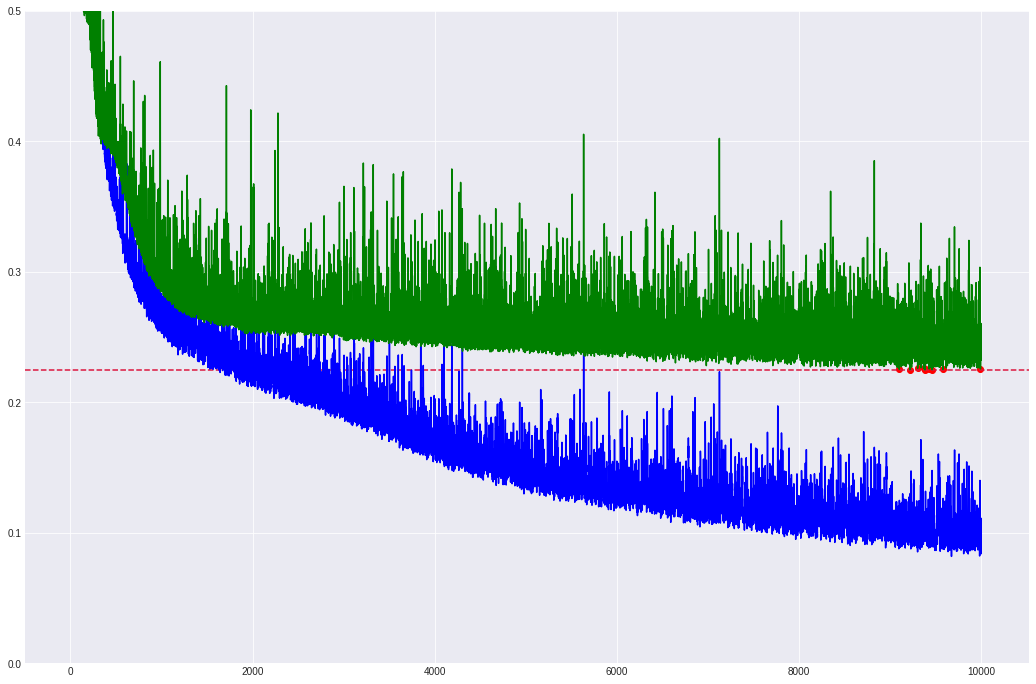

In [64]:
plt.figure(figsize=(18,12))
MSE = np.array(history.history['mean_absolute_error'])
val_MSE = np.array(history.history['val_mean_absolute_error'])
plt.ylim(0, 0.5)
asdf = np.argsort(val_MSE)[:10]
plt.axhline(y=val_MSE[asdf[0]], c="crimson", ls="--")
plt.plot(MSE, c="b")
plt.plot(val_MSE, c="g")
plt.scatter(asdf, val_MSE[asdf], c="r")

# Actual NN Simulation:
* Note: Just polyfit, and double polyfit with low-affected pixels, gives within error tolerance same results.

In [66]:
# all_input = np.zeros((nr_stars, nr_pixels))
# all_input[:,:-2] = mags_norm2.copy()
# all_input[:,-2] = Vband
# all_input[:,-1] = BV_color
all_input = mags_norm_poly2.copy()
all_output = labels.copy()
star_idxs = np.arange(0, nr_stars, 1)
np.random.shuffle(star_idxs)

all_predicted_output = []
all_actual_output = []
histories = []

factor = nr_stars//5
for i in range(5):
    if i < 4:
        test_idxs = star_idxs[i*factor:(i+1)*factor]
    else:
        test_idxs = star_idxs[i*factor:]
    input_test = all_input[test_idxs]
    input_train = np.delete(all_input, test_idxs, axis=0)
    output_test = all_output[test_idxs]
    output_train = np.delete(all_output, test_idxs, axis=0)
    
    Scaler = preprocessing.StandardScaler()
    Scaler.fit(output_train)
    output_train_scaled = Scaler.transform(output_train)
    output_test_scaled = Scaler.transform(output_test)

    clf = KerasRegressor(build_fn=nn_clf, batch_size=16, epochs=10000)
    history = clf.fit(input_train, output_train_scaled, verbose=0)
    histories.append(history)
    print(history.history['mean_squared_error'][-1])
    
    predicted = clf.predict(input_test)
    all_predicted_output.extend(Scaler.inverse_transform(predicted))
    all_actual_output.extend(output_test)
all_predicted_output = np.array(all_predicted_output)
all_actual_output = np.array(all_actual_output)

0.035718770627105975
0.02999878690175756
0.026337978931573722
0.035442946467702914
0.02766769574511619


Teff
Bias = -28.0831, MAE Scatter = 80.9402, RMSE Scatter = 120.7324
Log(g)
Bias = -0.0705, MAE Scatter = 0.1725, RMSE Scatter = 0.2411
FeH
Bias = -0.0358, MAE Scatter = 0.1053, RMSE Scatter = 0.2040


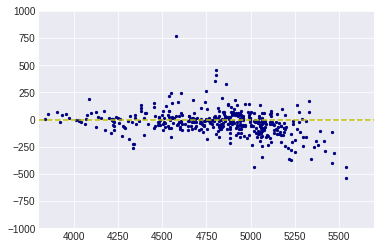

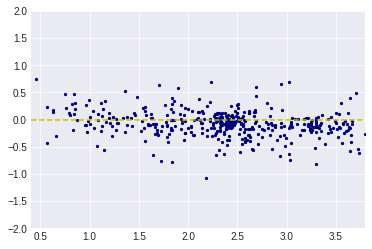

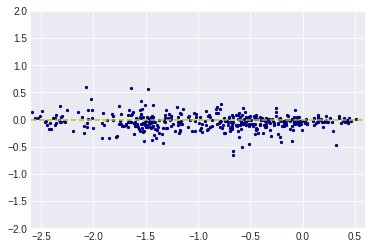

In [74]:
label_ylims = [[-1000, 1000], [-2, 2], [-2, 2]]
for i in range(3):
    plt.figure()
    plt.scatter(all_actual_output[:,i], all_predicted_output[:,i]-all_actual_output[:,i], s=5, c="navy")
#     plt.plot([-10,10000],[-10,10000], ls="--", c="y")
    plt.xlim(*label_xlims[i])
    plt.ylim(*label_ylims[i])
    plt.axhline(y=0, ls="--", c="y")
    bias = np.sum(all_predicted_output[:,i] - all_actual_output[:,i])/nr_stars
    scatter = np.mean(np.abs(all_predicted_output[:,i] - bias - all_actual_output[:,i]))
    scatter2 = np.sqrt(mean_squared_error(all_predicted_output[:,i] - bias, all_actual_output[:,i]))
    print(label_names[i])
    print(f"Bias = {bias:.4f}, MAE Scatter = {scatter:.4f}, RMSE Scatter = {scatter2:.4f}")

Teff
Bias = -27.3028, MAE Scatter = 86.7661, RMSE Scatter = 121.6567
Log(g)
Bias = -0.0243, MAE Scatter = 0.1783, RMSE Scatter = 0.2471
FeH
Bias = -0.0270, MAE Scatter = 0.1093, RMSE Scatter = 0.2204


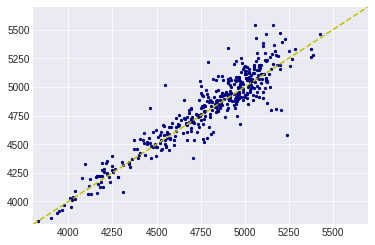

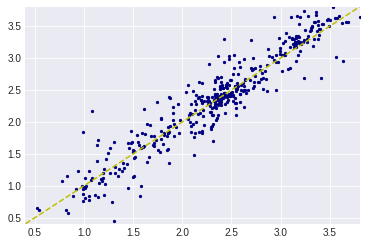

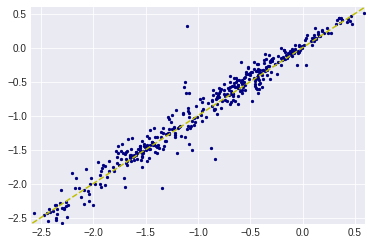

In [48]:
for i in range(3):
    plt.figure()
    plt.scatter(all_predicted_output[:,i], all_actual_output[:,i], s=5, c="navy")
    plt.plot([-10,10000],[-10,10000], ls="--", c="y")
    plt.xlim(*label_xlims[i])
    plt.ylim(*label_xlims[i])
    bias = np.sum(all_predicted_output[:,i] - all_actual_output[:,i])/nr_stars
    scatter = np.mean(np.abs(all_predicted_output[:,i] - bias - all_actual_output[:,i]))
    scatter2 = np.sqrt(mean_squared_error(all_predicted_output[:,i] - bias, all_actual_output[:,i]))
    print(label_names[i])
    print(f"Bias = {bias:.4f}, MAE Scatter = {scatter:.4f}, RMSE Scatter = {scatter2:.4f}")

Teff
Bias = -38.1834, MAE Scatter = 86.7142, RMSE Scatter = 131.3931
Log(g)
Bias = -0.0924, MAE Scatter = 0.1892, RMSE Scatter = 0.2826
FeH
Bias = -0.0417, MAE Scatter = 0.1194, RMSE Scatter = 0.2205


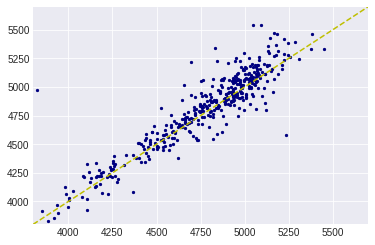

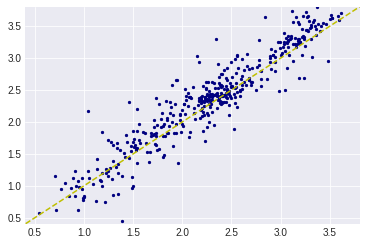

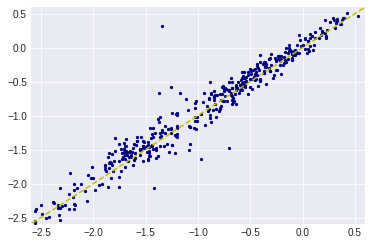

In [42]:
for i in range(3):
    plt.figure()
    plt.scatter(all_predicted_output[:,i], all_actual_output[:,i], s=5, c="navy")
    plt.plot([-10,10000],[-10,10000], ls="--", c="y")
    plt.xlim(*label_xlims[i])
    plt.ylim(*label_xlims[i])
    bias = np.sum(all_predicted_output[:,i] - all_actual_output[:,i])/nr_stars
    scatter = np.mean(np.abs(all_predicted_output[:,i] - bias - all_actual_output[:,i]))
    scatter2 = np.sqrt(mean_squared_error(all_predicted_output[:,i] - bias, all_actual_output[:,i]))
    print(label_names[i])
    print(f"Bias = {bias:.4f}, MAE Scatter = {scatter:.4f}, RMSE Scatter = {scatter2:.4f}")

Teff
Bias = -21.7918, MAE Scatter = 90.2100, RMSE Scatter = 124.8751
Log(g)
Bias = -0.0537, MAE Scatter = 0.1954, RMSE Scatter = 0.2796
FeH
Bias = -0.0204, MAE Scatter = 0.1251, RMSE Scatter = 0.2286


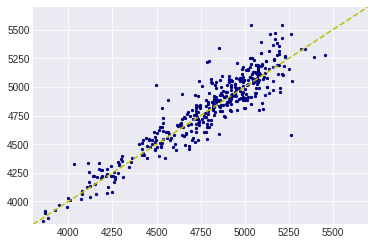

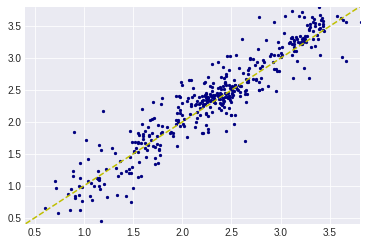

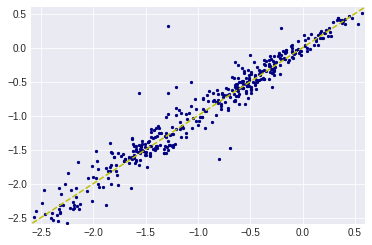

In [40]:
for i in range(3):
    plt.figure()
    plt.scatter(all_predicted_output[:,i], all_actual_output[:,i], s=5, c="navy")
    plt.plot([-10,10000],[-10,10000], ls="--", c="y")
    plt.xlim(*label_xlims[i])
    plt.ylim(*label_xlims[i])
    bias = np.sum(all_predicted_output[:,i] - all_actual_output[:,i])/nr_stars
    scatter = np.mean(np.abs(all_predicted_output[:,i] - bias - all_actual_output[:,i]))
    scatter2 = np.sqrt(mean_squared_error(all_predicted_output[:,i] - bias, all_actual_output[:,i]))
    print(label_names[i])
    print(f"Bias = {bias:.4f}, MAE Scatter = {scatter:.4f}, RMSE Scatter = {scatter2:.4f}")

In [ ]:
# Teff
# Bias = 18.9595, MAE Scatter = 74.3889, RMSE Scatter = 140.7355
# Log(g)
# Bias = 0.0546, MAE Scatter = 0.1754, RMSE Scatter = 0.3289
# FeH
# Bias = -0.0057, MAE Scatter = 0.0833, RMSE Scatter = 0.2983

# Teff
# Bias = 19.3650, MAE Scatter = 90.9237, RMSE Scatter = 131.5136
# Log(g)
# Bias = 0.0504, MAE Scatter = 0.1898, RMSE Scatter = 0.2605
# FeH
# Bias = 0.0345, MAE Scatter = 0.1197, RMSE Scatter = 0.2306

In [ ]:

model = nn_clf()
model.load_weights(".mdl_wts.hdf5")

labels_estimated_testing_scaled = model.predict(input_test)
labels_estimated_testing = ScalerNN.inverse_transform(labels_estimated_testing_scaled)
labels_test = output_test
labels_test_scaled = output_test_scaled

labels_estimated_training_scaled = model.predict(input_train)
labels_estimated_training = ScalerNN.inverse_transform(labels_estimated_training_scaled)
labels_train = output_train
labels_train_scaled = output_train_scaled


fig, ax = plt.subplots(1, 3, figsize = (18,10))
for i in range(3):
    bias = np.sum(labels_estimated_training[:,i] - labels_train[:,i])/nr_train
    scatter = mean_absolute_error(labels_estimated_training[:,i] - bias, labels_train[:,i])
    scatter2 = np.sqrt(mean_squared_error(labels_estimated_training[:,i] - bias, labels_train[:,i]))
    print(scatter, scatter2)
    RMS = np.sqrt(mean_squared_error(labels_estimated_training[:,i], labels_train[:,i]))
    RMS2 = np.sqrt(mean_squared_error(labels_estimated_training_scaled[:,i], labels_train_scaled[:,i]))
    MAE = mean_absolute_error(labels_estimated_training[:,i], labels_train[:,i])
    MAE2 = mean_absolute_error(labels_estimated_training_scaled[:,i], labels_train_scaled[:,i])
    ax[i].scatter(labels_train[:,i], labels_estimated_training[:,i], s=4, c="navy")
    ax[i].plot([-100,6000],[-100,6000], c="y")
    ax[i].set_xlim(*label_xlims[i]); ax[i].set_ylim(*label_xlims[i])
    ax[i].set_title(f"{label_names[i]} - Training Data\nRMSE = {RMS:.4f}  |  RMSE(scaled) = {RMS2:.4f}\nMAE={MAE:.4f}    |     MAE(scaled)={MAE2:.4f}    |    BIAS = {bias:.4f}")
    ax[i].set_xlabel("ASPCAP Input Labels"); ax[i].set_ylabel("Model Predicted Labels")
plt.tight_layout();

fig, ax = plt.subplots(1, 3, figsize = (18,10))
for i in range(3):
    bias = np.sum(labels_estimated_testing[:,i] - labels_test[:,i])/nr_test
    scatter = mean_absolute_error(labels_estimated_testing[:,i] - bias, labels_test[:,i])
    scatter2 = np.sqrt(mean_squared_error(labels_estimated_testing[:,i] - bias, labels_test[:,i]))
    print(label_names[i])
    print(f"Bias = {bias:.4f}, MAE Scatter = {scatter:.4f}, RMSE Scatter = {scatter2:.4f}")
    RMS = np.sqrt(mean_squared_error(labels_estimated_testing[:,i], labels_test[:,i]))
    RMS2 = np.sqrt(mean_squared_error(labels_estimated_testing_scaled[:,i], labels_test_scaled[:,i]))
    MAE = mean_absolute_error(labels_estimated_testing[:,i], labels_test[:,i])
    MAE2 = mean_absolute_error(labels_estimated_testing_scaled[:,i], labels_test_scaled[:,i])
    ax[i].scatter(labels_test[:,i], labels_estimated_testing[:,i], s=4, c="navy")
    ax[i].plot([-100,6000],[-100,6000], c="y")
    ax[i].set_xlim(*label_xlims[i]); ax[i].set_ylim(*label_xlims[i])
    ax[i].set_title(f"{label_names[i]} - Testing Data\nRMSE = {RMS:.4f}  |  RMSE(scaled) = {RMS2:.4f}\nMAE={MAE:.4f}    |     MAE(scaled)={MAE2:.4f}    |    BIAS = {bias:.4f}")
    ax[i].set_xlabel("ASPCAP Input Labels"); ax[i].set_ylabel("Model Predicted Labels")
plt.tight_layout();

Teff
Bias = -19.5428, MAE Scatter = 93.2161, RMSE Scatter = 120.4938
Log(g)
Bias = 0.0607, MAE Scatter = 0.2135, RMSE Scatter = 0.2783
FeH
Bias = -0.0167, MAE Scatter = 0.1135, RMSE Scatter = 0.1570

Teff
Bias = -18.6715, MAE Scatter = 103.7592, RMSE Scatter = 127.8925
Log(g)
Bias = 0.0362, MAE Scatter = 0.2216, RMSE Scatter = 0.2823
FeH
Bias = 0.0278, MAE Scatter = 0.1151, RMSE Scatter = 0.1566

Teff
Bias = -25.4944, MAE Scatter = 99.6669, RMSE Scatter = 127.0146
Log(g)
Bias = 0.0094, MAE Scatter = 0.2049, RMSE Scatter = 0.2779
FeH
Bias = -0.0351, MAE Scatter = 0.1139, RMSE Scatter = 0.1700

# Round 2

In [ ]:
opti = optimizers.adam(amsgrad=True, lr=0.001)#, decay=0.01)
def nn_clf():
    model = Sequential()
    model.add(Dense(40, input_shape=(nr_pixels,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(40, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(2,   activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(40, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(40, activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(nr_pixels, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

In [ ]:
nn_clf().summary()

In [ ]:
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history = History()
clf = KerasRegressor(build_fn=nn_clf, batch_size=16, epochs=400, callbacks=[mcp_save, history], validation_split=0.15, verbose=1)
history = clf.fit(input_train, input_train)

In [ ]:
model = nn_clf()
model.load_weights(".mdl_wts.hdf5")

output_test_estimate = model.predict(input_test)

mean_squared_error(output_test_estimate, input_test)

* 20: 0.0009825877775683804, val_mean_squared_error: 0.0019
* 10: 0.0009274315601672493, val_mean_squared_error: 0.0024
* 5: 0.0012952996935757838, val_mean_squared_error: 0.0019
* 2: 0.0014044485762077848, val_mean_squared_error: 0.0016

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(input_test[34], lw=0.5, c="navy")
plt.plot(output_test_estimate[34], lw=0.5, c="crimson")
plt.ylim(0.7, 1.1)

In [ ]:
from keras import backend as K

outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([model.input, K.learning_phase()], outputs )   # evaluation function

# Testing
layer_outs = functor([mags, 1.])
plt.plot(layer_outs[8][:,4])
# for label in [Teff, logg, FeH]:
#     for NNlabel in layer_outs[3].T:
#         plt.figure()
#         plt.scatter(NNlabel, label)
#         p1, p0 = np.polyfit(NNlabel, label, 1)
#         x = np.linspace(NNlabel.min(), NNlabel.max(), 1001)
#         plt.plot(x, p1*x + p0)
#         plt.xlim(np.percentile(NNlabel, 10)-10000, np.percentile(NNlabel, 90)+10000)

# Hyperparameter Optimization

In [ ]:
import talos as ta
from talos.model.layers import hidden_layers
from keras.activations import relu, elu, linear

p = {
    'dropout' : [0],
    'hidden_layers' : [1,2,4],
    'neuron_size' : [18, 24, 32],
    'activation' : [linear, relu, elu],
    'batch_size' : [4, 8, 16, 32],
    'epochs' : [3000, 4000, 6000],
    'lr' : [0.0001, 0.0003, 0.0005]
}

def input_model(x_train, y_train, x_val, y_val, params):
    Scaler = preprocessing.StandardScaler()
    y_train_scaled = Scaler.fit_transform(y_train)
    y_val_scaled = Scaler.transform(y_val)
    
    opti = optimizers.adam(amsgrad=True, lr=params['lr'])

    model = Sequential()
    model.add(Dense(params['neuron_size'], input_shape=(nr_pixels,), activation="linear", kernel_initializer='random_uniform'))
    for i in range(params['hidden_layers']):
        model.add(Dense(params['neuron_size'], activation=params['activation'], kernel_initializer='random_uniform'))
    model.add(Dense(3, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_squared_error',  metrics=['mae',"mse"])
    out = model.fit(x_train, y_train_scaled,
                batch_size=params['batch_size'],
                epochs=params['epochs'],
                verbose=0,
                validation_data=[x_val, y_val_scaled])
    return out, model

In [ ]:
x, y = mags_norm, labels

h = ta.Scan(x, y,
            params=p,
            dataset_name='first_test',
            experiment_no='aaa',
            model=input_model,
            grid_downsample=0.05)

In [ ]:
h.data

In [ ]:
h1.data